# RETAIN & GAIN

# Customer Lifetime Value & Marketing Analytics — Master Notebook 

**Objective:** Provide an end‑to‑end, reproducible pipeline for CLV/LTV modeling and marketing analytics, including KPI computation, cohort analysis, LTV estimation, incrementality, and seasonality.

**Business Context:** Non‑contractual, continuous purchases (e‑commerce/retail) with probabilistic CLV models (BG/NBD for purchase frequency, Gamma‑Gamma for monetary value).

**Purpose:** Estimate future value and support segmentation, budgeting and CPA/ROAS optimization.

**Steps in this Master Notebook:** Data Import → Cleaning → Enrichment → EDA → KPIs → Cohorts → LTV → Incrementality → Seasonality → Documentation/Export.

In [ ]:
# === Libraries & Global Configuration ===
import os
import sys
import math
from pathlib import Path
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, types
from sqlalchemy import text 
from dotenv import dotenv_values
import requests
import json
from sqlalchemy import create_engine, text
import seaborn as sns
from lifelines import KaplanMeierFitter
from lifetimes.utils import summary_data_from_transaction_data
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from sqlalchemy import create_engine
from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.plotting import plot_frequency_recency_matrix, plot_probability_alive_matrix, plot_period_transactions
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings
from lifetimes.fitters import ConvergenceError

# Pandas display and reproducibility
pd.set_option('display.max_columns', 120)
pd.set_option('display.width', 160)
SEED = 42
np.random.seed(SEED)

# IO paths (edit as needed)
DATA_DIR = os.getenv('DATA_DIR', './data')
OUTPUT_DIR = os.getenv('OUTPUT_DIR', './outputs')
Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)

# Canonical dataframe placeholders
# df_raw = ...
# df = ...
# df_calendar = ...

### Libraries Used
- pandas, numpy, matplotlib, seaborn
- scikit‑learn, lifetimes
- datetime, pathlib, warnings


# Table of Contents

- [Masternotebook — Marketing Analytics Pipeline](#masternotebook-marketing-analytics-pipeline)
- [Step 1 — Extracting Data](#step-1-extracting-data)
- [Step 2 — Uploading Raw Data to AWS](#step-2-uploading-raw-data-to-aws)
- [Step 3 — Calendar API (Feature Enrichment)](#step-3-calendar-api-feature-enrichment)
- [Step 4 — Exploratory Data Analysis (EDA)](#step-4-exploratory-data-analysis-eda)
- [Step 5 — KPI](#step-5-kpi)
- [Step 6 — CLV / LTV Matrix](#step-6-clv-ltv-matrix)
- [Step 7 — Cohort Analysis](#step-7-cohort-analysis)
- [Step 8 — Incrementality (Lift)](#step-8-incrementality-lift)
- [Step 9 — Seasonality Analysis](#step-9-seasonality-analysis)


In [2]:
# --- Compatibility helpers for modern pandas & seaborn ---
try:
    import pandas as pd
    import seaborn as sns  # noqa: F401
    # pandas.DataFrame.append deprecation shim
    if not hasattr(pd.DataFrame, "append"):
        def _df_append(self, other, ignore_index=False, sort=False):
            import pandas as _pd
            return _pd.concat([self, other], ignore_index=ignore_index, sort=sort)
        pd.DataFrame.append = _df_append
except Exception:
    pass


# Step 1 — Extracting Data

<a id='step-1-extracting-data'></a>

In [ ]:
#!pip install openpyxl

In [3]:
df_online_sales = pd.read_csv('./Data/Online_Sales.csv')

In [4]:
df_online_sales.head(5)

customer_id  transaction_id transaction_date     product_sku                                product_description product_category  quantity  avg_price  \
0        17850           16679         1/1/2019  GGOENEBJ079499  Nest Learning Thermostat 3rd Gen-USA - Stainle...         Nest-USA         1     153.71   
1        17850           16680         1/1/2019  GGOENEBJ079499  Nest Learning Thermostat 3rd Gen-USA - Stainle...         Nest-USA         1     153.71   
2        17850           16681         1/1/2019  GGOEGFKQ020399              Google Laptop and Cell Phone Stickers           Office         1       2.05   
3        17850           16682         1/1/2019  GGOEGAAB010516  Google Men's 100% Cotton Short Sleeve Hero Tee...          Apparel         5      17.53   
4        17850           16682         1/1/2019  GGOEGBJL013999                    Google Canvas Tote Natural/Navy             Bags         1      16.50   

   delivery_charges coupon_status  
0               6.5          Used  
1               6.5          Used  
2               6.5          Used  
3               6.5      Not Used  
4               6.5          Used

In [5]:
df_online_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52924 entries, 0 to 52923
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   customer_id          52924 non-null  int64  
 1   transaction_id       52924 non-null  int64  
 2   transaction_date     52924 non-null  object 
 3   product_sku          52924 non-null  object 
 4   product_description  52924 non-null  object 
 5   product_category     52924 non-null  object 
 6   quantity             52924 non-null  int64  
 7   avg_price            52924 non-null  float64
 8   delivery_charges     52924 non-null  float64
 9   coupon_status        52924 non-null  object 
dtypes: float64(2), int64(3), object(5)
memory usage: 4.0+ MB


In [6]:
df_customers = pd.read_excel('./Data/CustomersData.xlsx')

In [7]:
df_customers.head(5)

customer_id gender    location  tenure_months
0        17850      M     Chicago             12
1        13047      M  California             43
2        12583      M     Chicago             33
3        13748      F  California             30
4        15100      M  California             49

In [8]:
df_discount = pd.read_csv('./Data/Discount_Coupon.csv')
df_marketing = pd.read_csv('./Data/Marketing_Spend.csv')
df_online_sales = pd.read_csv('./Data/Online_Sales.csv')
df_tax = pd.read_excel('./Data/Tax_amount.xlsx')

In [9]:
df_discount.head(5)

month product_category coupon_code  discount_pct
0   Jan          Apparel      SALE10            10
1   Feb          Apparel      SALE20            20
2   Mar          Apparel      SALE30            30
3   Jan         Nest-USA      ELEC10            10
4   Feb         Nest-USA      ELEC20            20

In [10]:
df_marketing.head(10)

date  offline_send  online_spend
0   1/1/2019          4500       2424.50
1   1/2/2019          4500       3480.36
2   1/3/2019          4500       1576.38
3   1/4/2019          4500       2928.55
4   1/5/2019          4500       4055.30
5   1/6/2019          4500       3796.85
6   1/7/2019          4500       2579.52
7   1/8/2019          5000       2551.38
8   1/9/2019          5000       3287.83
9  1/10/2019          5000        515.44

In [11]:
df_tax.head(5)

product_category   gst
0         Nest-USA  0.10
1           Office  0.10
2          Apparel  0.18
3             Bags  0.18
4        Drinkware  0.18

# Step 2 — Uploading Raw Data to AWS

<a id='step-2-uploading-raw-data-to-aws'></a>

In [12]:
# Let's load values from the .env file

config = dotenv_values()

# define variables for the login
pg_user = config['POSTGRES_USER']  # align the key label with your .env file !
pg_host = config['POSTGRES_HOST']
pg_port = config['POSTGRES_PORT']
pg_db = config['POSTGRES_DB']
pg_schema = config['POSTGRES_SCHEMA']
pg_pass = config['POSTGRES_PASS']

In [13]:
# Now building the URL with the values from the .env file

url = f'postgresql://{pg_user}:{pg_pass}@{pg_host}:{pg_port}/{pg_db}'

# without specifying the schema default connection is to the schema `public`
# url = f'postgresql://{pg_user}:{pg_pass}@{pg_host}:{pg_port}/{pg_db}'

### With a connection string we can create an ``engine``:

In [ ]:
pg_db

In [15]:
engine = create_engine(url, echo=False)

The engine object manages connections to the database. It can be used to open new connections or to handle several connections at once.

In [ ]:
# check your URL

engine.url

In [ ]:
my_schema = 'team_3' 

with engine.begin() as conn: 
    result = conn.execute(text(f'SET search_path TO {my_schema};'))

In [18]:
df_online_sales = pd.read_csv('./Data/Online_Sales.csv')
df_customers = pd.read_excel('./Data/CustomersData.xlsx')
df_discount = pd.read_csv('./Data/Discount_Coupon.csv')
df_marketing = pd.read_csv('./Data/Marketing_Spend.csv')
df_tax = pd.read_excel('./Data/Tax_amount.xlsx')

In [ ]:

# push DataFrames
df_online_sales.to_sql('online_sales', engine, schema=my_schema, if_exists='replace', index=False)
df_customers.to_sql('customers', engine, schema=my_schema, if_exists='replace', index=False)
df_discount.to_sql('discount_coupon', engine, schema=my_schema, if_exists='replace', index=False)
df_marketing.to_sql('marketing_spend', engine, schema=my_schema, if_exists='replace', index=False)
df_tax.to_sql('tax_amount', engine, schema=my_schema, if_exists='replace', index=False)

# Step 3 — Calendar API (Feature Enrichment)

<a id='step-3-calendar-api-feature-enrichment'></a>

1. Using Calendarific API to get a full list of holidays, their name, date (in ISO format), description, and type.

Calls the Calendarific API for US holidays (2019), normalizes JSON to df_holidays

In [ ]:
"""
api_key = '49iY1MzO98nxEimi5h3Skg1yCqUI4XId'
url = 'https://calendarific.com/api/v2/holidays'

params = {
    'api_key': api_key,
    'country': 'US',       # Change to 'DE' for Germany, etc.
    'year': 2019,
    # 'type': 'national',  # Optional: only public/national holidays, remove for all
}

response = requests.get(url, params=params)
print('Status:', response.status_code)
data = response.json()

# Sample: See structure
print(json.dumps(data, indent=2))

# Extract holidays
holidays = data['response']['holidays']

# Save to JSON
with open('calendarific_holidays_2019_us.json', 'w') as f:
    json.dump(holidays, f, indent=2)

# Convert to DataFrame for analysis
df = pd.DataFrame(holidays)
print(df[['name', 'date', 'description']].head())
"""


2. Normilizing data

In [ ]:
"""
with open('calendarific_holidays_2019_us.json') as f:
    holidays = json.load(f)

# Normalize
df_holidays = pd.json_normalize(
    holidays,
    sep='_',  # Separates nested keys with "_"
)

print(df_holidays.head())
"""

3. Flattening nested structure

In [ ]:
"""
with open('calendarific_holidays_2019_us.json') as f:
    holidays = json.load(f)

# Flatten the nested structure
df_holidays = pd.json_normalize(
    holidays,
    sep='_'
)

# Keep only relevant columns, and flatten the 'type' list
df_holidays = df_holidays[['name', 'description', 'date_iso', 'type']]
df_holidays['type'] = df_holidays['type'].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)
"""

In [ ]:
#df_holidays.head()

4. Exporting to AWS database

In [ ]:
"""
# 1. Set up connection (update credentials and host!)

config = dotenv_values()

# define variables for the login
pg_user = config['POSTGRES_USER']  
pg_host = config['POSTGRES_HOST']
pg_port = config['POSTGRES_PORT']
pg_db = config['POSTGRES_DB']
pg_schema = config['POSTGRES_SCHEMA']
pg_pass = config['POSTGRES_PASS']

url = f'postgresql://{pg_user}:{pg_pass}@{pg_host}:{pg_port}/{pg_db}'

engine = create_engine(url, echo=False)

# 2. Push your holidays DataFrame (assuming it's named df_holidays)
df_holidays.to_sql('holidays_2019_us', engine, schema=my_schema, if_exists='replace', index=False)
"""

# Step 4 — Exploratory Data Analysis (EDA)

<a id='step-4-exploratory-data-analysis-eda'></a>

Using mart_all_data:

- Customer demographics: unique customers; top locations by customers, spend, AOV.

- Price & revenue distributions: skewed, long right tails (high-value outliers).

- Customer behavior: top spenders, high-AOV customers (min orders filter), total quantities.

- Time trends: monthly orders & revenue.

- “Whale” analysis: cumulative revenue share (e.g., top 10% ≈ 42% of revenue).

- Category/gender breakdowns.

These are simple groupby + bar/line/box plots to visually validate the data and surface early insights.

In [19]:

# 1. Set up connection (update credentials and host!)

config = dotenv_values() 

# define variables for the login
pg_user = config['POSTGRES_USER']  # align the key label with your .env file !
pg_host = config['POSTGRES_HOST']
pg_port = config['POSTGRES_PORT']
pg_db = config['POSTGRES_DB']
pg_schema = config['POSTGRES_SCHEMA']
pg_pass = config['POSTGRES_PASS']

url = f'postgresql://{pg_user}:{pg_pass}@{pg_host}:{pg_port}/{pg_db}'

engine = create_engine(url, echo=False)

# 2. Load data

my_schema = "team_3"

mart_all_data = pd.read_sql(
    f"SELECT * FROM {my_schema}.mart_all_data;",
    engine,
    parse_dates=['transaction_date']
)

# Customer demographic data (for segmentation)
mart_customers = pd.read_sql(
    f"SELECT * FROM {my_schema}.mart_customers;",
    engine
)

In [20]:
mart_all_data.columns

Index(['transaction_date', 'transaction_id', 'customer_id', 'customer_gender', 'customer_location', 'customer_tenure_months', 'produkt_sku',
       'product_category', 'quantity', 'avg_price', 'delivery_charges', 'revenue', 'coupon_status', 'discount_pct', 'gst_onsale', 'daily_offline',
       'daily_online', 'transaction_month', 'transaction_month_str'],
      dtype='object')

In [21]:

# Helper functions
def topn(df, n=10):
    return df.head(n)

def print_md(txt):
    print(txt)

# Columns in your data
price_col = 'avg_price'
revenue_col = 'revenue'
product_col = 'produkt_sku'


In [22]:
# ---------- 1) Customer Demographics ----------

unique_customers = mart_all_data['customer_id'].nunique()
location_counts = (
    mart_all_data.groupby('customer_location')['customer_id']
    .nunique()
    .sort_values(ascending=False)
    .rename('unique_customers')
    .reset_index()
)

# Per-customer aggregates
cust_orders = (
    mart_all_data.groupby('customer_id')
    .agg(total_revenue=(revenue_col,'sum'),
         orders=('transaction_id','nunique'),
         customer_location=('customer_location','first'))
    .reset_index()
)
cust_orders['AOV'] = cust_orders['total_revenue'] / cust_orders['orders'].replace(0, np.nan)

# Top locations
location_spend = cust_orders.groupby('customer_location')['total_revenue'].sum().sort_values(ascending=False).reset_index()
location_aov   = cust_orders.groupby('customer_location')['AOV'].mean().sort_values(ascending=False).reset_index()

print_md(f"""
## CUSTOMER DEMOGRAPHICS

- **Unique customers:** **{unique_customers:,}**
- **Top locations by unique customers (top 10):**
""")
print(topn(location_counts, 10))

print_md("\n- **Top locations by total spend (top 10):**")
print(topn(location_spend, 10))

print_md("\n- **Top locations by average order value (AOV) (top 10):**")
print(topn(location_aov, 10))


## CUSTOMER DEMOGRAPHICS

- **Unique customers:** **1,468**
- **Top locations by unique customers (top 10):**

  customer_location  unique_customers
0        California               464
1          Illinois               456
2          New York               324
3        New Jersey               149
4     Washington DC                75

- **Top locations by total spend (top 10):**
  customer_location  total_revenue
0          Illinois     1819011.81
1        California     1615397.39
2          New York     1056559.33
3        New Jersey      452428.09
4     Washington DC      284033.07

- **Top locations by average order value (AOV) (top 10):**
  customer_location         AOV
0     Washington DC  210.542638
1          New York  193.606119
2        New Jersey  191.655340
3          Illinois  187.173256
4        California  182.263861


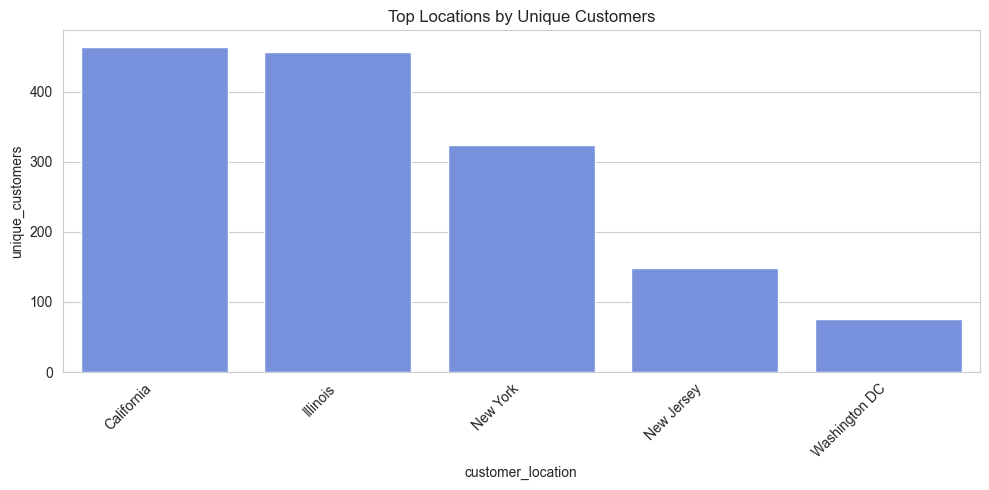

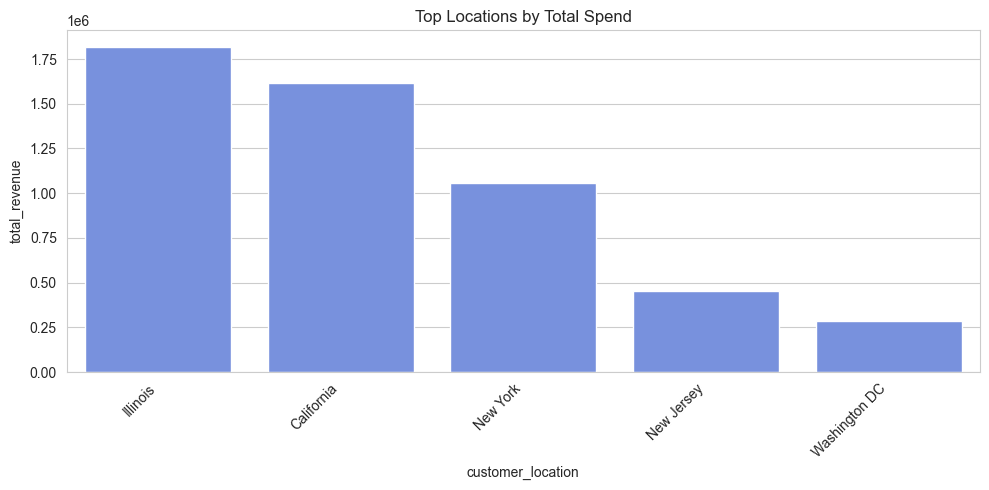

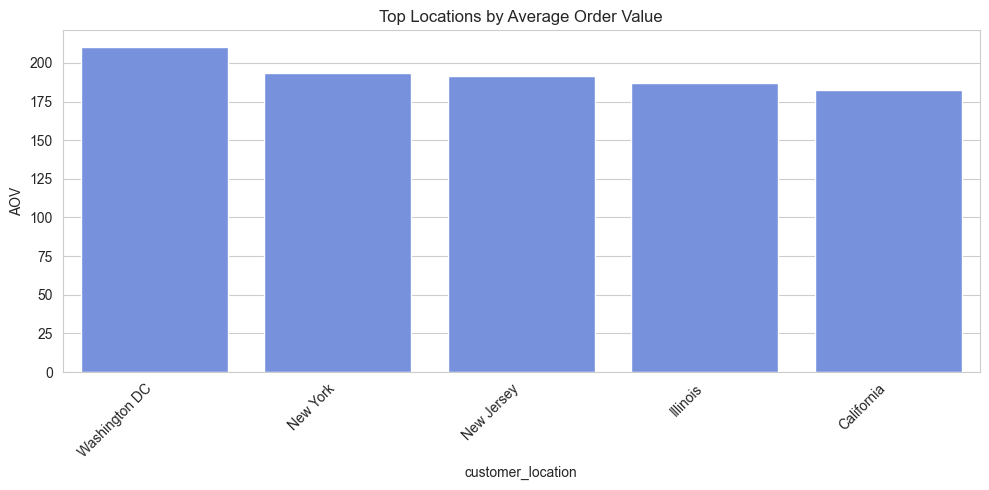

In [23]:
sns.set_style("whitegrid")
sns.set_palette("coolwarm")

plt.figure(figsize=(10,5))
sns.barplot(data=topn(location_counts,10), x='customer_location', y='unique_customers')
plt.title('Top Locations by Unique Customers')
plt.xticks(rotation=45, ha='right'); plt.tight_layout(); plt.show()

plt.figure(figsize=(10,5))
sns.barplot(data=topn(location_spend,10), x='customer_location', y='total_revenue')
plt.title('Top Locations by Total Spend')
plt.xticks(rotation=45, ha='right'); plt.tight_layout(); plt.show()

plt.figure(figsize=(10,5))
sns.barplot(data=topn(location_aov,10), x='customer_location', y='AOV')
plt.title('Top Locations by Average Order Value')
plt.xticks(rotation=45, ha='right'); plt.tight_layout(); plt.show()

In [24]:
# ---------- ) Price & Revenue Distribution ----------
price_series = mart_all_data[price_col]
rev_series   = mart_all_data[revenue_col]

desc_price = price_series.describe(percentiles=[.5,.75,.9,.95,.99]).to_frame(price_col)
desc_rev   = rev_series.describe(percentiles=[.5,.75,.9,.95,.99]).to_frame(revenue_col)

print_md("## PRICE & REVENUE DISTRIBUTION\n**Summary statistics (price):**")
print(desc_price)

print_md("\n**Summary statistics (revenue per line/row):**")
print(desc_rev)

print_md(f"""
- **Price skewness:** {price_series.skew():.2f}
- **Revenue skewness:** {rev_series.skew():.2f}
(Positive skew indicates long right tail / high-value outliers.)
""")

## PRICE & REVENUE DISTRIBUTION
**Summary statistics (price):**
          avg_price
count  52924.000000
mean      52.237646
std       64.006882
min        0.390000
50%       16.990000
75%      102.130000
90%      149.000000
95%      151.880000
99%      279.000000
max      355.740000

**Summary statistics (revenue per line/row):**
            revenue
count  52924.000000
mean      98.772385
std      166.441239
min        4.120000
50%       42.890000
75%      129.270000
90%      244.000000
95%      322.500000
99%      570.990000
max    10518.390000

- **Price skewness:** 1.63
- **Revenue skewness:** 18.08
(Positive skew indicates long right tail / high-value outliers.)



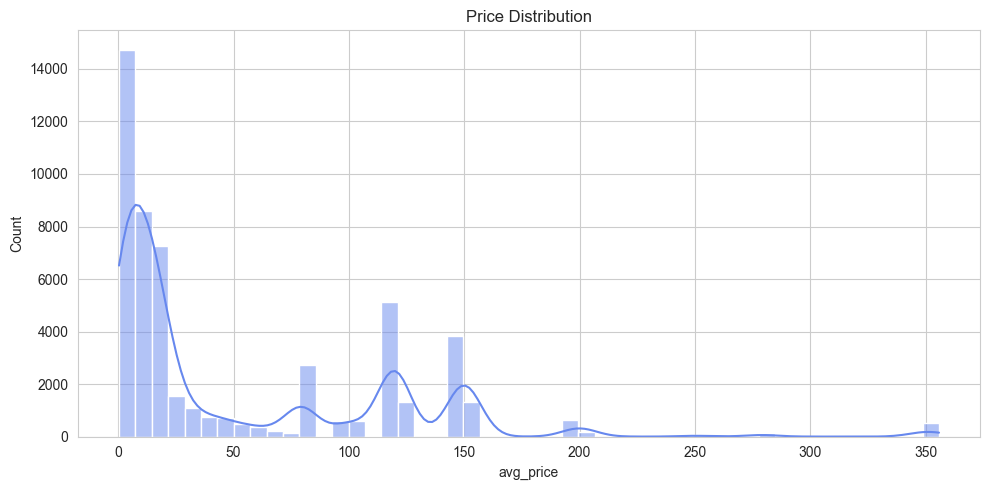

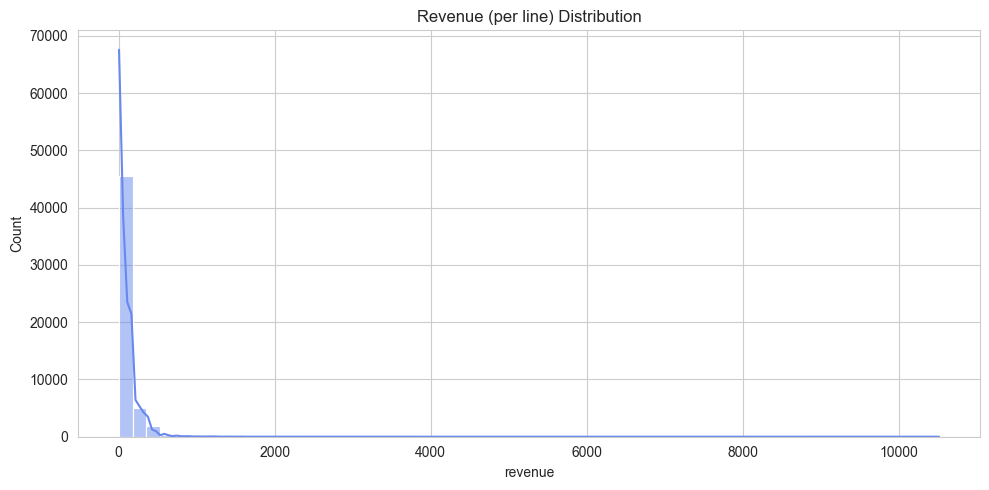

**Highest-priced products (by mean avg_price):**
      produkt_sku   avg_price
0  GGOENEBQ092299  351.287269
1  GGOENEBQ092399  279.472973
2  GGOENEBQ086599  272.892500
3  GGOEGGCX056399  250.107111
4  GGOENEBJ081899  199.940183
5  GGOENEBQ086499  199.916728
6  GGOENEBJ079499  150.981874
7  GGOENEBQ086899  150.350000
8  GGOENEBB081499  150.030253
9  GGOENEBQ081599  149.776500

**Locations by mean/median transaction value (top 10 by mean):**
  customer_location  mean_value  median_value  count
0     Washington DC  103.965253        47.990   2732
1        New Jersey  100.472594        42.000   4503
2        California  100.111390        43.225  16136
3          Illinois   98.966910        43.540  18380
4          New York   94.563620        40.480  11173


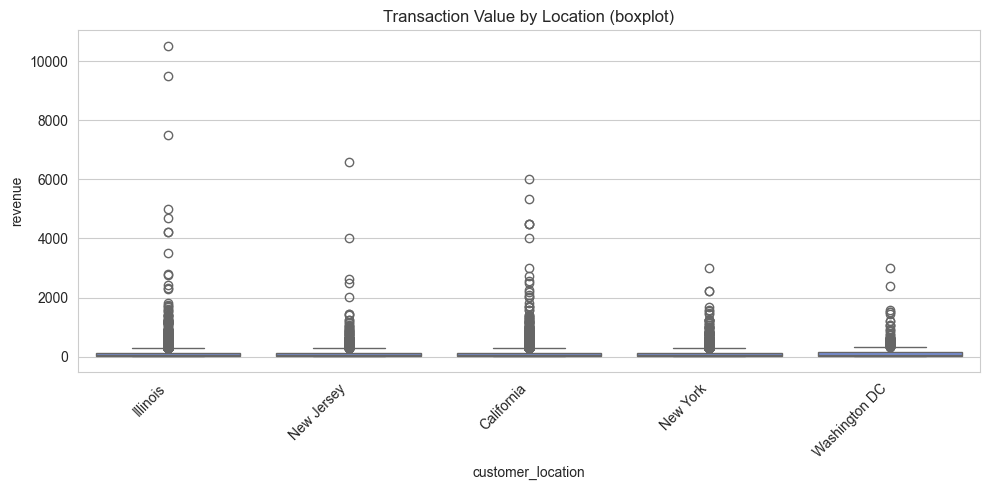

In [25]:
plt.figure(figsize=(10,5))
sns.histplot(price_series.dropna(), bins=50, kde=True)
plt.title('Price Distribution'); plt.xlabel(price_col); plt.tight_layout(); plt.show()

plt.figure(figsize=(10,5))
sns.histplot(rev_series.dropna(), bins=60, kde=True)
plt.title('Revenue (per line) Distribution'); plt.xlabel(revenue_col); plt.tight_layout(); plt.show()

# Highest / lowest priced products (by average price)
prod_price = (
    mart_all_data.groupby(product_col)[price_col]
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)
print_md("**Highest-priced products (by mean avg_price):**")
print(topn(prod_price, 10))

# Locations with highest median/mean transaction value
loc_txn_value = (
    mart_all_data.groupby('customer_location')[revenue_col]
    .agg(mean_value='mean', median_value='median', count='size')
    .sort_values(by='mean_value', ascending=False)
    .reset_index()
)
print_md("\n**Locations by mean/median transaction value (top 10 by mean):**")
print(topn(loc_txn_value, 10))

plt.figure(figsize=(10,5))
sns.boxplot(data=mart_all_data, x='customer_location', y=revenue_col)
plt.title('Transaction Value by Location (boxplot)')
plt.xticks(rotation=45, ha='right'); plt.tight_layout(); plt.show()

In [26]:
# ---------- 3) Purchasing Behaviour ----------
unique_txn = mart_all_data['transaction_id'].nunique()
print_md(f"## PURCHASING BEHAVIOUR\n- **Unique purchases (transactions):** **{unique_txn:,}**")

# Top customers by total spend
top_cust_by_spend = cust_orders.sort_values('total_revenue', ascending=False)
print_md("\n**Top customers by total spend:**")
print(topn(top_cust_by_spend[['customer_id','customer_location','orders','total_revenue','AOV']], 10))

# Highest AOV customers (require min orders to avoid one-off bias)
min_orders = 2
hi_aov = cust_orders[cust_orders['orders'] >= min_orders].sort_values('AOV', ascending=False)
print_md(f"\n**Customers with highest AOV (min {min_orders} orders):**")
print(topn(hi_aov[['customer_id','customer_location','orders','AOV','total_revenue']], 10))

# Customers with largest order quantities
qty_per_cust = (
    mart_all_data.groupby('customer_id')['quantity']
    .sum()
    .sort_values(ascending=False)
    .reset_index()
)
print_md("\n**Customers with largest total quantities purchased:**")
print(topn(qty_per_cust, 10))

# Repeat purchase rate
repeat_rate = (cust_orders['orders'] > 1).mean()
print_md(f"\n**Repeat purchase rate:** **{repeat_rate:.2%}**")

## PURCHASING BEHAVIOUR
- **Unique purchases (transactions):** **25,061**

**Top customers by total spend:**
      customer_id customer_location  orders  total_revenue         AOV
118         12748          Illinois     328       83112.26  253.391037
736         15311          Illinois     291       80775.51  277.579072
563         14606          Illinois     289       64045.50  221.610727
643         14911        California     276       56169.82  203.513841
1355        17841        California     263       53896.30  204.928897
1218        17337        California     139       38162.49  274.550288
1358        17850          Illinois     177       37714.02  213.073559
667         15039          Illinois     148       30508.02  206.135270
202         13089        New Jersey     176       30472.73  173.140511
578         14667        California      71       27835.61  392.050845

**Customers with highest AOV (min 2 orders):**
      customer_id customer_location  orders          AOV  tota

## TIME-BASED TRENDS
**Orders by month:**
    transaction_month  orders
0                 1.0    2102
1                 2.0    1664
2                 3.0    1991
3                 4.0    1813
4                 5.0    2034
5                 6.0    1940
6                 7.0    2080
7                 8.0    2414
8                 9.0    1932
9                10.0    2125
10               11.0    2282
11               12.0    2684

**Revenue by month:**
    transaction_month    revenue
0                 1.0  462866.90
1                 2.0  360036.40
2                 3.0  410408.03
3                 4.0  443100.16
4                 5.0  349159.59
5                 6.0  358594.96
6                 7.0  421362.00
7                 8.0  462309.94
8                 9.0  401553.82
9                10.0  455643.16
10               11.0  541254.55
11               12.0  561140.18


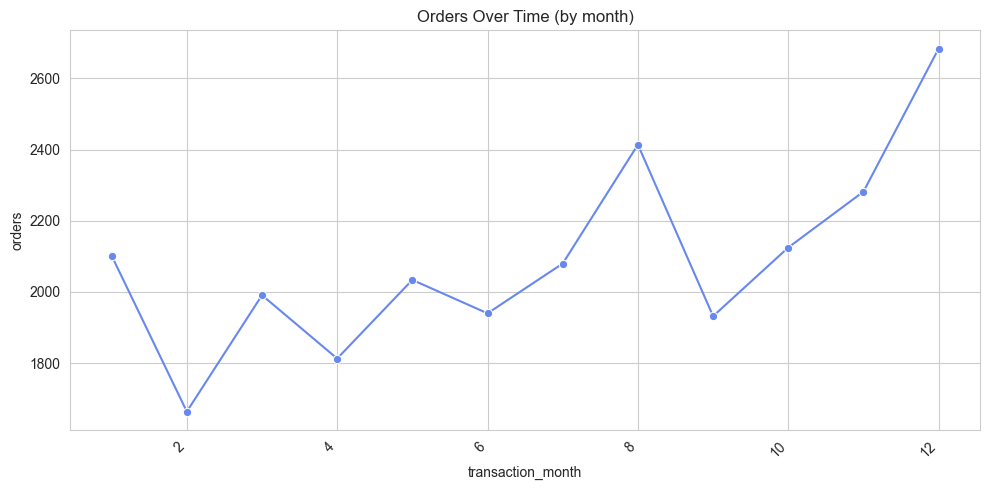

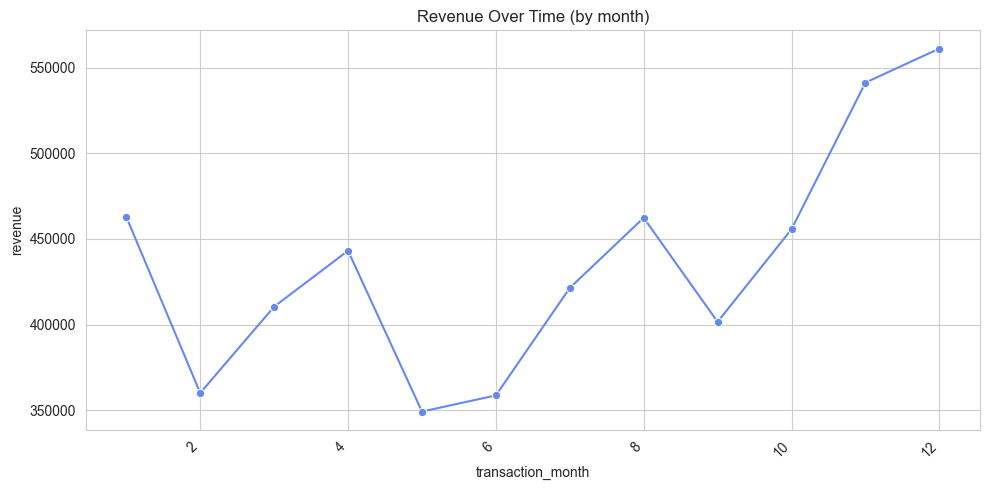

In [27]:
# ---------- 4) Time-based Trends ----------
orders_by_month = (
    mart_all_data.groupby('transaction_month')['transaction_id']
    .nunique()
    .reset_index(name='orders')
)
revenue_by_month = (
    mart_all_data.groupby('transaction_month')[revenue_col]
    .sum()
    .reset_index(name='revenue')
)

print_md("## TIME-BASED TRENDS\n**Orders by month:**")
print(orders_by_month)
print_md("\n**Revenue by month:**")
print(revenue_by_month)

plt.figure(figsize=(10,5))
sns.lineplot(data=orders_by_month, x='transaction_month', y='orders', marker='o')
plt.title('Orders Over Time (by month)'); plt.xticks(rotation=45, ha='right')
plt.tight_layout(); plt.show()

plt.figure(figsize=(10,5))
sns.lineplot(data=revenue_by_month, x='transaction_month', y='revenue', marker='o')
plt.title('Revenue Over Time (by month)'); plt.xticks(rotation=45, ha='right')
plt.tight_layout(); plt.show()

## INTERESTING INSIGHTS
**Locations with highest median prices (top 10):**
  customer_location  median_price  mean_price  count
0     Washington DC        18.515   55.598712   2732
1        California        16.990   52.363269  16136
2          Illinois        16.990   51.912777  18380
3        New Jersey        16.990   53.146298   4503
4          New York        16.790   51.402594  11173

**High spenders with few unique products (top 10):**
      customer_id customer_location  orders  unique_products  total_revenue         AOV
118         12748          Illinois     328              308       83112.26  253.391037
736         15311          Illinois     291              237       80775.51  277.579072
563         14606          Illinois     289              286       64045.50  221.610727
643         14911        California     276              209       56169.82  203.513841
1355        17841        California     263              267       53896.30  204.928897
1218        17337        

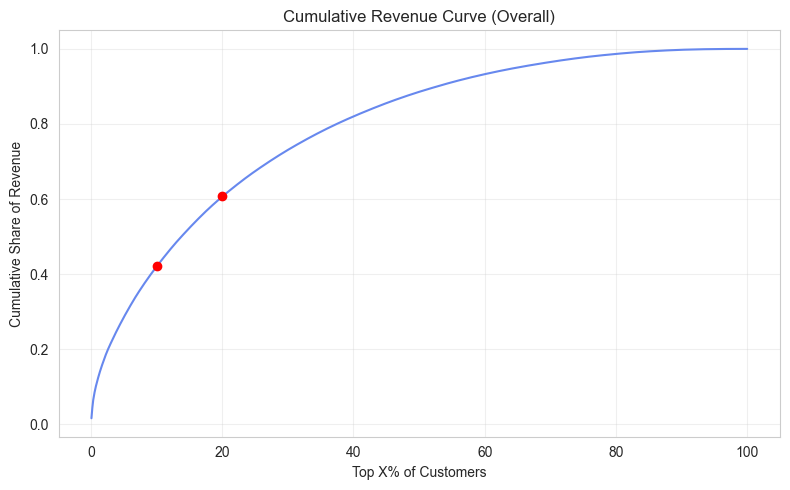

In [28]:
# ---------- 5) Interesting Insights ----------
# (A) Locations with extreme prices
loc_price_stats = (
    mart_all_data.groupby('customer_location')[price_col]
    .agg(median_price='median', mean_price='mean', count='size')
    .sort_values('median_price', ascending=False)
    .reset_index()
)
print_md("## INTERESTING INSIGHTS\n**Locations with highest median prices (top 10):**")
print(topn(loc_price_stats, 10))

# (B) High spenders with low product variety
cust_product_count = (
    mart_all_data.groupby('customer_id')[product_col]
    .nunique()
    .reset_index(name='unique_products')
)
merged = cust_orders.merge(cust_product_count, on='customer_id', how='left')
notable = merged.sort_values(['total_revenue','unique_products'], ascending=[False, True])

print_md("\n**High spenders with few unique products (top 10):**")
print(topn(notable[['customer_id','customer_location','orders','unique_products','total_revenue','AOV']], 10))

# (C) Whale analysis: % revenue from top 10% and 20% customers
cust_spend = cust_orders[['customer_id','total_revenue']].sort_values('total_revenue', ascending=False).reset_index(drop=True)
cum_share = cust_spend['total_revenue'].cumsum() / cust_spend['total_revenue'].sum()
pct = (np.arange(1, len(cust_spend)+1) / len(cust_spend))

top10_share = cum_share.iloc[int(np.ceil(0.10 * len(cust_spend)))-1]
top20_share = cum_share.iloc[int(np.ceil(0.20 * len(cust_spend)))-1]

print_md(f"""
**Whale analysis (overall):**
- Revenue share from **top 10%** customers: **{top10_share*100:.1f}%**
- Revenue share from **top 20%** customers: **{top20_share*100:.1f}%**
""")

plt.figure(figsize=(8,5))
plt.plot(pct*100, cum_share, label='Cumulative Revenue Share')
plt.scatter([10,20], [top10_share, top20_share], color='red', zorder=5)
plt.title('Cumulative Revenue Curve (Overall)')
plt.xlabel('Top X% of Customers'); plt.ylabel('Cumulative Share of Revenue')
plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()


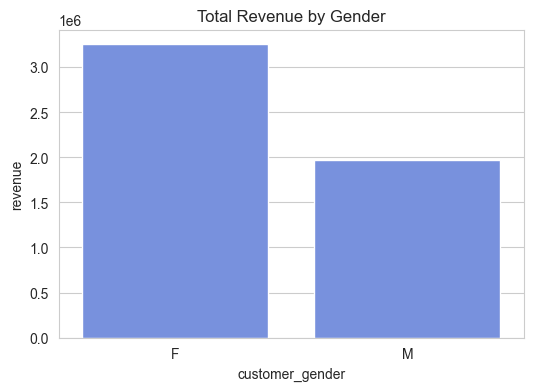

In [29]:
# Gender Spend Analysis
gender_spend = mart_all_data.groupby('customer_gender')[revenue_col].sum().reset_index()
plt.figure(figsize=(6,4))
sns.barplot(data=gender_spend, x='customer_gender', y=revenue_col)
plt.title('Total Revenue by Gender')
plt.show()


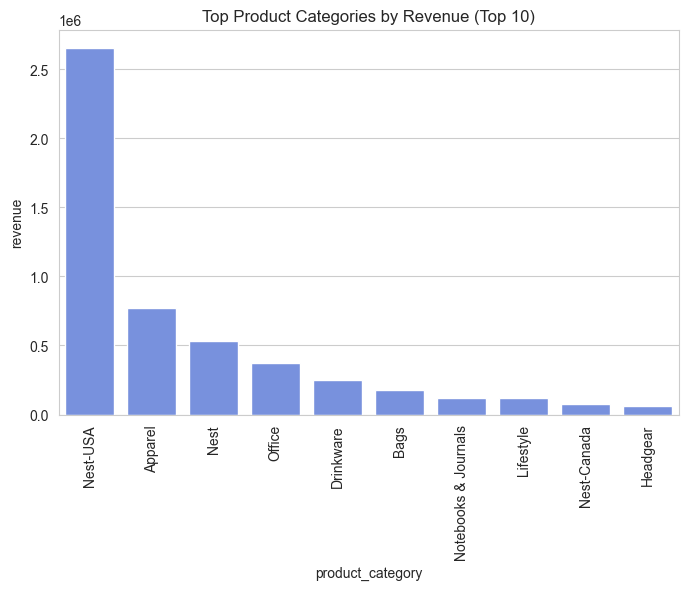

In [30]:
# Product Category Leaders
category_spend = mart_all_data.groupby('product_category')[revenue_col].sum().sort_values(ascending=False).reset_index()
plt.figure(figsize=(8,5))
sns.barplot(data=category_spend.head(10), x='product_category', y=revenue_col)
plt.title('Top Product Categories by Revenue (Top 10)')
plt.xticks(rotation=90)
plt.show()

In [31]:
mart_all_data.head()

transaction_date  transaction_id  customer_id customer_gender customer_location  customer_tenure_months     produkt_sku product_category  quantity  \
0       2019-04-19           25990        15811               F          Illinois                      27  GGOEWCKQ085457      Accessories         1   
1       2019-04-07           25038        17999               F        New Jersey                      30  GGOEGBPB081999      Accessories         1   
2       2019-04-07           25038        17999               F        New Jersey                      30  GGOEGBPB082099      Accessories         1   
3       2019-04-28           26637        18116               F          Illinois                      38  GGOEGBPB081999      Accessories         1   
4       2019-08-02           34452        16889               F          Illinois                      23  GGOEGBPB081999      Accessories         1   

   avg_price  delivery_charges  revenue coupon_status  discount_pct  gst_onsale  daily_offline  daily_online  transaction_month transaction_month_str  
0      16.99               6.0    22.99       Clicked          10.0         0.1           4000       1754.92                4.0                   apr  
1      49.99               6.5    56.49          Used          10.0         0.1           2500       2719.46                4.0                   apr  
2      59.99               6.5    66.49       Clicked          10.0         0.1           2500       2719.46                4.0                   apr  
3      39.99               6.0    45.99       Clicked          10.0         0.1           3500       2019.73                4.0                   apr  
4      34.99               6.0    40.99          Used          20.0         0.1           1500       2155.96                8.0                   aug

In [32]:
temp_df = (
    mart_all_data.groupby('transaction_id')['customer_id']
    .agg(median_price='count', mean_price='mean', count='size')
    .sort_values('median_price', ascending=False)
    .reset_index()
)

# Step 5 — KPI

<a id='step-5-kpi'></a>

Revenue / Orders / New cust / Spend → AOV, CAC, ROAS

- Monthly aggregates (from mart_all):

monthly_rev: sum net_revenue by transaction_month_str.

monthly_ord: unique transaction_id by transaction_month_str.

- New customers: find each customer’s first purchase month (first_month), then count by month.

- Marketing spend: sum total_spend by marketing month_str (renamed to spend_month).

Safe merge (fixes your earlier plotting error):
Merge on explicit keys, then keep one month column:

kpi = rev ⟂ ord ⟂ spend ⟂ new_customers → month_str, total_revenue, order_count, total_spend, new_customers.

Compute KPIs:

AOV = total_revenue / order_count

CAC = total_spend / new_customers

ROAS = total_revenue / total_spend

Charts: line for revenue; bars for orders and ROAS.


In [ ]:
#!pip install xlrd

In [33]:
mart_all_data = pd.read_csv('../LTV-Capstone-Project/mart_all_data.csv')
mart_all_data.head(2)

customer_id customer_gender customer_location  customer_tenure_months  transaction_id transaction_date     produkt_sku product_category  quantity  \
0        15811               F          Illinois                      27           25990       2019-04-19  GGOEWCKQ085457      Accessories         1   
1        17999               F        New Jersey                      30           25038       2019-04-07  GGOEGBPB081999      Accessories         1   

   avg_price  delivery_charges coupon_status  discount_pct  gst_onsale  offline_spend_that_day  online_spend_that_day  transaction_year  transaction_month  \
0      16.99               6.0       Clicked          10.0         0.1                    4000                1754.92            2019.0                4.0   
1      49.99               6.5          Used          10.0         0.1                    2500                2719.46            2019.0                4.0   

  transaction_month_str  transaction_day_of_month transaction_day_of_week  
0                   apr                      19.0                  friday  
1                   apr                       7.0                  sunday

In [34]:
mart_all_data.columns

Index(['customer_id', 'customer_gender', 'customer_location', 'customer_tenure_months', 'transaction_id', 'transaction_date', 'produkt_sku',
       'product_category', 'quantity', 'avg_price', 'delivery_charges', 'coupon_status', 'discount_pct', 'gst_onsale', 'offline_spend_that_day',
       'online_spend_that_day', 'transaction_year', 'transaction_month', 'transaction_month_str', 'transaction_day_of_month', 'transaction_day_of_week'],
      dtype='object')

In [74]:
# 1. Gross Sales
mart_all_data['gross_sales'] = mart_all_data['quantity'] * mart_all_data['avg_price']

# 2. Discount Amount
mart_all_data['discount_amount'] = mart_all_data['gross_sales'] * (mart_all_data['discount_pct'] / 100)

# 3. Net Subtotal
mart_all_data['net_subtotal'] = mart_all_data['gross_sales'] - mart_all_data['discount_amount']

# 4. Pre-Tax Total (add delivery)
mart_all_data['pre_tax_total'] = mart_all_data['net_subtotal'] + mart_all_data['delivery_charges']

# 5. GST Amount
mart_all_data['gst_amount'] = mart_all_data['pre_tax_total'] * (mart_all_data['gst_onsale'] / 100)

# 6. Final Invoice (what customer paid)
mart_all_data['invoice_value'] = mart_all_data['pre_tax_total'] + mart_all_data['gst_amount']

# 7. Net Revenue (excludes GST remitted to govt)
mart_all_data['net_revenue'] = mart_all_data['pre_tax_total']

In [75]:
historical_ltv = mart_all_data.groupby('customer_id')['net_revenue'].sum().reset_index()
historical_ltv.columns = ['customer_id', 'historical_ltv']
print(historical_ltv.head())

   customer_id  historical_ltv
0        12346         171.693
1        12347       10589.289
2        12348        1339.652
3        12350        1079.929
4        12356        1647.219


In [76]:
mart_all_data.columns

Index(['customer_id', 'customer_gender', 'customer_location', 'customer_tenure_months', 'transaction_id', 'transaction_date', 'produkt_sku',
       'product_category', 'quantity', 'avg_price', 'delivery_charges', 'coupon_status', 'discount_pct', 'gst_onsale', 'offline_spend_that_day',
       'online_spend_that_day', 'transaction_year', 'transaction_month', 'transaction_month_str', 'transaction_day_of_month', 'transaction_day_of_week',
       'gross_sales', 'discount_amount', 'net_subtotal', 'pre_tax_total', 'gst_amount', 'invoice_value', 'net_revenue', 'first_purchase_month', 'order_month',
       'months_since_signup'],
      dtype='object')

In [ ]:
#!pip install lifetimes

In [77]:

# Ensure transaction_date is datetime
mart_all_data['transaction_date'] = pd.to_datetime(mart_all_data['transaction_date'])

# Generate summary for LTV modeling
summary = summary_data_from_transaction_data(
    mart_all_data,
    customer_id_col='customer_id',
    datetime_col='transaction_date',
    monetary_value_col='net_revenue',
    observation_period_end=mart_all_data['transaction_date'].max()
)

print(summary.head())

             frequency  recency      T  monetary_value
customer_id                                           
12346              0.0      0.0  107.0           0.000
12347              2.0    223.0  282.0        1163.375
12348              1.0    119.0  192.0         693.731
12350              0.0      0.0   17.0           0.000
12356              0.0      0.0  107.0           0.000


In [78]:

bgf = BetaGeoFitter()
bgf.fit(summary['frequency'], summary['recency'], summary['T'])

<lifetimes.BetaGeoFitter: fitted with 1468 subjects, a: 0.58, alpha: 61.18, b: 1.49, r: 0.54>

In [79]:

# Only use customers with freq > 0
returning_customers = summary[summary['frequency'] > 0]

ggf = GammaGammaFitter()
ggf.fit(returning_customers['frequency'], returning_customers['monetary_value'])

<lifetimes.GammaGammaFitter: fitted with 734 subjects, p: 0.60, q: 4.81, v: 7983.58>

In [80]:
# Predict expected number of purchases
summary['predicted_purchases_6m'] = bgf.conditional_expected_number_of_purchases_up_to_time(180,
            summary['frequency'], summary['recency'], summary['T'])

# Predict expected average revenue
summary['predicted_avg_value'] = ggf.conditional_expected_average_profit(summary['frequency'], summary['monetary_value'])

# Final LTV
summary['predicted_ltv_6m'] = summary['predicted_purchases_6m'] * summary['predicted_avg_value']

# View top customers by predicted LTV
summary[['predicted_ltv_6m']].sort_values(by='predicted_ltv_6m', ascending=False).head()

predicted_ltv_6m
customer_id                  
15311            21033.926265
14606            17049.487254
14911            15974.121923
17841            14981.066823
13089             9469.652429

In [81]:
summary.head(2)

frequency  recency      T  monetary_value  predicted_purchases_6m  predicted_avg_value  predicted_ltv_6m
customer_id                                                                                                          
12346              0.0      0.0  107.0           0.000                0.486163          1265.594052        615.284554
12347              2.0    223.0  282.0        1163.375                0.867946          1240.987166       1077.109890

In [82]:
# Merge with demographics or customer segments
mart_customers=pd.read_csv('../LTV-Capstone-Project/mart_customers.csv')
ltv_final = summary.reset_index().merge(mart_customers, on='customer_id', how='left')

# Export to CSV for Tableau
ltv_final.to_csv("Customer_LTV_Summary.csv", index=False)

In [83]:
ltv_final.describe()

customer_id    frequency      recency            T  monetary_value  predicted_purchases_6m  predicted_avg_value  predicted_ltv_6m  tenure_months
count   1468.000000  1468.000000  1468.000000  1468.000000     1468.000000             1468.000000          1468.000000       1468.000000    1468.000000
mean   15314.386240     1.185286    64.358992   208.651226      639.936538                0.690629          1263.838591        877.776033      25.912125
std     1744.000367     2.235245    97.383296   104.677684     1331.197205                0.760671           227.004700       1174.402608      13.959667
min    12346.000000     0.000000     0.000000     0.000000        0.000000                0.000015           564.927071          0.035771       2.000000
25%    13830.500000     0.000000     0.000000   128.000000        0.000000                0.293539          1172.455841        363.268275      14.000000
50%    15300.000000     0.500000     0.500000   222.000000        3.836500                0.448239          1265.594052        553.572812      26.000000
75%    16882.250000     2.000000   121.000000   294.250000      812.452250                0.831766          1265.594052       1055.716632      38.000000
max    18283.000000    33.000000   358.000000   364.000000    19334.968000               10.239648          3738.084777      21033.926265      50.000000

In [84]:
ltv_final.columns

Index(['customer_id', 'frequency', 'recency', 'T', 'monetary_value', 'predicted_purchases_6m', 'predicted_avg_value', 'predicted_ltv_6m', 'gender', 'location',
       'tenure_months'],
      dtype='object')

In [ ]:
# 1. Set up connection (update credentials and host!)

config = dotenv_values() 

# define variables for the login
pg_user = config['POSTGRES_USER']  
pg_host = config['POSTGRES_HOST']
pg_port = config['POSTGRES_PORT']
pg_db = config['POSTGRES_DB']
pg_schema = config['POSTGRES_SCHEMA']
pg_pass = config['POSTGRES_PASS']

url = f'postgresql://{pg_user}:{pg_pass}@{pg_host}:{pg_port}/{pg_db}'

engine = create_engine(url, echo=False)


In [95]:
my_schema = "team_3"


mart_customers = pd.read_sql(f"SELECT * FROM {my_schema}.mart_customers;", engine)
mart_discount_coupon = pd.read_sql(f"SELECT * FROM {my_schema}.mart_discount_coupon;", engine)
mart_holidays_2019_us = pd.read_sql(f"SELECT * FROM {my_schema}.mart_holidays_2019_us;", engine)
mart_marketing_spend = pd.read_sql(f"SELECT * FROM {my_schema}.mart_marketing_spend;", engine)
mart_online_sales = pd.read_sql(f"SELECT * FROM {my_schema}.mart_online_sales;", engine)
mart_tax_amount = pd.read_sql(f"SELECT * FROM {my_schema}.mart_tax_amount;", engine)
mart_all_data = pd.read_sql(f"SELECT * FROM {my_schema}.mart_all_data;", engine)

1: Create Month String Columns


In [96]:
# Ensure transaction_date is datetime
mart_all_data['transaction_date'] = pd.to_datetime(mart_all_data['transaction_date'])
mart_all_data['transaction_month_str'] = mart_all_data['transaction_date'].dt.strftime('%Y-%m')

# Ensure marketing spend date is datetime and build month string
mart_marketing_spend['date'] = pd.to_datetime(mart_marketing_spend['date'])
mart_marketing_spend['month_str'] = mart_marketing_spend['date'].dt.strftime('%Y-%m')

# Calculate total marketing spend per day
mart_marketing_spend['total_spend'] = mart_marketing_spend['offline_spend'].fillna(0) + mart_marketing_spend['online_spend'].fillna(0)

2: Calculate Monthly Metrics
Revenue, Orders, New Customers, Spend

In [97]:
# Monthly revenue
monthly_revenue = mart_all_data.groupby('transaction_month_str')['revenue'].sum().reset_index(name='total_revenue')

# Monthly orders
monthly_orders = mart_all_data.groupby('transaction_month_str')['transaction_id'].nunique().reset_index(name='order_count')

# Monthly marketing spend
monthly_spend = mart_marketing_spend.groupby('month_str')['total_spend'].sum().reset_index()

# Monthly new customers (first purchase in month)
mart_all_data['customer_first_month'] = mart_all_data.groupby('customer_id')['transaction_date'].transform('min').dt.strftime('%Y-%m')
new_customers = mart_all_data.drop_duplicates('customer_id').groupby('customer_first_month')['customer_id'].count().reset_index(name='new_customers')

3: Merge All Monthly Metrics



In [98]:
summary = monthly_revenue.merge(monthly_spend, left_on='transaction_month_str', right_on='month_str', how='outer')
summary = summary.merge(monthly_orders, on='transaction_month_str', how='outer')
summary = summary.merge(new_customers, left_on='transaction_month_str', right_on='customer_first_month', how='left')

# KPIs
summary['AOV'] = summary['total_revenue'] / summary['order_count']
summary['CAC'] = summary['total_spend'] / summary['new_customers']
summary['ROAS'] = summary['total_revenue'] / summary['total_spend']

4: Overall (Lifetime) Metrics


“Overall” KPIs (lifecycle-style)

From mart_all_data:

- Repeat purchase rate = % customers with >1 transactions.

- Retention rate (any time) = % with purchases in at least 2 distinct months.

- 6-month retention = % of signups with any purchase in months 1–5 post-signup.

- Churn proxy = % with >6 months inactivity by a ref date (2019-12-31).

- Average LTV (historical) = mean revenue per customer (over observed period).

- LTV:CAC = avg LTV / avg CAC (with CAC from the monthly CAC table).

Repeat Purchase Rate

In [274]:
repeat_customers = mart_all_data.groupby('customer_id')['transaction_id'].nunique().reset_index()
repeat_customers['is_repeat'] = repeat_customers['transaction_id'] > 1
repeat_rate = repeat_customers['is_repeat'].mean()

Churn Rate

In [275]:
# Find last purchase date per customer
last_purchase = mart_all_data.groupby('customer_id')['transaction_date'].max().reset_index()
last_purchase['transaction_date'] = pd.to_datetime(last_purchase['transaction_date'])

reference_date = pd.to_datetime('2019-12-31')

# Calculate months since last purchase
last_purchase['months_since'] = ((reference_date - last_purchase['transaction_date']) / pd.Timedelta(days=30)).astype(int)

# Customers with >6 months inactivity are considered churned
churned = last_purchase[last_purchase['months_since'] > 6]

# Churn rate = churned customers / total unique customers
churn_rate = len(churned) / mart_all_data['customer_id'].nunique()

LTV (Average revenue per customer)


In [99]:
ltv = mart_all_data.groupby('customer_id')['revenue'].sum().mean()

LTV:CAC Ratio

In [100]:
avg_cac = summary['CAC'].mean()
ltv_cac_ratio = ltv / avg_cac

Retention Rate

(Percent of customers who purchased in at least 2 different months)

In [101]:
customer_months = mart_all_data.groupby('customer_id')['transaction_month_str'].nunique().reset_index()
customer_months['retained'] = customer_months['transaction_month_str'] > 1
retention_rate = customer_months['retained'].mean()

Retention Rate 6 m

In [102]:
mart_all_data['transaction_date'] = pd.to_datetime(mart_all_data['transaction_date'])
mart_all_data['first_purchase_month'] = mart_all_data.groupby('customer_id')['transaction_date'].transform('min').dt.to_period('M')
mart_all_data['order_month'] = mart_all_data['transaction_date'].dt.to_period('M')
mart_all_data['months_since_signup'] = (mart_all_data['order_month'] - mart_all_data['first_purchase_month']).apply(lambda x: x.n)
# Customers who purchased in months 1–6 (excluding 0, the signup month)
retained_customers = mart_all_data[
    (mart_all_data['months_since_signup'] > 0) & (mart_all_data['months_since_signup'] < 6)
]['customer_id'].unique()

# All unique customers (signups)
all_customers = mart_all_data['customer_id'].unique()

# 6-month retention rate
retention_6m = len(retained_customers) / len(all_customers)
print(f"6-month retention rate: {retention_6m:.2%}")

6-month retention rate: 33.72%


In [103]:
overall_kpis = pd.DataFrame({
    'ltv': [ltv],
    'repeat_purchase_rate': [repeat_rate],
    'retention_rate': [retention_rate],
    'retention_rate_6m': [retention_6m],
    'churn_rate': [churn_rate],
    'ltv:cac_ratio': [ltv_cac_ratio]
})

print(overall_kpis)

           ltv  repeat_purchase_rate  retention_rate  retention_rate_6m  churn_rate  ltv:cac_ratio
0  3560.919407               0.91485        0.395095           0.337193    0.267711       2.688159


In [105]:
def _read_csv(path, **kw):
    if not Path(path).exists():
        raise FileNotFoundError(f"Missing file: {path}")
    return pd.read_csv(path, **kw)

def _read_excel(path, **kw):
    if not Path(path).exists():
        raise FileNotFoundError(f"Missing file: {path}")
    return pd.read_excel(path, **kw)

df_sales      = _read_csv(os.path.join(DATA_DIR, "Online_Sales.csv"))
df_customers  = _read_excel(os.path.join(DATA_DIR, "CustomersData.xlsx"))
df_discount   = _read_csv(os.path.join(DATA_DIR, "Discount_Coupon.csv"))
df_marketing  = _read_csv(os.path.join(DATA_DIR, "Marketing_Spend.csv"))
df_tax        = _read_excel(os.path.join(DATA_DIR, "Tax_amount.xlsx"))

print("Shapes:",
      "sales", df_sales.shape,
      "customers", df_customers.shape,
      "discount", df_discount.shape,
      "marketing", df_marketing.shape,
      "tax", df_tax.shape, sep=" | ")
df_sales.head(3)


Shapes: | sales | (52924, 10) | customers | (1468, 4) | discount | (204, 4) | marketing | (365, 3) | tax | (20, 2)


customer_id  transaction_id transaction_date     product_sku                                product_description product_category  quantity  avg_price  \
0        17850           16679         1/1/2019  GGOENEBJ079499  Nest Learning Thermostat 3rd Gen-USA - Stainle...         Nest-USA         1     153.71   
1        17850           16680         1/1/2019  GGOENEBJ079499  Nest Learning Thermostat 3rd Gen-USA - Stainle...         Nest-USA         1     153.71   
2        17850           16681         1/1/2019  GGOEGFKQ020399              Google Laptop and Cell Phone Stickers           Office         1       2.05   

   delivery_charges coupon_status  
0               6.5          Used  
1               6.5          Used  
2               6.5          Used

In [106]:
# Parse dates
df_sales['transaction_date'] = pd.to_datetime(df_sales['transaction_date'])

# Normalize discount table
_month_map = {m.lower()[:3]: i for i, m in enumerate(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'], start=1)}
df_discount['month_num'] = df_discount['month'].str.lower().str[:3].map(_month_map)

# Compute revenue per row (gross minus discount plus delivery, excl tax for net revenue)
row_gross = df_sales['quantity'] * df_sales['avg_price']
sales = df_sales.copy()
sales['month_num'] = sales['transaction_date'].dt.month
sales = sales.merge(df_discount[['month_num','product_category','discount_pct']],
                    on=['month_num','product_category'], how='left')
sales['discount_pct'] = sales['discount_pct'].fillna(0.0)

# Join tax by product_category
sales = sales.merge(df_tax[['product_category','gst']].rename(columns={'gst':'gst_rate'}),
                    on='product_category', how='left')
sales['gst_rate'] = sales['gst_rate'].fillna(0.0)

# Net subtotal, pre-tax, gst, invoice
sales['gross_sales']   = row_gross
sales['discount_amt']  = sales['gross_sales'] * (sales['discount_pct']/100.0)
sales['net_subtotal']  = sales['gross_sales'] - sales['discount_amt']
sales['pre_tax_total'] = sales['net_subtotal'] + sales['delivery_charges']
sales['gst_amount']    = sales['pre_tax_total'] * sales['gst_rate']
sales['invoice_value'] = sales['pre_tax_total'] + sales['gst_amount']
sales['net_revenue']   = sales['pre_tax_total']  # ex-GST

# Customer join (gender/location/tenure)
sales = sales.merge(df_customers.rename(columns={'gender':'customer_gender','location':'customer_location','tenure_months':'customer_tenure_months'}),
                    on='customer_id', how='left')

# Marketing spend per day to month_str
df_marketing['date'] = pd.to_datetime(df_marketing['date'])
df_marketing['month_str'] = df_marketing['date'].dt.strftime('%Y-%m')
df_marketing['total_spend'] = df_marketing['offline_send'].fillna(0) + df_marketing['online_spend'].fillna(0)

# Add calendar features
sales['transaction_month'] = sales['transaction_date'].dt.month
sales['transaction_month_str'] = sales['transaction_date'].dt.strftime('%Y-%m')
sales['transaction_day_of_month'] = sales['transaction_date'].dt.day
sales['transaction_day_of_week']  = sales['transaction_date'].dt.day_name().str.lower()

# Final mart
mart_all = sales.copy()
print("mart_all_data shape:", mart_all.shape)
mart_all.head(3)


mart_all_data shape: (52924, 27)


customer_id  transaction_id transaction_date     product_sku                                product_description product_category  quantity  avg_price  \
0        17850           16679       2019-01-01  GGOENEBJ079499  Nest Learning Thermostat 3rd Gen-USA - Stainle...         Nest-USA         1     153.71   
1        17850           16680       2019-01-01  GGOENEBJ079499  Nest Learning Thermostat 3rd Gen-USA - Stainle...         Nest-USA         1     153.71   
2        17850           16681       2019-01-01  GGOEGFKQ020399              Google Laptop and Cell Phone Stickers           Office         1       2.05   

   delivery_charges coupon_status  month_num  discount_pct  gst_rate  gross_sales  discount_amt  net_subtotal  pre_tax_total  gst_amount  invoice_value  \
0               6.5          Used          1          10.0       0.1       153.71        15.371       138.339        144.839     14.4839       159.3229   
1               6.5          Used          1          10.0       0.1       153.71        15.371       138.339        144.839     14.4839       159.3229   
2               6.5          Used          1          10.0       0.1         2.05         0.205         1.845          8.345      0.8345         9.1795   

   net_revenue customer_gender customer_location  customer_tenure_months  transaction_month transaction_month_str  transaction_day_of_month  \
0      144.839               M           Chicago                      12                  1               2019-01                         1   
1      144.839               M           Chicago                      12                  1               2019-01                         1   
2        8.345               M           Chicago                      12                  1               2019-01                         1   

  transaction_day_of_week  
0                 tuesday  
1                 tuesday  
2                 tuesday

KPIs (Monthly revenue, orders, AOV, CAC, ROAS)

In [107]:
# Monthly revenue & orders
monthly_rev = mart_all.groupby('transaction_month_str')['net_revenue'].sum().reset_index(name='total_revenue')
monthly_ord = mart_all.groupby('transaction_month_str')['transaction_id'].nunique().reset_index(name='order_count')

# New customers per month: first purchase month
first_purchase = mart_all.groupby('customer_id')['transaction_date'].min().dt.strftime('%Y-%m')
mart_all = mart_all.merge(first_purchase.rename('first_month'), on='customer_id', how='left')
new_cust = mart_all.drop_duplicates('customer_id').groupby('first_month')['customer_id'].count().reset_index(name='new_customers')

# Marketing spend by month (rename month to avoid duplicate column on merge)
monthly_spend = df_marketing.groupby('month_str')['total_spend'].sum().reset_index().rename(columns={'month_str':'spend_month'})

# Merge with explicit keys to avoid duplicate month columns
kpi = monthly_rev.merge(monthly_ord, on='transaction_month_str', how='outer')
kpi = kpi.merge(monthly_spend, left_on='transaction_month_str', right_on='spend_month', how='left')
kpi = kpi.merge(new_cust.rename(columns={'first_month':'signup_month'}), left_on='transaction_month_str', right_on='signup_month', how='left')
kpi = kpi.sort_values('transaction_month_str').reset_index(drop=True)

# KPIs
kpi['AOV']  = kpi['total_revenue'] / kpi['order_count']
kpi['CAC']  = kpi['total_spend'] / kpi['new_customers']
kpi['ROAS'] = kpi['total_revenue'] / kpi['total_spend']

# Keep a SINGLE month column
kpi['month_str'] = kpi['transaction_month_str']
kpi = kpi[['month_str','total_revenue','order_count','total_spend','new_customers','AOV','CAC','ROAS']]
kpi

month_str  total_revenue  order_count  total_spend  new_customers         AOV          CAC      ROAS
0    2019-01     422761.417         2102    154928.95            215  201.123414   720.599767  2.728744
1    2019-02     298371.670         1664    137107.92             96  179.309898  1428.207500  2.176181
2    2019-03     306702.011         1991    122250.09            177  154.044204   690.678475  2.508808
3    2019-04     403415.743         1813    157026.83            163  222.512820   963.354785  2.569088
4    2019-05     288368.234         2034    118259.64            112  141.773960  1055.889643  2.438433
5    2019-06     262870.435         1940    134318.14            137  135.500224   980.424380  1.957073
6    2019-07     384410.641         2080    120217.85             94  184.812808  1278.913298  3.197617
7    2019-08     382420.734         2414    142904.15            135  158.417868  1058.549259  2.676065
8    2019-09     293614.648         1932    135514.54             78  151.974455  1737.365897  2.166665
9    2019-10     414835.173         2125    151224.65             87  195.216552  1738.214368  2.743172
10   2019-11     439538.018         2282    161144.96             68  192.610876  2369.778824  2.727594
11   2019-12     404162.723         2684    198648.75            106  150.582237  1874.044811  2.034560

### KPI Charts

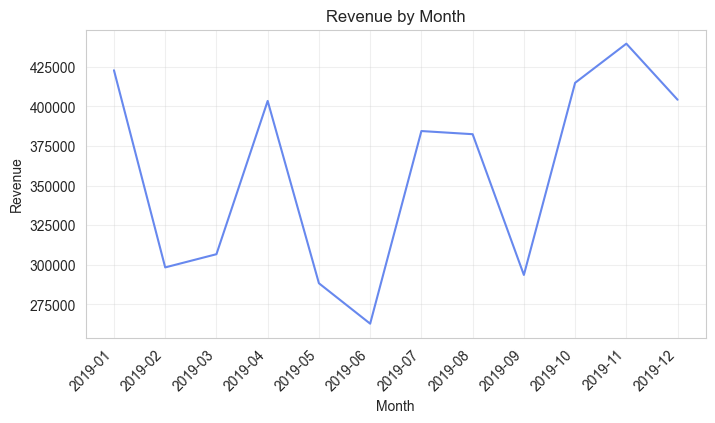

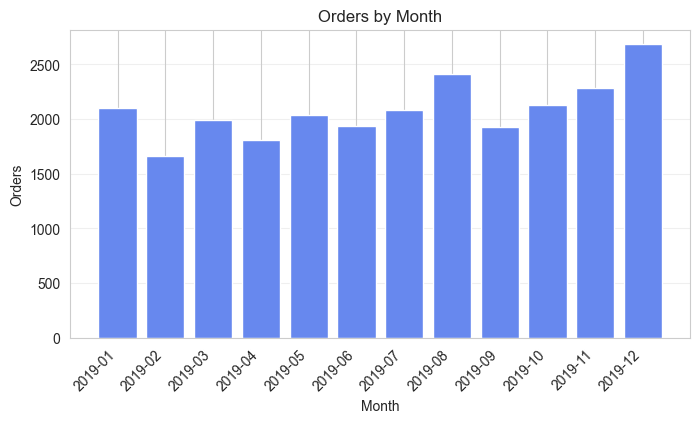

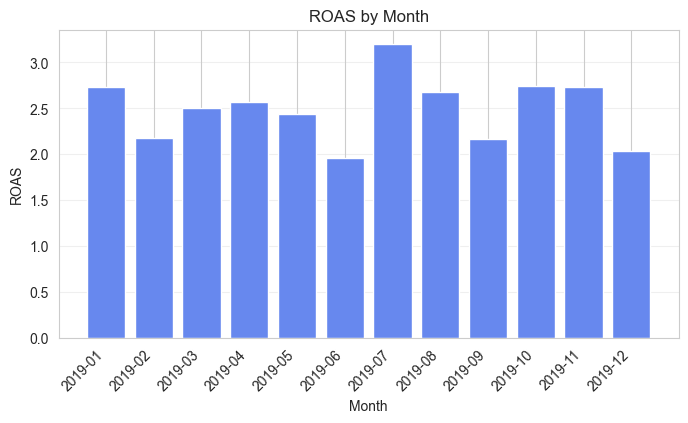

In [276]:

def _to_1d(values):
    # Accept Series/DataFrame/ndarray and return flat 1D array of strings or floats
    if isinstance(values, pd.DataFrame):
        values = values.iloc[:,0]
    if isinstance(values, pd.Series):
        return values.to_numpy()
    values = np.asarray(values)
    return values.ravel()

def line(x, y, title, xlabel, ylabel, rot=45, figsize=(8,4)):
    x_arr = _to_1d(x)
    y_arr = _to_1d(y).astype(float)
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(x_arr, y_arr)
    ax.set_title(title); ax.set_xlabel(xlabel); ax.set_ylabel(ylabel)
    ax.grid(True, alpha=0.3)
    if rot: plt.setp(ax.get_xticklabels(), rotation=rot, ha='right')
    plt.show()

def bar(x, y, title, xlabel, ylabel, rot=45, figsize=(8,4)):
    x_arr = _to_1d(x)
    y_arr = _to_1d(y).astype(float)
    fig, ax = plt.subplots(figsize=figsize)
    ax.bar(x_arr, y_arr)
    ax.set_title(title); ax.set_xlabel(xlabel); ax.set_ylabel(ylabel)
    ax.grid(True, axis='y', alpha=0.3)
    if rot: plt.setp(ax.get_xticklabels(), rotation=rot, ha='right')
    plt.show()

line(kpi['month_str'], kpi['total_revenue'], "Revenue by Month", "Month", "Revenue")
bar(kpi['month_str'], kpi['order_count'], "Orders by Month", "Month", "Orders")
bar(kpi['month_str'], kpi['ROAS'], "ROAS by Month", "Month", "ROAS")


# Adding to AWS cloud

In [ ]:
"""summary.to_sql('monthly_kpi_summary', engine, schema=my_schema, if_exists='replace', index=False)
overall_kpis.to_sql('overall_kpis', engine, schema=my_schema, if_exists='replace', index=False)
"""

# Download in .csv files

In [ ]:
"""
summary.to_csv('monthly_kpi_summary.csv', index=False)
overall_kpis.to_csv('overall_kpis.csv', index=False)
"""

In [109]:
# 1. Set up connection (update credentials and host!)

config = dotenv_values() 

# define variables for the login
pg_user = config['POSTGRES_USER']  # align the key label with your .env file !
pg_host = config['POSTGRES_HOST']
pg_port = config['POSTGRES_PORT']
pg_db = config['POSTGRES_DB']
pg_schema = config['POSTGRES_SCHEMA']
pg_pass = config['POSTGRES_PASS']

url = f'postgresql://{pg_user}:{pg_pass}@{pg_host}:{pg_port}/{pg_db}'

engine = create_engine(url, echo=False)


In [110]:
my_schema = "team_3"


mart_customers = pd.read_sql(f"SELECT * FROM {my_schema}.mart_customers;", engine)
mart_discount_coupon = pd.read_sql(f"SELECT * FROM {my_schema}.mart_discount_coupon;", engine)
mart_holidays_2019_us = pd.read_sql(f"SELECT * FROM {my_schema}.mart_holidays_2019_us;", engine)
mart_marketing_spend = pd.read_sql(f"SELECT * FROM {my_schema}.mart_marketing_spend;", engine)
mart_online_sales = pd.read_sql(f"SELECT * FROM {my_schema}.mart_online_sales;", engine)
mart_tax_amount = pd.read_sql(f"SELECT * FROM {my_schema}.mart_tax_amount;", engine)
mart_all_data = pd.read_sql(f"SELECT * FROM {my_schema}.mart_all_data;", engine)

1. CAC (Customer Acquisition Cost)

   CAC = Total Marketing Spend in Period / Number of New Customers Acquired in Same Period

In [111]:
print(mart_customers.columns)
print(mart_customers.head())

Index(['customer_id', 'gender', 'location', 'tenure_months'], dtype='object')
   customer_id gender    location  tenure_months
0        17850      M    Illinois             12
1        13047      M  California             43
2        12583      M    Illinois             33
3        13748      F  California             30
4        15100      M  California             49


In [112]:
print(mart_online_sales.columns)
print(mart_online_sales.head())

Index(['customer_id', 'transaction_id', 'transaction_date', 'produkt_sku', 'product_category', 'quantity', 'avg_price', 'delivery_charges', 'coupon_status',
       'revenue', 'transaction_month', 'transaction_month_str', 'transaction_day_of_month', 'transaction_day_of_week'],
      dtype='object')
   customer_id  transaction_id transaction_date     produkt_sku product_category  quantity  avg_price  delivery_charges coupon_status  revenue  \
0        17850           16679       2019-01-01  GGOENEBJ079499         Nest-USA         1     153.71               6.5          Used   160.21   
1        17850           16680       2019-01-01  GGOENEBJ079499         Nest-USA         1     153.71               6.5          Used   160.21   
2        17850           16681       2019-01-01  GGOEGFKQ020399           Office         1       2.05               6.5          Used     8.55   
3        17850           16682       2019-01-01  GGOEGAAB010516          Apparel         5      17.53               6

In [113]:
print(mart_marketing_spend.columns)
print(mart_marketing_spend.head())

Index(['date', 'offline_spend', 'online_spend'], dtype='object')
         date  offline_spend  online_spend
0  2019-01-01           4500       2424.50
1  2019-01-02           4500       3480.36
2  2019-01-03           4500       1576.38
3  2019-01-04           4500       2928.55
4  2019-01-05           4500       4055.30


In [114]:
print(mart_all_data.columns)
print(mart_marketing_spend.head())

Index(['transaction_date', 'transaction_id', 'customer_id', 'customer_gender', 'customer_location', 'customer_tenure_months', 'produkt_sku',
       'product_category', 'quantity', 'avg_price', 'delivery_charges', 'revenue', 'coupon_status', 'discount_pct', 'gst_onsale', 'daily_offline',
       'daily_online', 'transaction_month', 'transaction_month_str'],
      dtype='object')
         date  offline_spend  online_spend
0  2019-01-01           4500       2424.50
1  2019-01-02           4500       3480.36
2  2019-01-03           4500       1576.38
3  2019-01-04           4500       2928.55
4  2019-01-05           4500       4055.30


In [115]:

# Make sure transaction_date is datetime
mart_online_sales['transaction_date'] = pd.to_datetime(mart_online_sales['transaction_date'])

# Extract year and month as strings (ensures match with spend table)
mart_online_sales['transaction_year'] = mart_online_sales['transaction_date'].dt.year.astype(str)
mart_online_sales['transaction_month_num'] = mart_online_sales['transaction_date'].dt.month.astype(str).str.zfill(2)
mart_online_sales['signup_month_str'] = mart_online_sales['transaction_year'] + '-' + mart_online_sales['transaction_month_num']

# Find first purchase date (and month) for each customer
first_orders = mart_online_sales.groupby('customer_id')['transaction_date'].min().reset_index()
first_orders['signup_year'] = first_orders['transaction_date'].dt.year.astype(str)
first_orders['signup_month_num'] = first_orders['transaction_date'].dt.month.astype(str).str.zfill(2)
first_orders['signup_month_str'] = first_orders['signup_year'] + '-' + first_orders['signup_month_num']

In [116]:
#count new customers per month
new_customers = first_orders.groupby('signup_month_str')['customer_id'].nunique().reset_index(name='new_customers')

In [117]:
#monthly marketing spend
mart_marketing_spend['date'] = pd.to_datetime(mart_marketing_spend['date'])
mart_marketing_spend['month_str'] = mart_marketing_spend['date'].dt.strftime('%Y-%m')
mart_marketing_spend['total_spend'] = (
    mart_marketing_spend['offline_spend'].fillna(0) +
    mart_marketing_spend['online_spend'].fillna(0)
)
monthly_spend = (
    mart_marketing_spend
    .groupby('month_str')['total_spend']
    .sum()
    .reset_index()
)

In [118]:
#merge and calculate CAC

# Ensure key is 'month_str' in both DataFrames
cac = pd.merge(
    new_customers,
    monthly_spend,
    left_on='signup_month_str',
    right_on='month_str',
    how='inner'
)
cac['CAC'] = cac['total_spend'] / cac['new_customers']

print(cac[['signup_month_str', 'new_customers', 'total_spend', 'CAC']])

   signup_month_str  new_customers  total_spend          CAC
0           2019-01            215    154928.95   720.599767
1           2019-02             96    137107.92  1428.207500
2           2019-03            177    122250.09   690.678475
3           2019-04            163    157026.83   963.354785
4           2019-05            112    118259.64  1055.889643
5           2019-06            137    134318.14   980.424380
6           2019-07             94    120217.85  1278.913298
7           2019-08            135    142904.15  1058.549259
8           2019-09             78    135514.54  1737.365897
9           2019-10             87    151224.65  1738.214368
10          2019-11             68    161144.96  2369.778824
11          2019-12            106    198648.75  1874.044811


2. ROAS (Return on Ad Spend) 

ROAS = Total Revenue / Total Marketing Spend

In [119]:
# Ensure transaction_date is datetime
mart_all_data['transaction_date'] = pd.to_datetime(mart_all_data['transaction_date'])

# Create the proper 'YYYY-MM' string for each transaction
mart_all_data['transaction_month_str'] = mart_all_data['transaction_date'].dt.strftime('%Y-%m')

monthly_revenue = mart_all_data.groupby('transaction_month_str')['revenue'].sum().reset_index(name='total_revenue')
print(monthly_revenue)

   transaction_month_str  total_revenue
0                2019-01      462866.90
1                2019-02      360036.40
2                2019-03      410408.03
3                2019-04      443100.16
4                2019-05      349159.59
5                2019-06      358594.96
6                2019-07      421362.00
7                2019-08      462309.94
8                2019-09      401553.82
9                2019-10      455643.16
10               2019-11      541254.55
11               2019-12      561140.18


In [120]:
mart_marketing_spend['date'] = pd.to_datetime(mart_marketing_spend['date'])
mart_marketing_spend['month_str'] = mart_marketing_spend['date'].dt.strftime('%Y-%m')

In [121]:
roas = pd.merge(
    monthly_revenue,
    monthly_spend,
    left_on='transaction_month_str',
    right_on='month_str',
    how='inner'
)
roas['ROAS'] = roas['total_revenue'] / roas['total_spend']
print(roas[['transaction_month_str', 'total_revenue', 'total_spend', 'ROAS']])

   transaction_month_str  total_revenue  total_spend      ROAS
0                2019-01      462866.90    154928.95  2.987608
1                2019-02      360036.40    137107.92  2.625934
2                2019-03      410408.03    122250.09  3.357118
3                2019-04      443100.16    157026.83  2.821812
4                2019-05      349159.59    118259.64  2.952483
5                2019-06      358594.96    134318.14  2.669743
6                2019-07      421362.00    120217.85  3.504987
7                2019-08      462309.94    142904.15  3.235105
8                2019-09      401553.82    135514.54  2.963179
9                2019-10      455643.16    151224.65  3.013022
10               2019-11      541254.55    161144.96  3.358805
11               2019-12      561140.18    198648.75  2.824786


In [90]:
roas.head()

transaction_month_str  total_revenue month_str  total_spend      ROAS
0               2019-01      462866.90   2019-01    154928.95  2.987608
1               2019-02      360036.40   2019-02    137107.92  2.625934
2               2019-03      410408.03   2019-03    122250.09  3.357118
3               2019-04      443100.16   2019-04    157026.83  2.821812
4               2019-05      349159.59   2019-05    118259.64  2.952483

3. Retention rate

In [122]:
# 1. Orders: customer_id, transaction_date
orders = mart_all_data[['customer_id', 'transaction_date']].drop_duplicates()
orders['order_month'] = pd.to_datetime(orders['transaction_date']).dt.to_period('M')  # 'YYYY-MM'

# 2. First purchase month per customer
first_orders = (
    orders.groupby('customer_id')['order_month']
    .min()
    .reset_index(name='signup_month')
)

# 3. Merge for cohort tracking
cohort_data = orders.merge(first_orders, on='customer_id', how='left')

# 4. Count unique customers per cohort and order month
cohort_pivot = (
    cohort_data
    .groupby(['signup_month', 'order_month'])['customer_id']
    .nunique()
    .reset_index()
)


In [123]:
# 5. Pivot to get cohort matrix
cohort_matrix = cohort_pivot.pivot(index='signup_month', columns='order_month', values='customer_id').fillna(0)


In [124]:
# 6. New customers per cohort
new_customers = cohort_matrix.iloc[:, 0]


In [125]:
# 7. Calculate retention rate (%)
retention_rate = (
    cohort_matrix.divide(new_customers.replace(0, pd.NA), axis=0) * 100
).fillna(0).replace([float('inf'), -float('inf')], 0)

# 8. (Optional) Filter to cohorts with >0 new customers
retention_rate = retention_rate.loc[new_customers > 0]

print(retention_rate)

order_month   2019-01   2019-02    2019-03    2019-04    2019-05    2019-06   2019-07    2019-08    2019-09    2019-10   2019-11    2019-12
signup_month                                                                                                                               
2019-01         100.0  6.046512  11.162791  15.813953  10.697674  20.465116  16.27907  21.860465  10.697674  13.023256  9.302326  15.813953


4. AOV (AVerage order value)

AOV= Total Revenue/Number of Orders


In [126]:
monthly_orders = mart_all_data.groupby('transaction_month_str')['transaction_id'].nunique().reset_index(name='order_count')
monthly_revenue = mart_all_data.groupby('transaction_month_str')['revenue'].sum().reset_index(name='total_revenue')

monthly_aov = pd.merge(monthly_revenue, monthly_orders, on='transaction_month_str', how='inner')
monthly_aov['AOV'] = monthly_aov['total_revenue'] / monthly_aov['order_count']
print(monthly_aov[['transaction_month_str', 'AOV']])

   transaction_month_str         AOV
0                2019-01  220.203092
1                2019-02  216.368029
2                2019-03  206.131607
3                2019-04  244.401633
4                2019-05  171.661549
5                2019-06  184.842763
6                2019-07  202.577885
7                2019-08  191.511988
8                2019-09  207.843592
9                2019-10  214.420311
10               2019-11  237.184290
11               2019-12  209.068621


5. Repeat Purchase Rate

Repeat Purchase Rate= Number of Customers with >1 Order/ Total Number of Customers


In [127]:
repeat_customers = mart_all_data.groupby('customer_id')['transaction_id'].nunique().reset_index()
repeat_customers['is_repeat'] = repeat_customers['transaction_id'] > 1
repeat_rate = repeat_customers['is_repeat'].mean()
print(f"Repeat purchase rate: {repeat_rate:.2%}")

Repeat purchase rate: 91.49%


6. Churn rate

Churn Rate= Number of Customers with No Purchases for >6 Months/ Total Number of Customers

Approximation: 
Share of customers who haven’t purchased for at least 6 months, as a proxy for churn.

In [128]:
# Find last purchase date per customer
last_purchase = mart_all_data.groupby('customer_id')['transaction_date'].max().reset_index()
last_purchase['transaction_date'] = pd.to_datetime(last_purchase['transaction_date'])

reference_date = pd.to_datetime('2019-12-31')

# Calculate months since last purchase
last_purchase['months_since'] = ((reference_date - last_purchase['transaction_date']) / pd.Timedelta(days=30)).astype(int)

# Customers with >6 months inactivity are considered churned
churned = last_purchase[last_purchase['months_since'] > 6]

# Churn rate = churned customers / total unique customers
churn_rate = len(churned) / mart_all_data['customer_id'].nunique()

print(f"Churn rate (>6 months no purchase): {churn_rate:.2%}")

Churn rate (>6 months no purchase): 26.77%


7. LTV:CAC Ratio 

LTV = Total Revenue in period / Total Number of Customers acquired in period
CAC = Total Marketing Spend in period / Number of New Customers in period
LTV:CAC Ratio = LTV / CAC

In [129]:
ltv = mart_all_data.groupby('customer_id')['revenue'].sum().mean()  # Average revenue per customer

# Use your previously calculated CAC (from the 'cac' DataFrame)
avg_cac = cac['CAC'].mean()  # Average CAC, or use latest_cac = cac['CAC'].iloc[-1] for most recent

ltv_cac_ratio = ltv / avg_cac
print(f"LTV:CAC Ratio: {ltv_cac_ratio:.2f}")

LTV:CAC Ratio: 2.69


Benchmarks:

LTV:CAC > 1 → Your business is sustainable; each customer brings in more revenue than their acquisition cost.

LTV:CAC < 1 → You are overspending on customer acquisition.

8. ROAS online only

In [130]:
mart_all_data.head()

transaction_date  transaction_id  customer_id customer_gender customer_location  customer_tenure_months     produkt_sku product_category  quantity  \
0       2019-04-19           25990        15811               F          Illinois                      27  GGOEWCKQ085457      Accessories         1   
1       2019-04-07           25038        17999               F        New Jersey                      30  GGOEGBPB081999      Accessories         1   
2       2019-04-07           25038        17999               F        New Jersey                      30  GGOEGBPB082099      Accessories         1   
3       2019-04-28           26637        18116               F          Illinois                      38  GGOEGBPB081999      Accessories         1   
4       2019-08-02           34452        16889               F          Illinois                      23  GGOEGBPB081999      Accessories         1   

   avg_price  delivery_charges  revenue coupon_status  discount_pct  gst_onsale  daily_offline  daily_online  transaction_month transaction_month_str  
0      16.99               6.0    22.99       Clicked          10.0         0.1           4000       1754.92                4.0               2019-04  
1      49.99               6.5    56.49          Used          10.0         0.1           2500       2719.46                4.0               2019-04  
2      59.99               6.5    66.49       Clicked          10.0         0.1           2500       2719.46                4.0               2019-04  
3      39.99               6.0    45.99       Clicked          10.0         0.1           3500       2019.73                4.0               2019-04  
4      34.99               6.0    40.99          Used          20.0         0.1           1500       2155.96                8.0               2019-08

In [131]:
mart_all_data['daily_online'] = mart_all_data['daily_online'].fillna(0)
monthly_online_spend = mart_all_data.groupby('transaction_month_str')['daily_online'].sum().reset_index(name='online_spend')

In [132]:
mart_marketing_spend['online_spend'] = mart_marketing_spend['online_spend'].fillna(0)
monthly_online_spend = (
    mart_marketing_spend
    .groupby('month_str')['online_spend']
    .sum()
    .reset_index()
)

In [133]:
roas_online = pd.merge(
    monthly_revenue,
    monthly_online_spend,
    left_on='transaction_month_str',
    right_on='month_str',
    how='inner'
)
roas_online['roas_online'] = roas_online['total_revenue'] / roas_online['online_spend']

print(roas_online[['transaction_month_str', 'total_revenue', 'online_spend', 'roas_online']])

   transaction_month_str  total_revenue  online_spend  roas_online
0                2019-01      462866.90      58328.95     7.935457
1                2019-02      360036.40      55807.92     6.451350
2                2019-03      410408.03      48750.09     8.418611
3                2019-04      443100.16      61026.83     7.260744
4                2019-05      349159.59      52759.64     6.617930
5                2019-06      358594.96      53818.14     6.663087
6                2019-07      421362.00      52717.85     7.992777
7                2019-08      462309.94      57404.15     8.053598
8                2019-09      401553.82      52514.54     7.646526
9                2019-10      455643.16      57724.65     7.893390
10               2019-11      541254.55      68144.96     7.942694
11               2019-12      561140.18      76648.75     7.320931


# Step 6 — CLV / LTV Matrix
<a id="step-6-clv-ltv-matrix"></a>

CLV / LTV modeling (probabilistic)

Data prep: Transactions at customer-date level with monetary value = net_revenue.

Build lifetimes summary with
summary_data_from_transaction_data(...) → per-customer:

frequency (# repeat purchases), recency, T (customer “age” in the observation window), monetary_value (mean order value).

Fit BG/NBD on (frequency, recency, T) → expected number of future purchases.

Fit Gamma-Gamma on returning customers → expected average order value.

Predict horizon (e.g., 180 days / 6 months):

predicted_purchases_6m, predicted_avg_value, and predicted_ltv_6m = purchases × value.

Outputs:

Customer-level file Customer_LTV_Summary.csv (and a version with demographics).

Basic model sanity checks (distributions, decile lifts).

CLV matrix & segmentation

Robust, quantile-based segmentation on frequency and predicted_avg_value (ties handled; zero-freq adjusted) → 4×4 grid.

Pivot to average predicted_ltv_6m per (frequency_segment × value_segment).

Heatmap to highlight Champions (high-high), Potential Loyalists (low-high), etc.

Exports:

cltv_matrix.csv for Tableau

Customer_LTV_Summary_with_segments.csv (adds segments back to every customer).

In [134]:
ltv_final = pd.read_csv('../LTV-Capstone-Project/Customer_LTV_Summary.csv')

In [135]:
from lifetimes.utils import summary_data_from_transaction_data
from lifetimes import BetaGeoFitter, GammaGammaFitter

tx = mart_all[['customer_id','transaction_date','net_revenue']].copy()
summary = summary_data_from_transaction_data(
    tx, customer_id_col='customer_id', datetime_col='transaction_date',
    monetary_value_col='net_revenue',
    observation_period_end=tx['transaction_date'].max()
)

# Fit models (penalizer helps convergence)
bgf = BetaGeoFitter(penalizer_coef=0.001)
bgf.fit(summary['frequency'], summary['recency'], summary['T'])

# Only freq > 0 for Gamma-Gamma
ret = summary[summary['frequency'] > 0]
ggf = GammaGammaFitter(penalizer_coef=0.001)
ggf.fit(ret['frequency'], ret['monetary_value'])

# Predict 6 months (180 days)
summary['pred_purchases_180d'] = bgf.conditional_expected_number_of_purchases_up_to_time(
    180, summary['frequency'], summary['recency'], summary['T']
)
summary['pred_avg_value'] = ggf.conditional_expected_average_profit(
    summary['frequency'], summary['monetary_value']
)
summary['pred_ltv_180d'] = summary['pred_purchases_180d'] * summary['pred_avg_value']

summary[['pred_purchases_180d','pred_avg_value','pred_ltv_180d']].describe()

pred_purchases_180d  pred_avg_value  pred_ltv_180d
count          1468.000000     1468.000000    1468.000000
mean              0.707964      628.998855     634.116105
std               0.798352     1455.726697    1863.851209
min               0.000019     -107.309000    -119.286754
25%               0.290916     -107.309000     -39.219034
50%               0.447640      -45.210291     -11.273573
75%               0.847045      864.198524     561.711817
max              10.546758    20893.200741   34495.823692

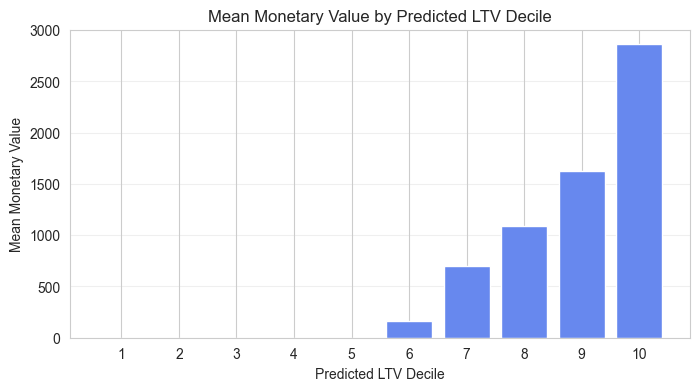

In [136]:

# Decile lift: sort by predicted LTV and check mean monetary value
tmp = summary.copy()
tmp = tmp.replace([np.inf, -np.inf], np.nan)
tmp = tmp.dropna(subset=['pred_ltv_180d'])
tmp['decile'] = pd.qcut(tmp['pred_ltv_180d'].rank(method='first'), 10, labels=False) + 1

dec = tmp.groupby('decile')['monetary_value'].mean().reset_index()
bar(dec['decile'].astype(str), dec['monetary_value'], "Mean Monetary Value by Predicted LTV Decile", "Predicted LTV Decile", "Mean Monetary Value", rot=0)

The Customer Lifetime Value (CLV) Matrix is a 2-dimensional segmentation tool that classifies customers based on:
1. Purchase Frequency (Horizontal axis) – How often a customer buys.
2. Average Monetary Value (Vertical axis) – How much a customer typically spends per purchase.
- By combining these two factors, the matrix helps visualize where your customers fall in terms of both loyalty and spending power, making it easier to:
- Identify high-value customers (both frequent and big spenders).
- Spot growth opportunities (frequent but low spenders or high spenders who rarely buy).
- Prioritize retention, upsell, and reactivation strategies.

How to interpete?

The CLV matrix gives a bird's-eye view of your customer base:
1. Top-right cell (High Frequency, High Value):
These are your "VIP customers" — they buy often and spend big. Protect and retain them.
2. Bottom-right cell (Low Frequency, High Value):
These are "Big Spenders at Risk" — they spend a lot but rarely return. Target them with retention campaigns.
3. Top-left cell (High Frequency, Low Value):
These are "Frequent but Low Spend" customers — consider cross-selling or upselling.
4. Bottom-left cell (Low Frequency, Low Value):
These are "Low-value, Infrequent Buyers" — lowest priority for retention.

Frequency Segments:
Frequency represents how many repeat transactions a customer has made during their observed lifecycle (in the dataset). Higher frequency segments represent loyal customers or heavy repeat purchasers, which usually indicates a higher likelihood of generating future value.
Customers are split into quantile-based segments based on their frequency value.
Example
pd.qcut(df['frequency_adjusted'], q=4, labels=['Freq_Seg1', 'Freq_Seg2', 'Freq_Seg3', 'Freq_Seg4'])

Frequency Segments:
Value represents the average monetary value per transaction predicted for each customer.
It reflects how much a customer tends to spend when they purchase.
Example
pd.qcut(df['predicted_avg_value'], q=4, labels=['Value_Seg1', 'Value_Seg2', 'Value_Seg3', 'Value_Seg4'])


Important! Dynamic segments calculation
Customer data distributions (frequency and value) are usually not uniform.
If the fixed bins are set manually ( 0–1, 2–5, 6+) one may get empty bins (no customers in some ranges)or fail to capture actual patterns in the data.Dynamic segmentation adjusts automatically based on the data distribution, ensuring:
- Each segment (quartile) contains roughly the same number of customers.
- The CLV Matrix remains meaningful even if the dataset changes (e.g., after new data loads).

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Copy dataset
df = ltv_final.copy()

# Optional: Remove outliers (top 1%)
df = df[df['predicted_LTV_6m'] < df['predicted_LTV_6m'].quantile(0.99)]

# Handle zero frequency
df['frequency_adjusted'] = df['frequency'].replace(0, 0.1)

# Create frequency segments dynamically
freq_bins = pd.qcut(df['frequency_adjusted'], q=4, duplicates='drop')
freq_labels = [f"Seg{i+1}" for i in range(freq_bins.cat.categories.size)]
df['frequency_segment'] = pd.qcut(df['frequency_adjusted'], q=4, labels=freq_labels, duplicates='drop')

# Create value segments dynamically
val_bins = pd.qcut(df['predicted_avg_value'], q=4, duplicates='drop')
val_labels = [f"Seg{i+1}" for i in range(val_bins.cat.categories.size)]
df['value_segment'] = pd.qcut(df['predicted_avg_value'], q=4, labels=val_labels, duplicates='drop')

# Create pivot table
cltv_matrix = df.pivot_table(
    index='frequency_segment',
    columns='value_segment',
    values='predicted_LTV_6m',
    aggfunc='mean'
)

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cltv_matrix, annot=True, fmt=".2f", cmap='YlGnBu')
plt.title('Customer Lifetime Value Matrix (6M Prediction)')
plt.xlabel('Predicted Average Value Segment')
plt.ylabel('Purchase Frequency Segment')
plt.show()

In [ ]:
ltv_final.head(2)

customer_id  frequency  recency      T  monetary_value  predicted_purchases_6m  predicted_avg_value  predicted_ltv_6m gender  location  tenure_months
0        12346        0.0      0.0  107.0           0.000                0.486163          1265.594052        615.284554      F  New York             31
1        12347        2.0    223.0  282.0        1163.375                0.867946          1240.987166       1077.109890      M  New York             20

|                    | **Low Value**    | **Medium Value**   | **High Value**         |
| ------------------ | ---------------- | ------------------ | ---------------------- |
| **Low Frequency**  | **At-Risk Low**  | **At-Risk Mid**    | **Potential Loyalist** |
| **High Frequency** | **Frequent Low** | **Core Customers** | **Champions**          |

1. Champions – High spend & high frequency → most valuable, loyal customers.
2. Core Customers – Moderate spend but frequent → stable revenue drivers.
3. Potential Loyalist – High value but low frequency → big spenders who could be nurtured to buy more 4. often.
5. Frequent Low – Low spend but frequent → could be upsold to increase value.
6. At-Risk Mid/Low – Infrequent buyers with low to moderate spend → lowest priority for retention efforts.



CLTV matrix exported to cltv_matrix.csv


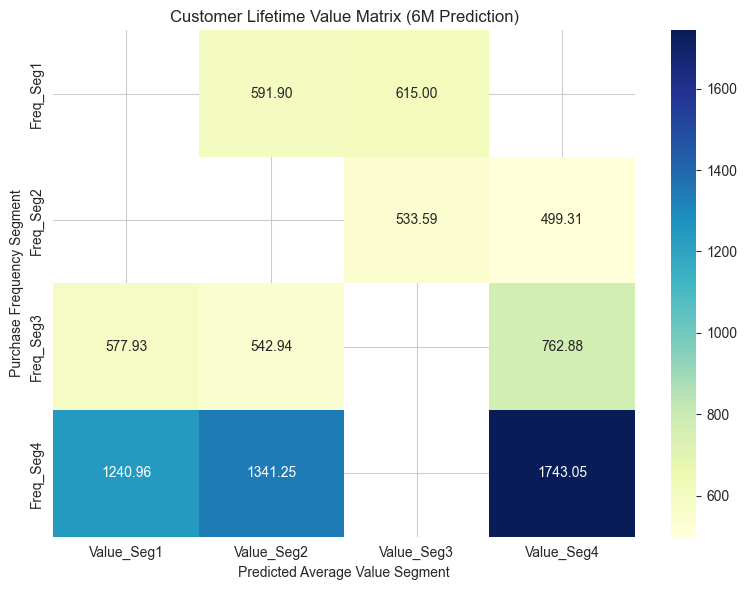

value_segment      Value_Seg1  Value_Seg2  Value_Seg3  Value_Seg4
frequency_segment                                                
Freq_Seg1                 NaN      591.90      615.00         NaN
Freq_Seg2                 NaN         NaN      533.59      499.31
Freq_Seg3              577.93      542.94         NaN      762.88
Freq_Seg4             1240.96     1341.25         NaN     1743.05


In [309]:
# Create a pivot table to transfer data to Tableau for visualization (frequency segment x value segment)

def generate_cltv_matrix(
    df,
    quantiles=4,
    cap_outliers=True,
    export_csv=False,
    file_name="cltv_matrix.csv"
):
    """
    Build a CLTV matrix (frequency segment x value segment) from `df`
    using columns:
      - predicted_ltv_6m
      - frequency
      - predicted_avg_value
    """

    # ---- 0) column sanity ----
    required = ["predicted_ltv_6m", "frequency", "predicted_avg_value"]
    missing = [c for c in required if c not in df.columns]
    if missing:
        raise KeyError(f"Missing columns: {missing}. Available: {list(df.columns)}")

    data = df.copy()

    # ---- 1) numeric + NA cleanup ----
    for c in required:
        data[c] = pd.to_numeric(data[c], errors="coerce")
    data = data.dropna(subset=required)

    # ---- 2) cap extreme LTV outliers (optional) ----
    if cap_outliers and len(data) >= 50:
        q99 = data["predicted_ltv_6m"].quantile(0.99)
        data = data[data["predicted_ltv_6m"] < q99]

    # ---- 3) handle zero frequency to avoid collapsed quantiles ----
    data["frequency_adjusted"] = data["frequency"].replace(0, 0.1)

    # ---- helper for robust quantile segmentation ----
    def make_segments(series, q=4, prefix="Seg"):
        # rank to smooth ties, then qcut; shrink q if too few uniques
        r = series.rank(method="first", pct=True)
        bins = min(q, max(1, r.nunique()))
        if bins < 2:
            labels = [f"{prefix}1"]
            return pd.Series([labels[0]] * len(r), index=r.index, dtype="object"), labels
        labels = [f"{prefix}{i+1}" for i in range(bins)]
        seg = pd.qcut(r, q=bins, labels=labels, duplicates="drop")
        return seg, list(seg.cat.categories)

    # ---- 4) frequency & value segments ----
    data["frequency_segment"], f_labels = make_segments(
        data["frequency_adjusted"], q=quantiles, prefix="Freq_Seg"
    )
    data["value_segment"], v_labels = make_segments(
        data["predicted_avg_value"], q=quantiles, prefix="Value_Seg"
    )

    # enforce ordered categories for consistent pivot/plot order
    data["frequency_segment"] = data["frequency_segment"].astype(
        pd.CategoricalDtype(categories=f_labels, ordered=True)
    )
    data["value_segment"] = data["value_segment"].astype(
        pd.CategoricalDtype(categories=v_labels, ordered=True)
    )

    # ---- 5) pivot: mean LTV per segment pair ----
    cltv_matrix = (
        data.pivot_table(
            index="frequency_segment",
            columns="value_segment",
            values="predicted_ltv_6m",
            aggfunc="mean"
        )
        .reindex(index=f_labels, columns=v_labels)
        .round(2)
    )

    # ---- 6) optional export for Tableau ----
    if export_csv:
        cltv_matrix.reset_index().to_csv(file_name, index=False)
        print(f"CLTV matrix exported to {file_name}")

    # ---- 7) heatmap ----
    plt.figure(figsize=(8, 6))
    sns.heatmap(cltv_matrix, annot=True, fmt=".2f", cmap="YlGnBu")
    plt.title("Customer Lifetime Value Matrix (6M Prediction)")
    plt.xlabel("Predicted Average Value Segment")
    plt.ylabel("Purchase Frequency Segment")
    plt.tight_layout()
    plt.show()

    return cltv_matrix

# ---- USAGE ----
cltv_matrix = generate_cltv_matrix(ltv_final, quantiles=4, export_csv=True)
print(cltv_matrix.head())

In [139]:
def add_customer_segments(df, quantiles=4, id_col="customer_id", cap_outliers=True):
    """
    Adds frequency/value quantile segments to the original dataframe (by customer_id).
    Uses columns:
      - predicted_ltv_6m
      - frequency
      - predicted_avg_value
    """
    required = [id_col, "predicted_ltv_6m", "frequency", "predicted_avg_value"]
    missing = [c for c in required if c not in df.columns]
    if missing:
        raise KeyError(f"Missing required columns: {missing}. Available: {list(df.columns)}")

    # Work on a minimal subset
    data = df[required].copy()

    # Numeric cleanup
    for c in ["predicted_ltv_6m", "frequency", "predicted_avg_value"]:
        data[c] = pd.to_numeric(data[c], errors="coerce")
    data = data.dropna(subset=["predicted_ltv_6m", "frequency", "predicted_avg_value"])

    # Optional: cap outliers for segmentation set only
    if cap_outliers and len(data) >= 50:
        cap_value = data["predicted_ltv_6m"].quantile(0.99)
        data = data[data["predicted_ltv_6m"] < cap_value]

    # Avoid zero-frequency collapsing quantiles
    data["frequency_adjusted"] = data["frequency"].replace(0, 0.1)

    # Robust segmenter that handles ties/low-unique values
    def make_segments(series, q=4, prefix="Seg"):
        r = series.rank(method="first", pct=True)  # smooth ties
        bins = min(q, max(1, r.nunique()))
        if bins < 2:
            labels = [f"{prefix}1"]
            return pd.Series([labels[0]] * len(r), index=r.index, dtype="object"), labels
        labels = [f"{prefix}{i+1}" for i in range(bins)]
        seg = pd.qcut(r, q=bins, labels=labels, duplicates="drop")
        return seg, list(seg.cat.categories)

    # Build segments on the (possibly outlier-trimmed) set
    data["frequency_segment"], f_labels = make_segments(
        data["frequency_adjusted"], q=quantiles, prefix="Freq_Seg"
    )
    data["value_segment"], v_labels = make_segments(
        data["predicted_avg_value"], q=quantiles, prefix="Value_Seg"
    )

    # Keep only the id + segments to merge back
    segments = data[[id_col, "frequency_segment", "value_segment"]]

    # Merge back to original df so ALL customers are retained
    merged_df = df.merge(segments, on=id_col, how="left")

    return merged_df


# Load your original dataframe
ltv_final = pd.read_csv("../LTV-Capstone-Project/Customer_LTV_Summary.csv")

# Add segments (4-quantiles by default)
ltv_final_with_segments = add_customer_segments(ltv_final, quantiles=4, id_col="customer_id", cap_outliers=True)

# Save for Tableau
ltv_final_with_segments.to_csv(
    "../LTV-Capstone-Project/Customer_LTV_Summary_with_segments.csv", index=False
)

print(ltv_final_with_segments.head())

   customer_id  frequency  recency      T  monetary_value  predicted_purchases_6m  predicted_avg_value  predicted_ltv_6m gender    location  tenure_months  \
0        12346        0.0      0.0  107.0           0.000                0.486163          1265.594052        615.284554      F    New York             31   
1        12347        2.0    223.0  282.0        1163.375                0.867946          1240.987166       1077.109890      M    New York             20   
2        12348        1.0    119.0  192.0         693.731                0.577773          1187.344186        686.015648      M  California             39   
3        12350        0.0      0.0   17.0           0.000                0.914834          1265.594052       1157.807941      M  California             25   
4        12356        0.0      0.0  107.0           0.000                0.486163          1265.594052        615.284554      F    Illinois             31   

  frequency_segment value_segment  
0         Freq_

In [140]:
ltv_final_with_segments.head(2)

customer_id  frequency  recency      T  monetary_value  predicted_purchases_6m  predicted_avg_value  predicted_ltv_6m gender  location  tenure_months  \
0        12346        0.0      0.0  107.0           0.000                0.486163          1265.594052        615.284554      F  New York             31   
1        12347        2.0    223.0  282.0        1163.375                0.867946          1240.987166       1077.109890      M  New York             20   

  frequency_segment value_segment  
0         Freq_Seg1    Value_Seg2  
1         Freq_Seg4    Value_Seg2

# Step 7 — Cohort Analysis

<a id='step-7-cohort-analysis'></a>

Key fields:

signup_month = first purchase month (per customer).

cohort_index = months since signup (0,1,2,…).

Matrices & charts:

Retention matrix (% of original cohort active each month).

Cohort revenue (total), cumulative LTV (avg revenue per original member over time).

Revenue per retained customer (spend only among those active).

Visuals: heatmaps (retention / cumulative LTV / revenue per retained),
stacked area (cohort revenue share), and line comparisons across cohorts.

Segmented cohorts:

By gender and by AOV quartile (Low, Med-Low, Med-High, High) with the same matrices and overlays to see differential retention and spend dynamics across segments.

In [142]:
mart_all_data = pd.read_csv('../LTV-Capstone-Project/mart_all_data.csv')
mart_all_data.head(2)

customer_id customer_gender customer_location  customer_tenure_months  transaction_id transaction_date     produkt_sku product_category  quantity  \
0        15811               F          Illinois                      27           25990       2019-04-19  GGOEWCKQ085457      Accessories         1   
1        17999               F        New Jersey                      30           25038       2019-04-07  GGOEGBPB081999      Accessories         1   

   avg_price  delivery_charges coupon_status  discount_pct  gst_onsale  offline_spend_that_day  online_spend_that_day  transaction_year  transaction_month  \
0      16.99               6.0       Clicked          10.0         0.1                    4000                1754.92            2019.0                4.0   
1      49.99               6.5          Used          10.0         0.1                    2500                2719.46            2019.0                4.0   

  transaction_month_str  transaction_day_of_month transaction_day_of_week  
0                   apr                      19.0                  friday  
1                   apr                       7.0                  sunday

In [144]:
mart_all_data.columns

Index(['customer_id', 'customer_gender', 'customer_location', 'customer_tenure_months', 'transaction_id', 'transaction_date', 'produkt_sku',
       'product_category', 'quantity', 'avg_price', 'delivery_charges', 'coupon_status', 'discount_pct', 'gst_onsale', 'offline_spend_that_day',
       'online_spend_that_day', 'transaction_year', 'transaction_month', 'transaction_month_str', 'transaction_day_of_month', 'transaction_day_of_week'],
      dtype='object')

In [145]:
# Convert transaction date to datetime
mart_all_data['transaction_date'] = pd.to_datetime(mart_all_data['transaction_date'])

# Extract cohort month (first transaction month of each customer)
mart_all_data['cohort_month'] = (
    mart_all_data.groupby('customer_id')['transaction_date']
    .transform('min')
    .dt.to_period('M')
)

# Extract transaction month for each purchase
mart_all_data['txn_month'] = mart_all_data['transaction_date'].dt.to_period('M')

# Calculate cohort index (0 = first month for that cohort)
mart_all_data['cohort_index'] = (
    (mart_all_data['txn_month'].dt.year - mart_all_data['cohort_month'].dt.year) * 12
    + (mart_all_data['txn_month'].dt.month - mart_all_data['cohort_month'].dt.month)
)

# Aggregate: Number of unique customers per cohort per month
cohort_data = (
    mart_all_data.groupby(['cohort_month', 'cohort_index'])['customer_id']
    .nunique()
    .reset_index()
)

In [146]:
# Find the size of each cohort at index 0
cohort_sizes = cohort_data[cohort_data['cohort_index'] == 0][['cohort_month','customer_id']]
cohort_sizes = cohort_sizes.rename(columns={'customer_id':'cohort_size'})

# Merge sizes back
cohort_data = cohort_data.merge(cohort_sizes, on='cohort_month')
cohort_data['retention'] = cohort_data['customer_id'] / cohort_data['cohort_size']

In [147]:
cohort_pivot = cohort_data.pivot_table(
    index='cohort_index',
    columns='cohort_month',
    values='retention'
)

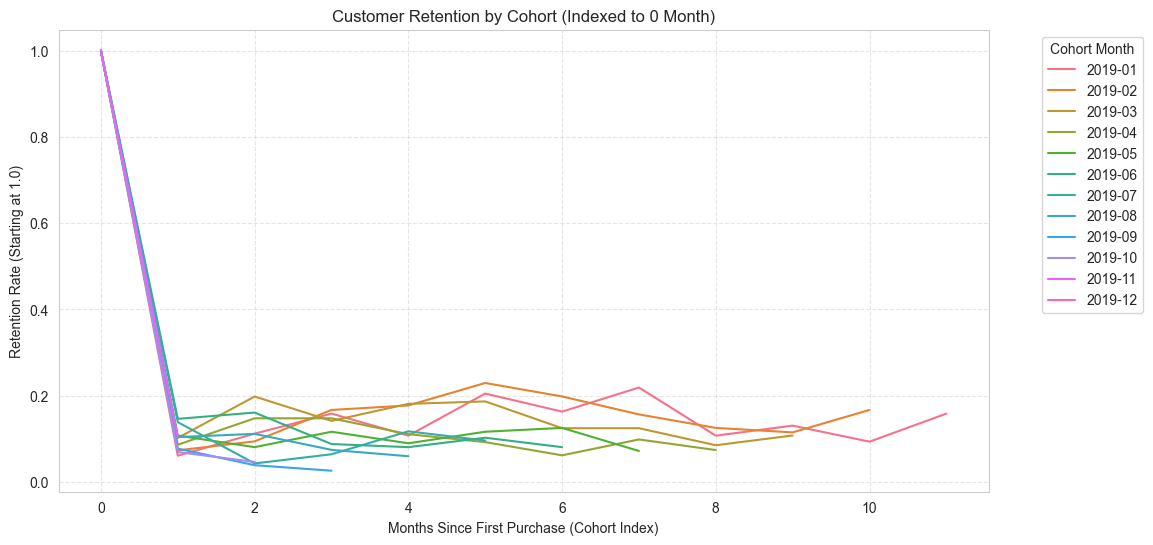

In [148]:
plt.figure(figsize=(12,6))
sns.lineplot(data=cohort_pivot, dashes=False)

plt.title('Customer Retention by Cohort (Indexed to 0 Month)')
plt.xlabel('Months Since First Purchase (Cohort Index)')
plt.ylabel('Retention Rate (Starting at 1.0)')
plt.legend(title='Cohort Month', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [149]:
# Cohort revenue

# Net Revenue
mart_all_data['gross_revenue'] = mart_all_data['quantity'] * mart_all_data['avg_price']

# Apply discount if present
mart_all_data['discount_amount'] = mart_all_data['gross_revenue'] * (mart_all_data['discount_pct'] / 100)

# Net revenue after discount and adding delivery & taxes
mart_all_data['transaction_amount'] = (
    mart_all_data['gross_revenue']
    - mart_all_data['discount_amount']
    + mart_all_data['delivery_charges']
    + mart_all_data['gst_onsale']
)


In [151]:
# Split Revenue by Coupon Usage
cohort_revenue_coupon = (
    mart_all_data.groupby(['cohort_month', 'coupon_status', 'cohort_index'])
    .agg(
        total_revenue=('transaction_amount', 'sum'),
        customers=('customer_id', 'nunique')
    )
    .reset_index()
)

cohort_revenue_coupon['ARPU'] = (
    cohort_revenue_coupon['total_revenue'] / cohort_revenue_coupon['customers']
)

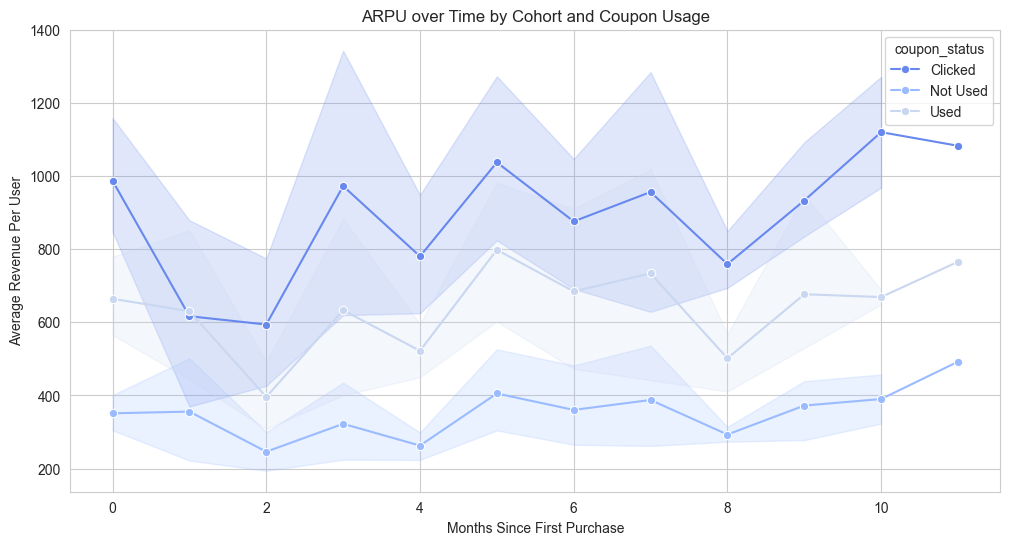

In [152]:

plt.figure(figsize=(12,6))
sns.lineplot(
    data=cohort_revenue_coupon,
    x='cohort_index',
    y='ARPU',
    hue='coupon_status',
    marker='o'
)
plt.title('ARPU over Time by Cohort and Coupon Usage')
plt.xlabel('Months Since First Purchase')
plt.ylabel('Average Revenue Per User')
plt.show()

Note
Seaborn computes the mean ARPU per cohort index for each coupon_status and then estimates a confidence interval (by default 95%). The shaded area aound the line in the graph above is statistical uncertainty around the mean value.



In [153]:
# Purchase frequency per cohort

purchase_frequency = (
    mart_all_data.groupby(['cohort_month', 'cohort_index'])
    .agg(
        total_txns=('transaction_id', 'count'),
        customers=('customer_id', 'nunique')
    )
    .reset_index()
)
purchase_frequency['avg_txn_per_user'] = purchase_frequency['total_txns'] / purchase_frequency['customers']

Line Chart below shows how often each cohort continues purchasing over time.

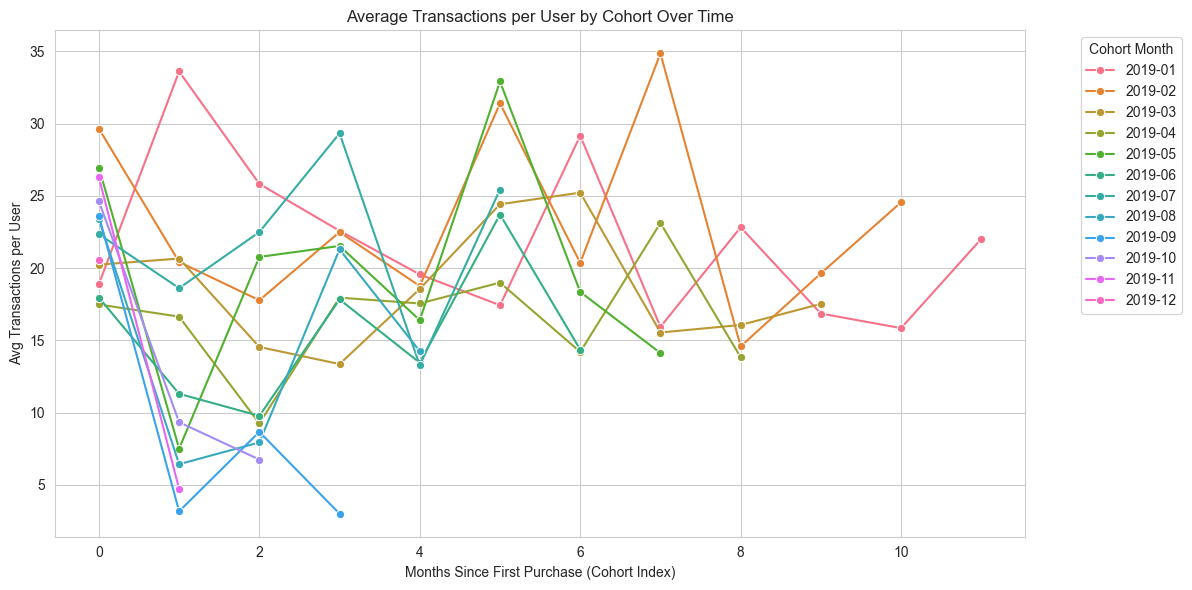

In [154]:
# Line Chart – Avg Transactions per User
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=purchase_frequency,
    x='cohort_index',
    y='avg_txn_per_user',
    hue='cohort_month',
    marker='o'
)
plt.title('Average Transactions per User by Cohort Over Time')
plt.xlabel('Months Since First Purchase (Cohort Index)')
plt.ylabel('Avg Transactions per User')
plt.legend(title='Cohort Month', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Heatmap of Cohorts vs Months helps to see the patterns across cohorts (e.g., if some cohorts are more engaged). The Graph quickly shows which cohorts have higher activity (darker color) in specific months.

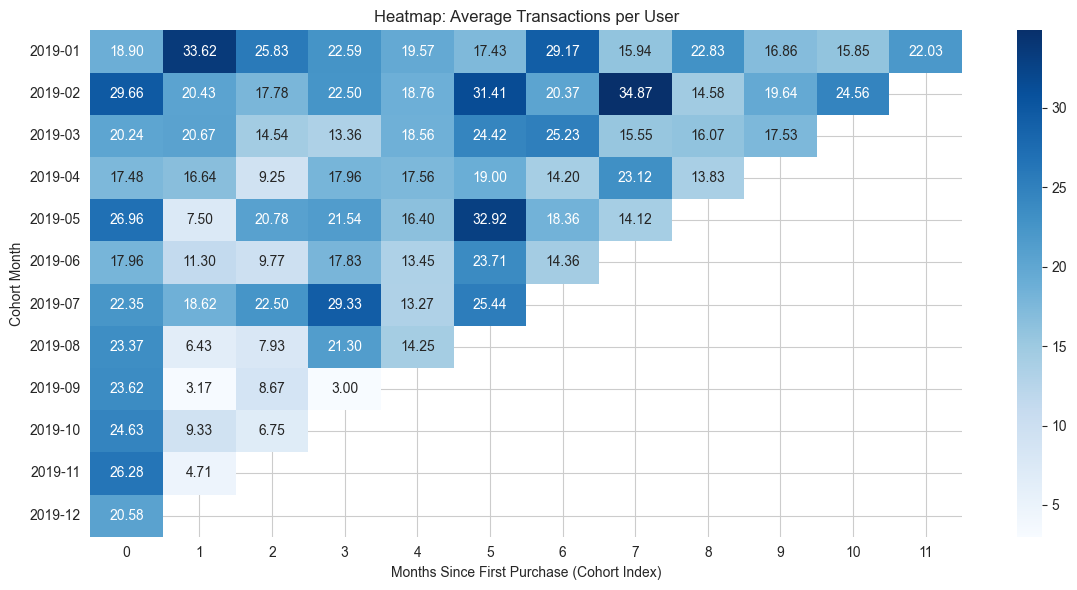

In [155]:
# Heatmap – Cohorts vs Months
# Pivot table for heatmap
pivot_freq = purchase_frequency.pivot(
    index='cohort_month',
    columns='cohort_index',
    values='avg_txn_per_user'
)

plt.figure(figsize=(12, 6))
sns.heatmap(pivot_freq, annot=True, fmt=".2f", cmap='Blues')
plt.title('Heatmap: Average Transactions per User')
plt.xlabel('Months Since First Purchase (Cohort Index)')
plt.ylabel('Cohort Month')
plt.tight_layout()
plt.show()

In [156]:
#  Cohort Contribution to Total Revenue
monthly_revenue = mart_all_data.groupby(['txn_month', 'cohort_month'])['transaction_amount'].sum().reset_index()

total_monthly = monthly_revenue.groupby('txn_month')['transaction_amount'].transform('sum')
monthly_revenue['cohort_share'] = monthly_revenue['transaction_amount'] / total_monthly

Stacked diagram below is used to represet a contribution of each cohort to the total revenue. Each color represents a customer acquisition cohort (month of first purchase).The stacked area chart shows how earlier cohorts decline (churn) and how new cohorts contribute revenue over time. If older cohorts retain a larger share, their band thickness stays consistent.

<Figure size 1200x600 with 0 Axes>

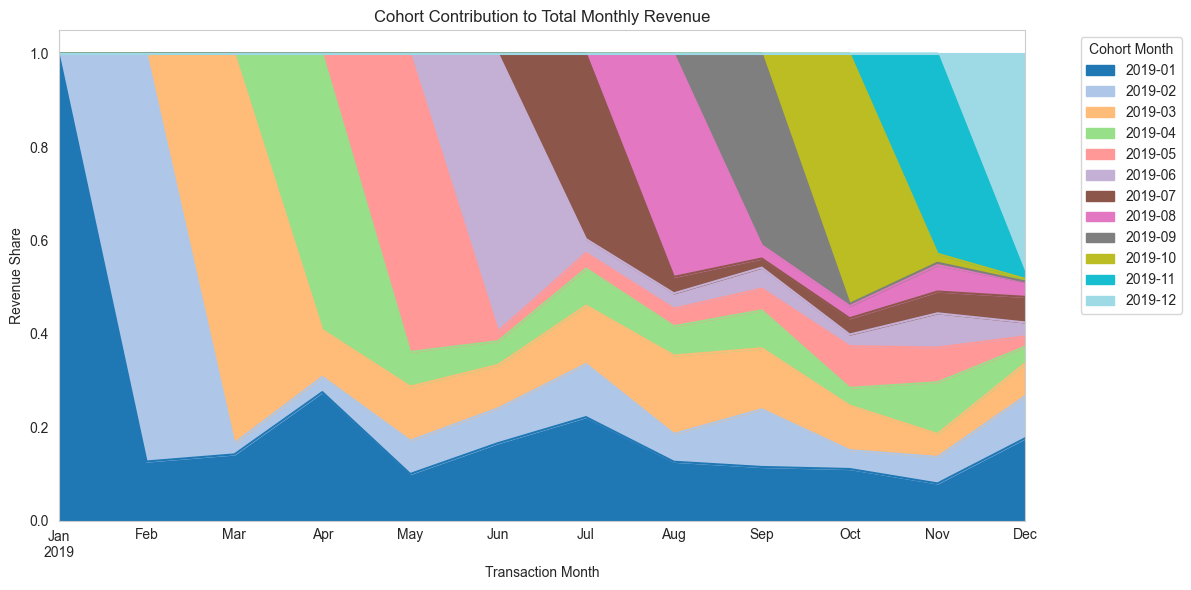

In [157]:
# Pivot data to have cohorts as columns
pivot_share = monthly_revenue.pivot(index='txn_month', columns='cohort_month', values='cohort_share')

plt.figure(figsize=(12, 6))
pivot_share.plot(kind='area', stacked=True, figsize=(12,6), colormap='tab20')

plt.title('Cohort Contribution to Total Monthly Revenue')
plt.xlabel('Transaction Month')
plt.ylabel('Revenue Share')
plt.legend(title='Cohort Month', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

An alternative representation with a barchart.

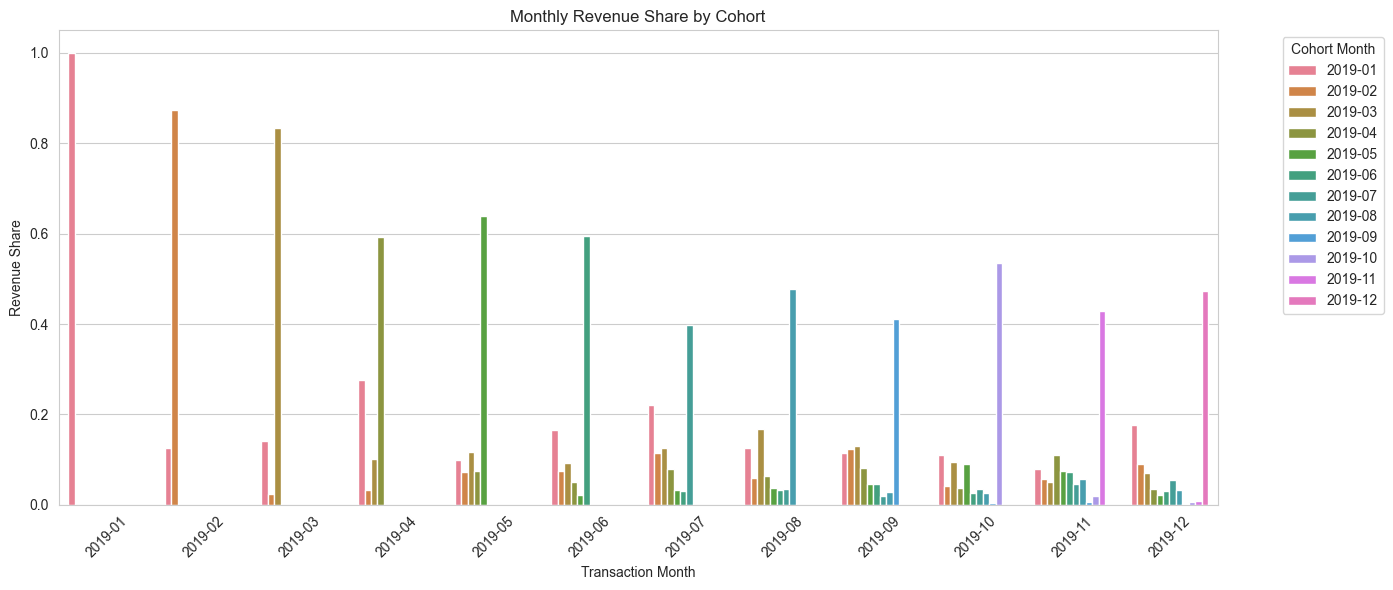

In [158]:
plt.figure(figsize=(14, 6))
sns.barplot(
    data=monthly_revenue,
    x='txn_month',
    y='cohort_share',
    hue='cohort_month'
)
plt.title('Monthly Revenue Share by Cohort')
plt.xlabel('Transaction Month')
plt.ylabel('Revenue Share')
plt.legend(title='Cohort Month', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [159]:
#  Cohort Profitability (Net Revenue – Discounts)
mart_all_data['discount_cost'] = mart_all_data['gross_revenue'] * (mart_all_data['discount_pct'] / 100)

cohort_profit = (
    mart_all_data.groupby(['cohort_month', 'cohort_index'])
    .agg(
        net_revenue=('transaction_amount', 'sum'),
        total_discount=('discount_cost', 'sum')
    )
    .reset_index()
)

cohort_profit['profit_margin'] = (
    (cohort_profit['net_revenue'] - cohort_profit['total_discount']) / cohort_profit['net_revenue']
)

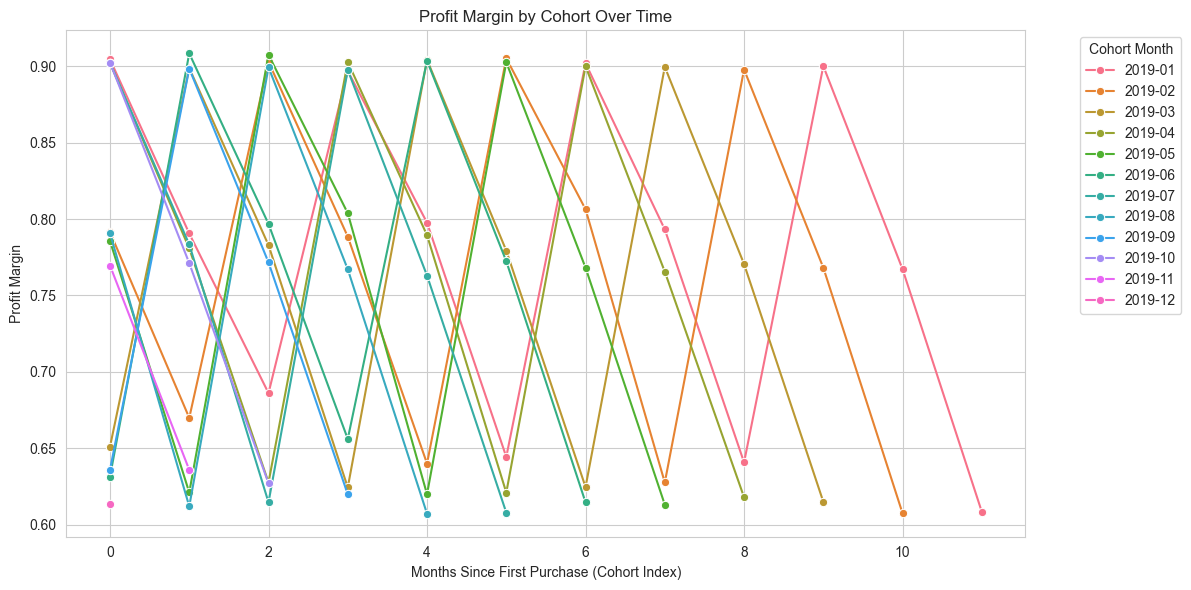

In [160]:
#  Line Chart – Profit Margin Trend Over Time shows if some cohorts have increasing or decreasing profitability over time

plt.figure(figsize=(12, 6))
sns.lineplot(
    data=cohort_profit,
    x='cohort_index',
    y='profit_margin',
    hue='cohort_month',
    marker='o'
)
plt.title('Profit Margin by Cohort Over Time')
plt.xlabel('Months Since First Purchase (Cohort Index)')
plt.ylabel('Profit Margin')
plt.legend(title='Cohort Month', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

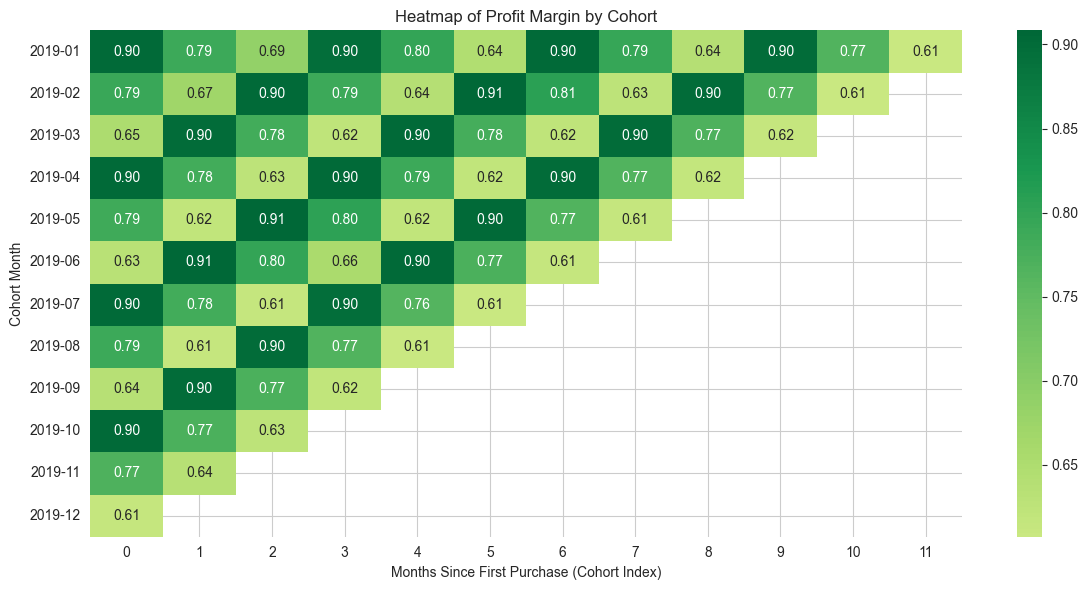

In [161]:
# Pivot data for heatmap helps to identify high or low profit cohorts at a glance (green = high margin, red = low).
pivot_profit = cohort_profit.pivot(
    index='cohort_month',
    columns='cohort_index',
    values='profit_margin'
)

plt.figure(figsize=(12, 6))
sns.heatmap(pivot_profit, annot=True, fmt=".2f", cmap='RdYlGn', center=0.5)
plt.title('Heatmap of Profit Margin by Cohort')
plt.xlabel('Months Since First Purchase (Cohort Index)')
plt.ylabel('Cohort Month')
plt.tight_layout()
plt.show()

In [162]:
#  Customer Segmentation Within Cohorts by Gender
segmented = mart_all_data.groupby(['cohort_month', 'customer_gender', 'cohort_index'])['customer_id'].nunique().reset_index()

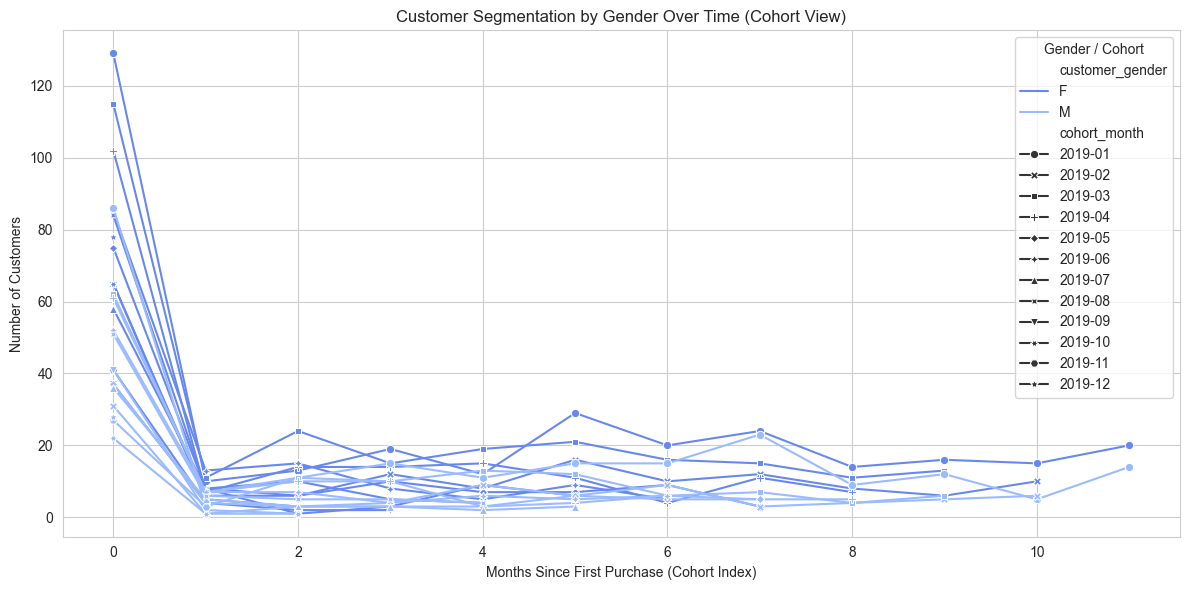

In [163]:
# Grouped Line Chart (Trend of Customer Count per Gender in Each Cohort) 
# shows how the number of customers evolves over time for each gender within each cohort.

plt.figure(figsize=(12, 6))
sns.lineplot(
    data=segmented,
    x='cohort_index',
    y='customer_id',
    hue='customer_gender',
    style='cohort_month',
    markers=True,
    dashes=False
)
plt.title('Customer Segmentation by Gender Over Time (Cohort View)')
plt.xlabel('Months Since First Purchase (Cohort Index)')
plt.ylabel('Number of Customers')
plt.legend(title='Gender / Cohort')
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

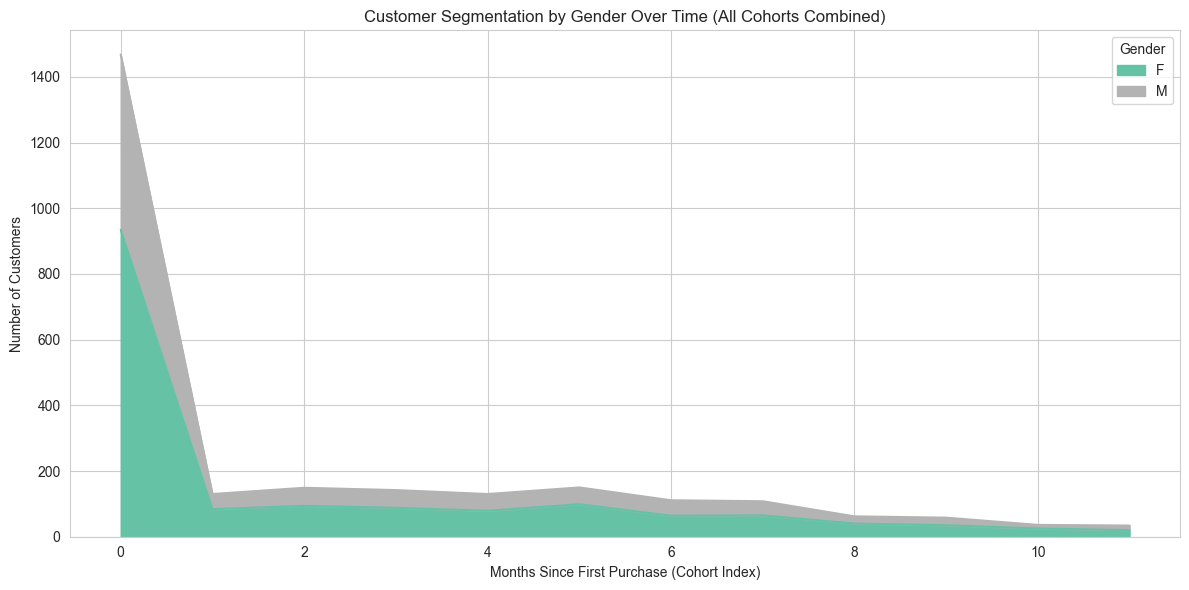

In [164]:
# Share of genders in purchases or activity by month. 
# Pivot data for stacked area
pivot_segment = segmented.pivot_table(
    index=['cohort_index'],
    columns='customer_gender',
    values='customer_id',
    aggfunc='sum',
    fill_value=0
)

plt.figure(figsize=(12, 6))
pivot_segment.plot(kind='area', stacked=True, cmap='Set2', figsize=(12,6))
plt.title('Customer Segmentation by Gender Over Time (All Cohorts Combined)')
plt.xlabel('Months Since First Purchase (Cohort Index)')
plt.ylabel('Number of Customers')
plt.legend(title='Gender')
plt.tight_layout()
plt.show()

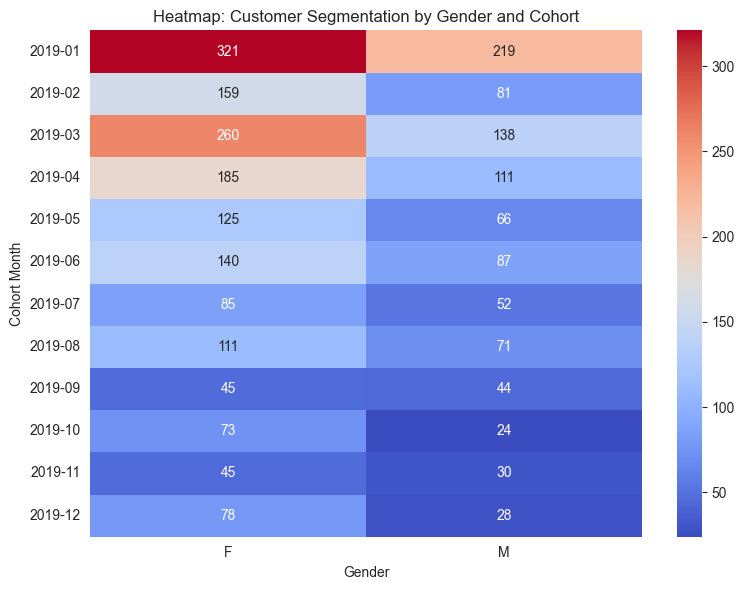

In [165]:
# The Heatmap shows if some certain cohorts are more skewed towards one gender.
# A matrix view helps to understand which cohorts have more of a specific gender.
pivot_heatmap = segmented.pivot_table(
    index='cohort_month',
    columns='customer_gender',
    values='customer_id',
    aggfunc='sum',
    fill_value=0
)

plt.figure(figsize=(8, 6))
sns.heatmap(pivot_heatmap, annot=True, fmt="d", cmap="coolwarm")
plt.title('Heatmap: Customer Segmentation by Gender and Cohort')
plt.xlabel('Gender')
plt.ylabel('Cohort Month')
plt.tight_layout()
plt.show()

In [ ]:
#!pip install lifelines
#Lifelines package is used for survival analysis and customer lifetime modeling.

Survival / time-to-churn (Kaplan-Meier)

Build lifespan per customer = last_purchase − first_purchase (days).

Event flag: treated as churned if last_purchase < observation_end (right-censoring simplified).

KM survival curve: probability a customer is still “alive” (active) after X days.

Variant: exclude one-time buyers to focus on true repeat behavior (median survival increases).

Split-KM: coupon users vs non-users → compare survival curves and median survival times.
In your run, coupon users showed longer survival → actionable for promo strategy.

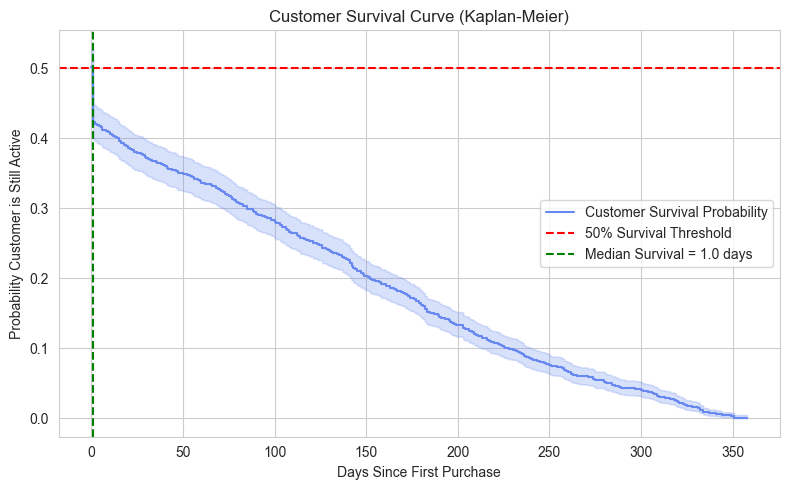

In [166]:
#  Time to Churn / Survival Analysis

# The KaplanMeierFitter (KMF) is a class from Python's lifelines library used in survival analysis to estimate the survival function from lifetime data. 
# It's a non-parametric estimator, meaning it doesn't assume a particular probability distribution for survival times.

# Calculate observation end date
observation_end = mart_all_data['transaction_date'].max()

# Compute customer lifespan
customer_lifespan = (
    mart_all_data.groupby('customer_id')
    .agg(
        first_purchase=('transaction_date', 'min'),
        last_purchase=('transaction_date', 'max')
    )
)

# Duration in days
customer_lifespan['lifespan_days'] = (
    customer_lifespan['last_purchase'] - customer_lifespan['first_purchase']
).dt.days

# Event observed: 1 if churned (last purchase < observation_end), else 0 (right-censored)
customer_lifespan['event_observed'] = (
    customer_lifespan['last_purchase'] < observation_end
).astype(int)

# Fit Kaplan-Meier model
kmf = KaplanMeierFitter()
kmf.fit(
    durations=customer_lifespan['lifespan_days'],
    event_observed=customer_lifespan['event_observed'],
    label='Customer Survival Probability'
)

# Get median survival time
median_survival = kmf.median_survival_time_

# Plot survival function
plt.figure(figsize=(8, 5))
kmf.plot_survival_function(ci_show=True)
plt.axhline(0.5, color='red', linestyle='--', label='50% Survival Threshold')
plt.axvline(median_survival, color='green', linestyle='--',
            label=f'Median Survival = {median_survival} days')
plt.title('Customer Survival Curve (Kaplan-Meier)')
plt.xlabel('Days Since First Purchase')
plt.ylabel('Probability Customer is Still Active')
plt.legend()
plt.tight_layout()
plt.show()

The Kaplan-Meier estimator is a non-parametric statistic used to estimate the probability that a subject (customer) “survives” (remains active) past a certain time. It calculates a survival probability curve based on the lifespan durations.
- X-axis: Time in days since first purchase
- Y-axis: Probability that a customer is still active after x days
The curve typically decreases over time as more customers become inactive (no repeat purchases).

Interpretation
- Steep drop early on: Many customers stop purchasing soon after acquisition.
- Flat tail: A small segment of loyal customers continues purchasing long-term.
- Median survival time: The point where survival probability = 0.5 (50% of customers are still active).

Limitations
- Assumes that every customer has "churned" after their last purchase (no censored data handling)
- It does not account for ongoing observation windows (customers who might still be active but haven't purchased recently).

Note
Customer Lifetime Value (CLV), the median survival time helps answer: "How long does the typical customer stay active (make purchases) before churning?"

Why median survival time matters for CLV:
- It estimates the typical customer lifespan.
- Helps in forecasting expected revenue period.
- Useful for segmenting customers by retention risk.
- Helps optimize marketing spend by targeting customers likely to stay longer.

In the analysis below median survival time for coupon users is higher than for non-users. This implies that Coupon usage may increase customer retention, extending the customer lifespan.This can lead to higher overall lifetime value for coupon users.
Coupons might be an effective tool to improve loyalty and reduce churn!
You might want to segment customers by coupon usage for targeted marketing.

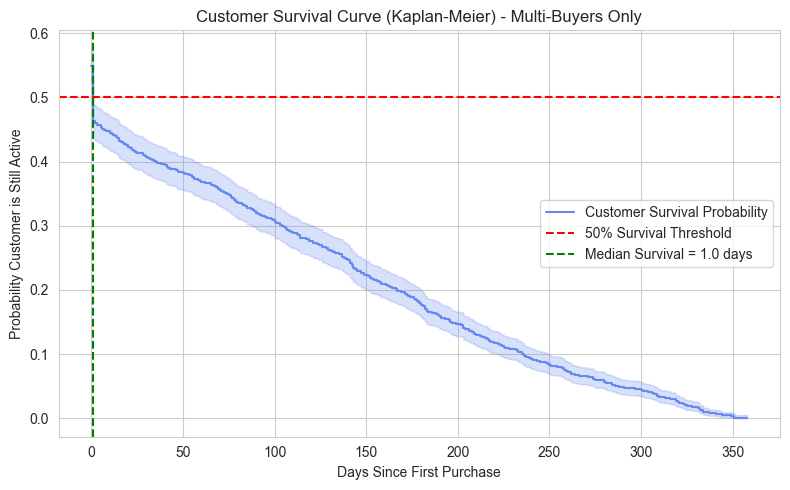

In [ ]:
# Adjusted Code: Exclude Non-Buyers or Single-Purchase Customers in the code above.
# - Filters out "one-time buyers" who can't have a measurable "time to churn."
# - Survival curve now reflects actual repeat customer retention, not single-purchase customers.
# - Median survival time should now increase beyond 1 day and give a meaningful retention duration.



# Count transactions per customer
customer_txn_counts = mart_all_data.groupby('customer_id')['transaction_id'].nunique()

# Keep only customers with more than 1 purchase
multi_buyers = customer_txn_counts[customer_txn_counts > 1].index
filtered_data = mart_all_data[mart_all_data['customer_id'].isin(multi_buyers)]

# Calculate observation end date
observation_end = filtered_data['transaction_date'].max()

# Compute customer lifespan
customer_lifespan = (
    filtered_data.groupby('customer_id')
    .agg(
        first_purchase=('transaction_date', 'min'),
        last_purchase=('transaction_date', 'max')
    )
)

# Duration in days
customer_lifespan['lifespan_days'] = (
    customer_lifespan['last_purchase'] - customer_lifespan['first_purchase']
).dt.days

# Event observed: churn = last purchase < observation end
customer_lifespan['event_observed'] = (
    customer_lifespan['last_purchase'] < observation_end
).astype(int)

# Fit Kaplan-Meier
kmf = KaplanMeierFitter()
kmf.fit(
    durations=customer_lifespan['lifespan_days'],
    event_observed=customer_lifespan['event_observed'],
    label='Customer Survival Probability'
)

# Get median survival time
median_survival = kmf.median_survival_time_

# Plot
plt.figure(figsize=(8, 5))
kmf.plot_survival_function(ci_show=True)
plt.axhline(0.5, color='red', linestyle='--', label='50% Survival Threshold')
plt.axvline(median_survival, color='green', linestyle='--',
            label=f'Median Survival = {median_survival} days')
plt.title('Customer Survival Curve (Kaplan-Meier) - Multi-Buyers Only')
plt.xlabel('Days Since First Purchase')
plt.ylabel('Probability Customer is Still Active')
plt.legend()
plt.tight_layout()
plt.show()

In [168]:
#  Repeat Purchase Probability
repeat_purchase = (
    mart_all_data.groupby('customer_id')['transaction_id']
    .count()
    .value_counts(normalize=True)
)

In [169]:
#  Cross-Sell and Product Affinity by Cohort. 
# Track whether cohorts expand their product categories over time:
# 1)Number of unique product categories purchased per user per cohort. 
# 2)Shows how customers evolve in their buying behavior.

category_spread = (
    mart_all_data.groupby(['customer_id', 'cohort_month'])['product_category']
    .nunique()
    .groupby('cohort_month')
    .mean()
)

coupon_status
Clicked     26926
Used        17904
Not Used     8094
Name: count, dtype: int64


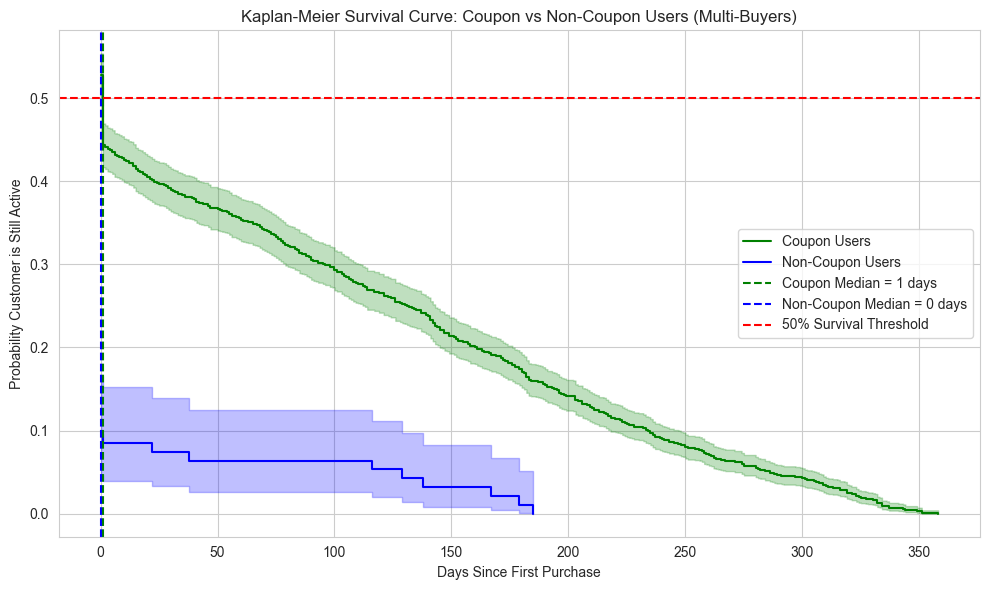

In [ ]:

# 1. Inspect coupon_status values 
print(mart_all_data['coupon_status'].value_counts(dropna=False))

# 2. Map categorical values to binary used_coupon flag based on coupon_status
mart_all_data['used_coupon'] = mart_all_data['coupon_status'].map({
    'Used': 1,
    'Clicked': 0,    # Change to 1 if you want to treat 'Clicked' as coupon used
    'Not Used': 0
}).fillna(0)

# 3. Build customer-level summary
customer_summary = (
    mart_all_data.groupby('customer_id')
    .agg(
        first_purchase=('transaction_date', 'min'),
        last_purchase=('transaction_date', 'max'),
        used_coupon=('used_coupon', 'max')  # max indicates if customer ever used coupon
    )
)

# 4. Calculate lifespan and event observed
customer_summary['lifespan_days'] = (customer_summary['last_purchase'] - customer_summary['first_purchase']).dt.days
customer_summary['event_observed'] = 1  # Assume all customers churn (or use actual event data if available)

# 5. Define masks for coupon and non-coupon users
mask_coupon = customer_summary['used_coupon'] == 1
mask_non_coupon = customer_summary['used_coupon'] == 0

# 6. Initialize Kaplan-Meier fitter instances
kmf_coupon = KaplanMeierFitter()
kmf_non_coupon = KaplanMeierFitter()

plt.figure(figsize=(10, 6))

# 7. Plot coupon users survival curve if data exists
if mask_coupon.sum() > 0:
    kmf_coupon.fit(
        durations=customer_summary.loc[mask_coupon, 'lifespan_days'],
        event_observed=customer_summary.loc[mask_coupon, 'event_observed'],
        label='Coupon Users'
    )
    kmf_coupon.plot_survival_function(ci_show=True, color='green')
else:
    print("No coupon users with valid data.")

# 8. Plot non-coupon users survival curve if data exists
if mask_non_coupon.sum() > 0:
    kmf_non_coupon.fit(
        durations=customer_summary.loc[mask_non_coupon, 'lifespan_days'],
        event_observed=customer_summary.loc[mask_non_coupon, 'event_observed'],
        label='Non-Coupon Users'
    )
    kmf_non_coupon.plot_survival_function(ci_show=True, color='blue')
else:
    print("No non-coupon users with valid data.")

# 9. Add median survival time vertical lines if groups exist
if mask_coupon.sum() > 0:
    plt.axvline(kmf_coupon.median_survival_time_, color='green', linestyle='--',
                label=f'Coupon Median = {int(kmf_coupon.median_survival_time_)} days')
if mask_non_coupon.sum() > 0:
    plt.axvline(kmf_non_coupon.median_survival_time_, color='blue', linestyle='--',
                label=f'Non-Coupon Median = {int(kmf_non_coupon.median_survival_time_)} days')

# 10. Add horizontal 50% survival threshold line and labels
plt.axhline(0.5, color='red', linestyle='--', label='50% Survival Threshold')
plt.title('Kaplan-Meier Survival Curve: Coupon vs Non-Coupon Users (Multi-Buyers)')
plt.xlabel('Days Since First Purchase')
plt.ylabel('Probability Customer is Still Active')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:

# 1. Set up connection 

config = dotenv_values() 

# define variables for the login
pg_user = config['POSTGRES_USER'] 
pg_host = config['POSTGRES_HOST']
pg_port = config['POSTGRES_PORT']
pg_db = config['POSTGRES_DB']
pg_schema = config['POSTGRES_SCHEMA']
pg_pass = config['POSTGRES_PASS']

url = f'postgresql://{pg_user}:{pg_pass}@{pg_host}:{pg_port}/{pg_db}'

engine = create_engine(url, echo=False)

# 2. Load data

my_schema = "team_3"

mart_all_data = pd.read_sql(
    f"SELECT * FROM {my_schema}.mart_all_data;",
    engine,
    parse_dates=['transaction_date']
)

# Customer demographic data (for segmentation)
mart_customers = pd.read_sql(
    f"SELECT * FROM {my_schema}.mart_customers;",
    engine
)

In [172]:
mart_all_data.head()

transaction_date  transaction_id  customer_id customer_gender customer_location  customer_tenure_months     produkt_sku product_category  quantity  \
0       2019-04-19           25990        15811               F          Illinois                      27  GGOEWCKQ085457      Accessories         1   
1       2019-04-07           25038        17999               F        New Jersey                      30  GGOEGBPB081999      Accessories         1   
2       2019-04-07           25038        17999               F        New Jersey                      30  GGOEGBPB082099      Accessories         1   
3       2019-04-28           26637        18116               F          Illinois                      38  GGOEGBPB081999      Accessories         1   
4       2019-08-02           34452        16889               F          Illinois                      23  GGOEGBPB081999      Accessories         1   

   avg_price  delivery_charges  revenue coupon_status  discount_pct  gst_onsale  daily_offline  daily_online  transaction_month transaction_month_str  
0      16.99               6.0    22.99       Clicked          10.0         0.1           4000       1754.92                4.0                   apr  
1      49.99               6.5    56.49          Used          10.0         0.1           2500       2719.46                4.0                   apr  
2      59.99               6.5    66.49       Clicked          10.0         0.1           2500       2719.46                4.0                   apr  
3      39.99               6.0    45.99       Clicked          10.0         0.1           3500       2019.73                4.0                   apr  
4      34.99               6.0    40.99          Used          20.0         0.1           1500       2155.96                8.0                   aug

In [173]:
mart_all_data['revenue'] = mart_all_data['quantity'] * mart_all_data['avg_price'] + mart_all_data['delivery_charges']

In [174]:
mart_all_data.columns

Index(['transaction_date', 'transaction_id', 'customer_id', 'customer_gender', 'customer_location', 'customer_tenure_months', 'produkt_sku',
       'product_category', 'quantity', 'avg_price', 'delivery_charges', 'revenue', 'coupon_status', 'discount_pct', 'gst_onsale', 'daily_offline',
       'daily_online', 'transaction_month', 'transaction_month_str'],
      dtype='object')

In [175]:
# 1. Get each customer's signup month (=first purchase)

mart_all_data['transaction_date'] = pd.to_datetime(mart_all_data['transaction_date'])
mart_all_data['transaction_month'] = mart_all_data['transaction_date'].dt.to_period('M')
first_orders = mart_all_data.groupby('customer_id')['transaction_month'].min().reset_index()
first_orders = first_orders.rename(columns={'transaction_month': 'signup_month'})
mart_all_data = mart_all_data.merge(first_orders, on='customer_id', how='left')
mart_all_data['cohort_index'] = (mart_all_data['transaction_month'] - mart_all_data['signup_month']).apply(lambda x: x.n)

In [176]:
# 1. Get each customer's signup month
mart_all_data['transaction_month'] = mart_all_data['transaction_date'].dt.to_period('M')

first_orders = (
    mart_all_data.groupby('customer_id')['transaction_month']
    .min()
    .reset_index()
    .rename(columns={'transaction_month': 'signup_month'})
)

# 2. Build orders table (customer_id, transaction_month, signup_month)
orders = mart_all_data[['customer_id', 'transaction_month']].drop_duplicates()
orders = orders.merge(first_orders, on='customer_id', how='left')
orders['cohort_index'] = (orders['transaction_month'] - orders['signup_month']).apply(lambda x: x.n)


Cohort Pivot Table (Retention Matrix)

In [177]:

#Retention Matrix (Customers Retained Each Month)
cohort_counts = (
    mart_all_data.groupby(['signup_month', 'cohort_index'])['customer_id']
    .nunique()
    .reset_index()
    .pivot(index='signup_month', columns='cohort_index', values='customer_id')
)


In [178]:
# Calculate retention as % of original cohort size
cohort_size = cohort_counts.iloc[:, 0]
retention = cohort_counts.divide(cohort_size, axis=0).round(3) * 100
print("Retention Matrix (%):")
print(retention)

Retention Matrix (%):
cohort_index     0     1     2     3     4     5     6     7     8     9     10    11
signup_month                                                                         
2019-01       100.0   6.0  11.2  15.8  10.7  20.5  16.3  21.9  10.7  13.0   9.3  15.8
2019-02       100.0   7.3   9.4  16.7  17.7  22.9  19.8  15.6  12.5  11.5  16.7   NaN
2019-03       100.0  10.2  19.8  14.1  18.1  18.6  12.4  12.4   8.5  10.7   NaN   NaN
2019-04       100.0   8.6  14.7  14.7  11.0   9.2   6.1   9.8   7.4   NaN   NaN   NaN
2019-05       100.0  10.7   8.0  11.6   8.9  11.6  12.5   7.1   NaN   NaN   NaN   NaN
2019-06       100.0  14.6  16.1   8.8   8.0  10.2   8.0   NaN   NaN   NaN   NaN   NaN
2019-07       100.0  13.8   4.3   6.4  11.7   9.6   NaN   NaN   NaN   NaN   NaN   NaN
2019-08       100.0  10.4  11.1   7.4   5.9   NaN   NaN   NaN   NaN   NaN   NaN   NaN
2019-09       100.0   7.7   3.8   2.6   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN
2019-10       100.0   6.9   4.6 

In [179]:
#Cohort Revenue Matrix
cohort_revenue = (
    mart_all_data.groupby(['signup_month', 'cohort_index'])['revenue']
    .sum()
    .reset_index()
    .pivot(index='signup_month', columns='cohort_index', values='revenue')
)
print("Cohort Revenue (total revenue per cohort per period):")
print(cohort_revenue)

Cohort Revenue (total revenue per cohort per period):
cohort_index         0         1         2          3         4         5         6         7         8         9         10        11
signup_month                                                                                                                          
2019-01       462866.90  45272.03  58542.51  122221.36  34476.56  58699.00  93102.69  57900.94  45707.86  50372.07  43127.67  99334.38
2019-02       314764.37   9751.88  14331.18   25113.18  26551.65  47446.90  27545.26  49619.59  18470.83  30783.66  50943.62       NaN
2019-03       342113.64  44608.13  40717.04   33580.92  52847.02  78221.45  52603.43  43494.44  26507.72  39353.19       NaN       NaN
2019-04       261939.49  25695.19  18324.83   33470.91  28985.33  32875.04  17243.75  60079.41  19718.24       NaN       NaN       NaN
2019-05       223157.62   7491.65  14005.50   17177.14  18788.38  40526.46  40228.59  12306.63       NaN       NaN       NaN       NaN
2

In [180]:
#LTV Matrix (Cumulative Revenue Per Customer in Cohort)
cumulative_revenue = cohort_revenue.cumsum(axis=1)
cumulative_ltv = cumulative_revenue.divide(cohort_size, axis=0).round(2)
print("Cumulative LTV Matrix (Avg. $ per original cohort member):")
print(cumulative_ltv)

Cumulative LTV Matrix (Avg. $ per original cohort member):
cohort_index       0        1        2        3        4        5        6        7        8        9        10       11
signup_month                                                                                                            
2019-01       2152.87  2363.44  2635.73  3204.20  3364.56  3637.57  4070.61  4339.92  4552.51  4786.80  4987.39  5449.41
2019-02       3278.80  3380.38  3529.66  3791.26  4067.84  4562.07  4849.00  5365.88  5558.28  5878.94  6409.61      NaN
2019-03       1932.85  2184.87  2414.91  2604.63  2903.20  3345.13  3642.33  3888.06  4037.82  4260.15      NaN      NaN
2019-04       1606.99  1764.63  1877.05  2082.40  2260.22  2461.91  2567.70  2936.28  3057.25      NaN      NaN      NaN
2019-05       1992.48  2059.37  2184.42  2337.78  2505.54  2867.38  3226.57  3336.45      NaN      NaN      NaN      NaN
2019-06       1561.66  1652.57  1762.26  1893.43  1975.92  2264.70  2386.39      NaN      NaN 

In [181]:
#Revenue Per Retained Customer
revenue_per_retained = cohort_revenue.divide(cohort_counts).round(2)
print("Revenue Per Retained Customer (only those active in each period):")
print(revenue_per_retained)

Revenue Per Retained Customer (only those active in each period):
cohort_index       0        1        2        3        4        5        6        7        8        9        10      11
signup_month                                                                                                           
2019-01       2152.87  3482.46  2439.27  3594.75  1498.98  1334.07  2660.08  1231.93  1987.30  1799.00  2156.38  2921.6
2019-02       3278.80  1393.13  1592.35  1569.57  1561.86  2156.68  1449.75  3307.97  1539.24  2798.51  3183.98     NaN
2019-03       1932.85  2478.23  1163.34  1343.24  1651.47  2370.35  2391.06  1977.02  1767.18  2071.22      NaN     NaN
2019-04       1606.99  1835.37   763.53  1394.62  1610.30  2191.67  1724.38  3754.96  1643.19      NaN      NaN     NaN
2019-05       1992.48   624.30  1556.17  1321.32  1878.84  3117.42  2873.47  1538.33      NaN      NaN      NaN     NaN
2019-06       1561.66   622.79   683.04  1497.56  1027.35  2825.87  1515.59      NaN      NaN 

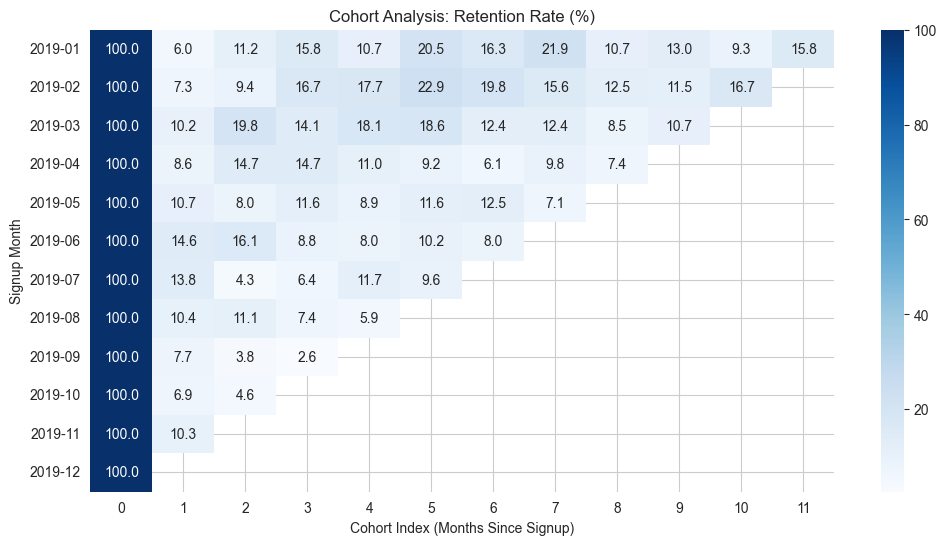

In [182]:
# Retention Heatmap

plt.figure(figsize=(12, 6))
sns.heatmap(retention, annot=True, fmt='.1f', cmap='Blues')
plt.title('Cohort Analysis: Retention Rate (%)')
plt.xlabel('Cohort Index (Months Since Signup)')
plt.ylabel('Signup Month')
plt.show()

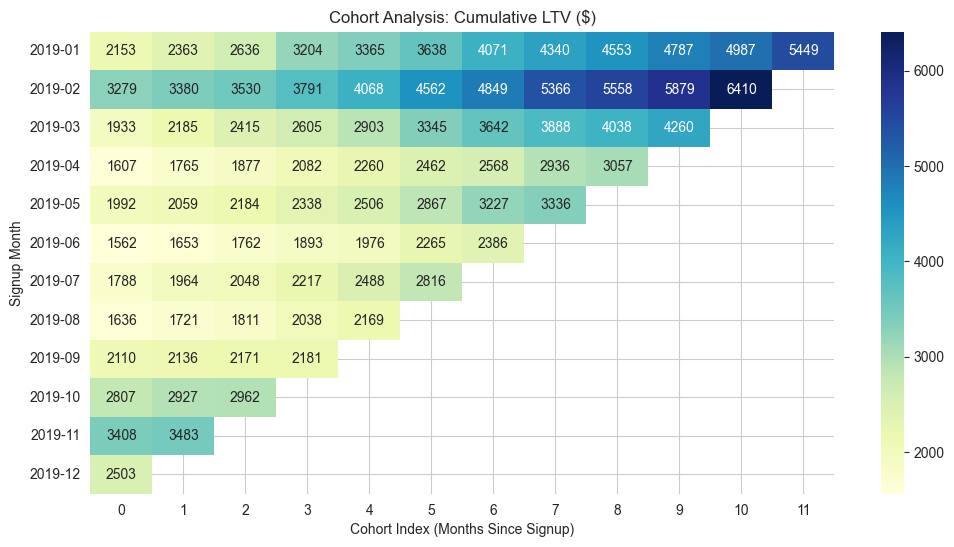

In [183]:
#Cumulative LTV Heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(cumulative_ltv, annot=True, fmt='.0f', cmap='YlGnBu')
plt.title('Cohort Analysis: Cumulative LTV ($)')
plt.xlabel('Cohort Index (Months Since Signup)')
plt.ylabel('Signup Month')
plt.show()

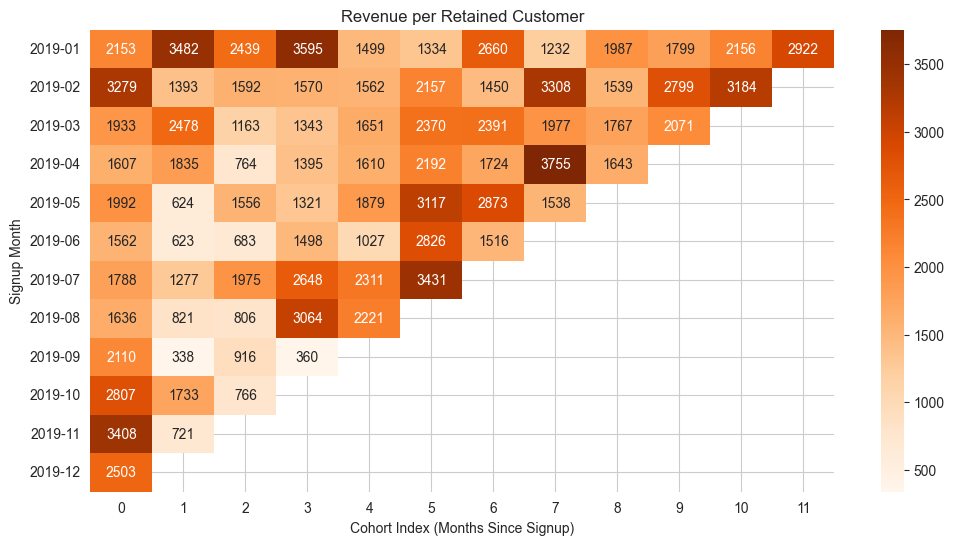

In [184]:
#Revenue Per Retained Customer Heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(revenue_per_retained, annot=True, fmt='.0f', cmap='Oranges')
plt.title('Revenue per Retained Customer')
plt.xlabel('Cohort Index (Months Since Signup)')
plt.ylabel('Signup Month')
plt.show()

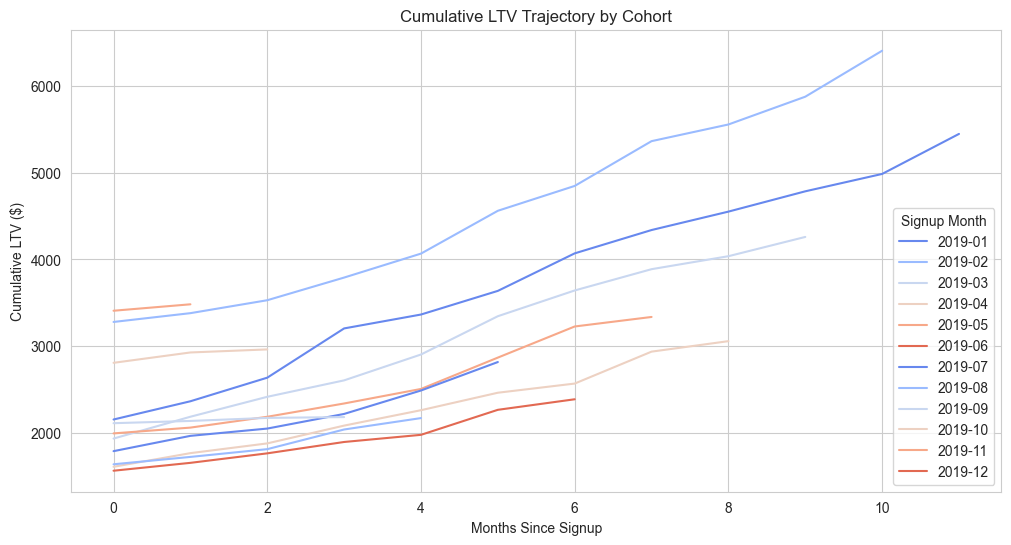

In [185]:
#Compare Cohort Revenue Trajectories
plt.figure(figsize=(12, 6))
for i, row in cumulative_ltv.iterrows():
    plt.plot(row.values, label=str(i))
plt.title('Cumulative LTV Trajectory by Cohort')
plt.xlabel('Months Since Signup')
plt.ylabel('Cumulative LTV ($)')
plt.legend(title='Signup Month')
plt.show()

Cohort analysis by gender

In [186]:
mart_all_data = mart_all_data.merge(mart_customers, on='customer_id', how='left')

for seg in mart_all_data['gender'].dropna().unique():
    sub = mart_all_data[mart_all_data['gender'] == seg]
    cohort_counts = (
        sub.groupby(['signup_month', 'cohort_index'])['customer_id']
        .nunique()
        .reset_index()
        .pivot(index='signup_month', columns='cohort_index', values='customer_id')
    )
    cohort_size = cohort_counts.iloc[:, 0]
    retention = cohort_counts.divide(cohort_size, axis=0).round(3) * 100
    print(f"\nRetention Matrix (%) for Gender: {seg}")
    print(retention)


Retention Matrix (%) for Gender: F
cohort_index     0     1     2     3     4     5     6     7     8     9     10    11
signup_month                                                                         
2019-01       100.0   7.8  10.1  14.7   9.3  22.5  15.5  18.6  10.9  12.4  11.6  15.5
2019-02       100.0   9.2   9.2  18.5  12.3  24.6  15.4  18.5  12.3   9.2  15.4   NaN
2019-03       100.0   9.6  20.9  13.0  16.5  18.3  13.9  13.0   9.6  11.3   NaN   NaN
2019-04       100.0   6.9  13.7  13.7  14.7  10.8   3.9  10.8   6.9   NaN   NaN   NaN
2019-05       100.0  10.7   8.0  13.3   9.3   9.3  12.0   4.0   NaN   NaN   NaN   NaN
2019-06       100.0  15.3  17.6   9.4   5.9  10.6   5.9   NaN   NaN   NaN   NaN   NaN
2019-07       100.0  13.8   1.7   5.2  15.5  10.3   NaN   NaN   NaN   NaN   NaN   NaN
2019-08       100.0   9.5  11.9   6.0   4.8   NaN   NaN   NaN   NaN   NaN   NaN   NaN
2019-09       100.0  10.8   5.4   5.4   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN
2019-10       100.

Cohort analysis by AOV_segment

In [187]:
# Calculate each customer's total revenue and number of orders
aov_per_customer = (
    mart_all_data.groupby('customer_id')
    .agg(
        total_revenue=('revenue', 'sum'),
        n_orders=('transaction_id', 'nunique')
    )
    .reset_index()
)
aov_per_customer['AOV'] = aov_per_customer['total_revenue'] / aov_per_customer['n_orders']


In [188]:
#Create AOV Segments (quartiles bins)

aov_per_customer['AOV_segment'] = pd.qcut(
    aov_per_customer['AOV'],
    q=4,
    labels=['Low', 'Medium-Low', 'Medium-High', 'High']
)

In [189]:
#Merge Segment Back to mart_all_data
mart_all_data = mart_all_data.merge(aov_per_customer[['customer_id', 'AOV_segment']], on='customer_id', how='left')

Cohort Analysis Loop

In [190]:
for seg in mart_all_data['AOV_segment'].dropna().unique():
    sub = mart_all_data[mart_all_data['AOV_segment'] == seg]
    cohort_counts = (
        sub.groupby(['signup_month', 'cohort_index'])['customer_id']
        .nunique()
        .reset_index()
        .pivot(index='signup_month', columns='cohort_index', values='customer_id')
    )
    cohort_size = cohort_counts.iloc[:, 0]
    retention = cohort_counts.divide(cohort_size, axis=0).round(3) * 100
    print(f"\nRetention Matrix (%) for AOV Segment: {seg}")
    print(retention)


Retention Matrix (%) for AOV Segment: Low
cohort_index     0    1     2     3     4     5     6     7    8     9     10   11
signup_month                                                                      
2019-01       100.0  2.6   5.3  10.5   7.9   7.9  13.2  18.4  2.6  10.5   NaN  5.3
2019-02       100.0  NaN   5.6  11.1  22.2  22.2  22.2   5.6  5.6   NaN  11.1  NaN
2019-03       100.0  6.7  15.6   6.7  15.6  17.8   8.9   4.4  4.4   NaN   NaN  NaN
2019-04       100.0  5.8  17.3   3.8  11.5   3.8   1.9   3.8  3.8   NaN   NaN  NaN
2019-05       100.0  7.3   7.3   7.3   4.9   7.3   NaN   4.9  NaN   NaN   NaN  NaN
2019-06       100.0  7.7  17.9   5.1   5.1   NaN   5.1   NaN  NaN   NaN   NaN  NaN
2019-07       100.0  6.2   NaN   6.2   3.1   3.1   NaN   NaN  NaN   NaN   NaN  NaN
2019-08       100.0  9.5   7.1   4.8   2.4   NaN   NaN   NaN  NaN   NaN   NaN  NaN
2019-09       100.0  5.3   NaN   NaN   NaN   NaN   NaN   NaN  NaN   NaN   NaN  NaN
2019-10       100.0  NaN   NaN   NaN   NaN  

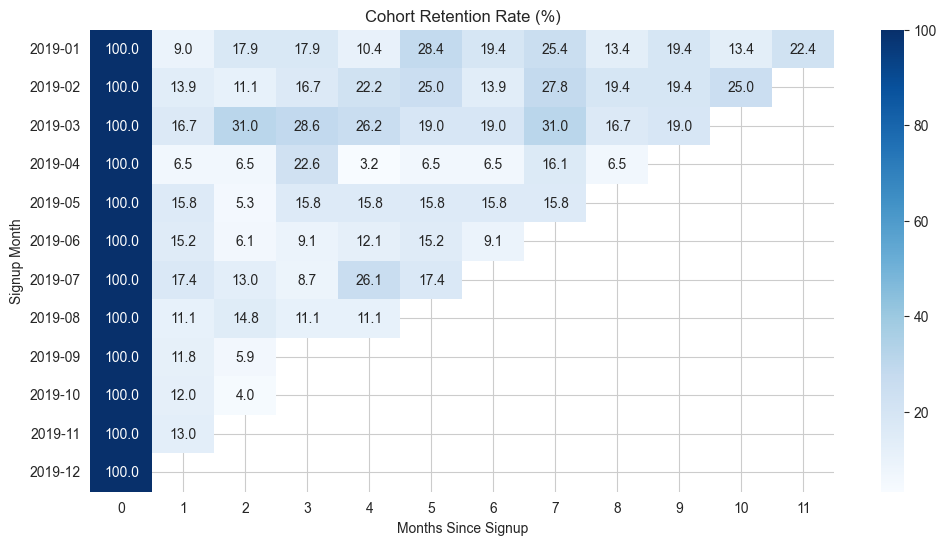

In [344]:

plt.figure(figsize=(12, 6))
sns.heatmap(retention, annot=True, fmt='.1f', cmap='Blues')
plt.title('Cohort Retention Rate (%)')
plt.xlabel('Months Since Signup')
plt.ylabel('Signup Month')
plt.show()

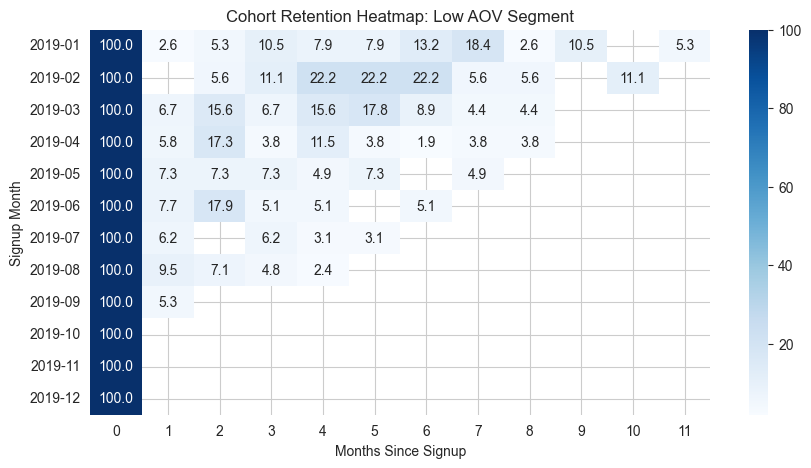

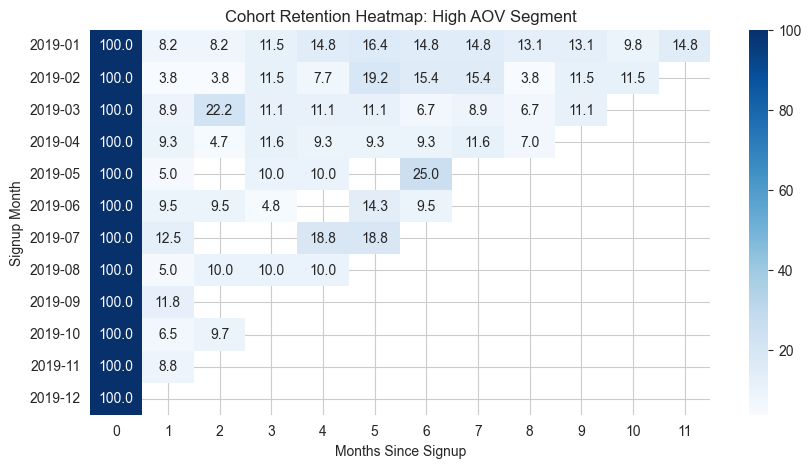

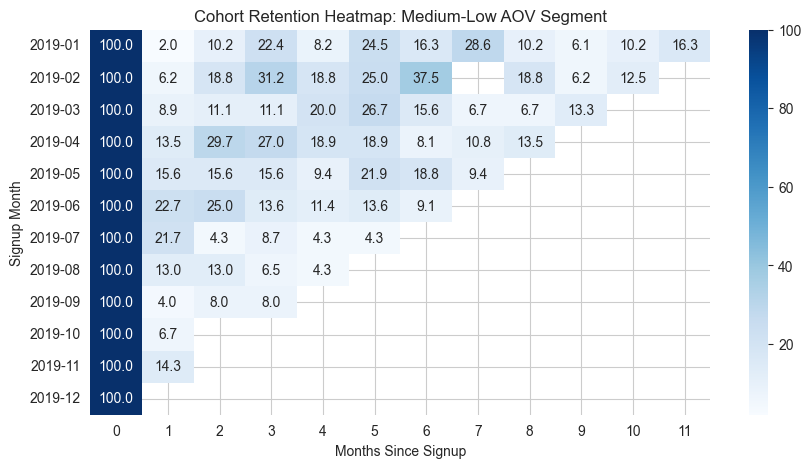

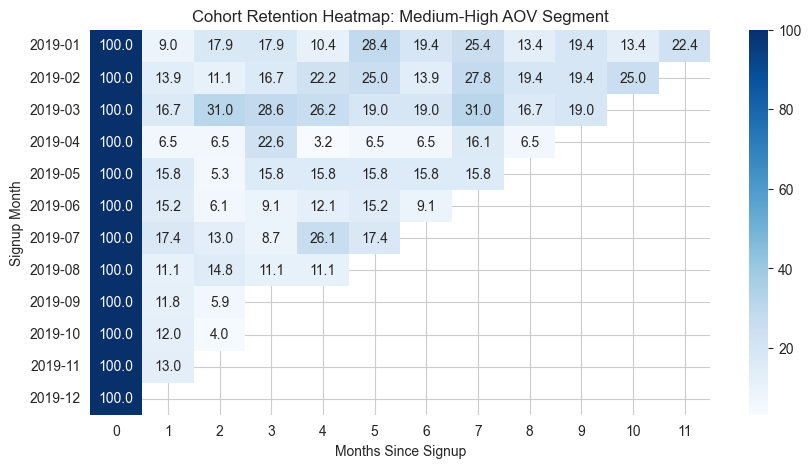

In [191]:

# Loop through each AOV segment and plot a heatmap
for seg in mart_all_data['AOV_segment'].dropna().unique():
    sub = mart_all_data[mart_all_data['AOV_segment'] == seg]
    cohort_counts = (
        sub.groupby(['signup_month', 'cohort_index'])['customer_id']
        .nunique()
        .reset_index()
        .pivot(index='signup_month', columns='cohort_index', values='customer_id')
    )
    cohort_size = cohort_counts.iloc[:, 0]
    retention = cohort_counts.divide(cohort_size, axis=0).round(3) * 100
    
    plt.figure(figsize=(10, 5))
    sns.heatmap(retention, annot=True, fmt='.1f', cmap='Blues')
    plt.title(f'Cohort Retention Heatmap: {seg} AOV Segment')
    plt.xlabel('Months Since Signup')
    plt.ylabel('Signup Month')
    plt.show()

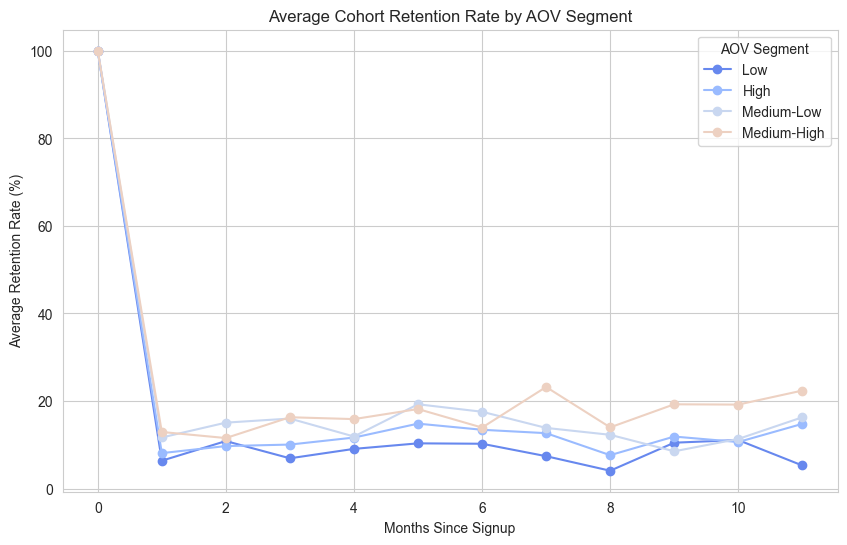

In [192]:
#Plot All Segments Together (Average Retention by Cohort Index)
plt.figure(figsize=(10, 6))

for seg in mart_all_data['AOV_segment'].dropna().unique():
    sub = mart_all_data[mart_all_data['AOV_segment'] == seg]
    cohort_counts = (
        sub.groupby(['signup_month', 'cohort_index'])['customer_id']
        .nunique()
        .reset_index()
        .pivot(index='signup_month', columns='cohort_index', values='customer_id')
    )
    cohort_size = cohort_counts.iloc[:, 0]
    retention = cohort_counts.divide(cohort_size, axis=0).round(3) * 100
    avg_retention = retention.mean(axis=0)
    plt.plot(avg_retention.index, avg_retention.values, marker='o', label=f"{seg}")

plt.title('Average Cohort Retention Rate by AOV Segment')
plt.xlabel('Months Since Signup')
plt.ylabel('Average Retention Rate (%)')
plt.legend(title='AOV Segment')
plt.grid(True)
plt.show()

#Overlay Revenue-Per-Retained-Customer by Cohort Period and Segment

Goal:
For each AOV segment, in each cohort month, show not just how many customers were retained, but how much (on average) they spent.

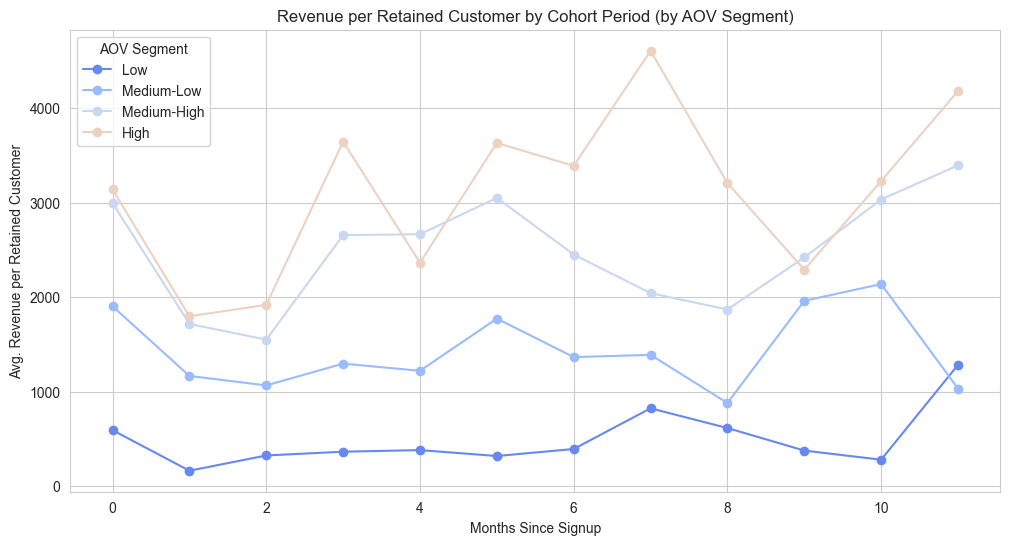

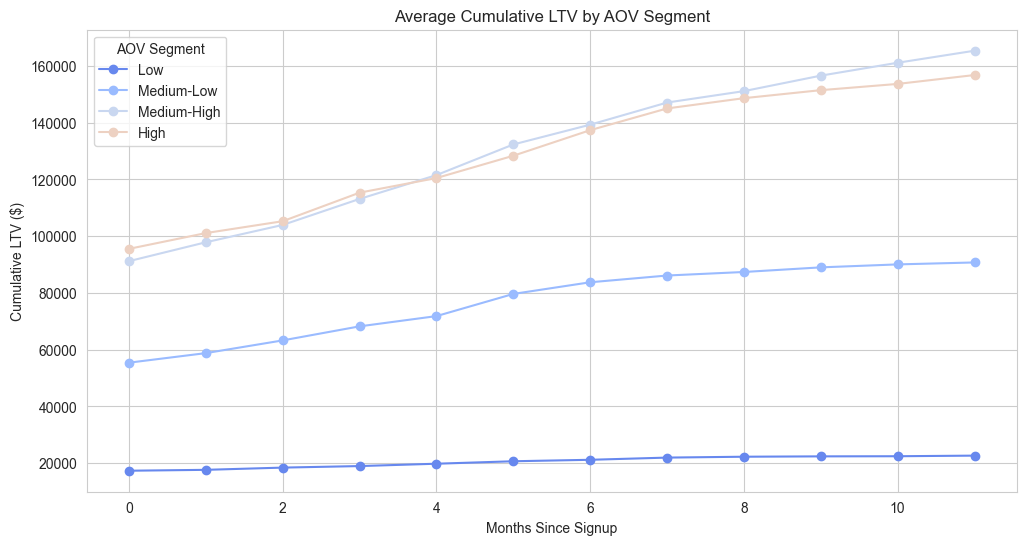

In [ ]:
# Group by segment, signup month, and cohort index

# a) Datetime
mart_all_data['transaction_date'] = pd.to_datetime(mart_all_data['transaction_date'])

# b) Revenue column to use (pick what's available or build it)
if 'invoice_value' in mart_all_data.columns:
    revenue_col = 'invoice_value'
elif 'revenue' in mart_all_data.columns:
    revenue_col = 'revenue'
else:
    # try to construct a final price if possible
    gross = mart_all_data.get('quantity', 1) * mart_all_data.get('avg_price', 0)
    disc = gross * (mart_all_data.get('discount_pct', 0) / 100.0)
    net_subtotal = gross - disc
    pre_tax = net_subtotal + mart_all_data.get('delivery_charges', 0)
    gst = pre_tax * (mart_all_data.get('gst_onsale', 0) / 100.0)
    mart_all_data['invoice_value'] = pre_tax + gst
    revenue_col = 'invoice_value'

# c) Cohort fields (signup_month and cohort_index)
#    signup_month = month of first purchase
first_dt = mart_all_data.groupby('customer_id')['transaction_date'].transform('min')
mart_all_data['signup_month'] = first_dt.dt.to_period('M').astype(str)

# months since signup (integer)
t_year = mart_all_data['transaction_date'].dt.year
t_mon  = mart_all_data['transaction_date'].dt.month
s_year = pd.to_datetime(mart_all_data['signup_month']).dt.year
s_mon  = pd.to_datetime(mart_all_data['signup_month']).dt.month
mart_all_data['cohort_index'] = (t_year - s_year) * 12 + (t_mon - s_mon)

# d) AOV_segment 
if 'AOV_segment' not in mart_all_data.columns:
    per_cust = (
        mart_all_data.groupby('customer_id')
        .agg(rev=(revenue_col, 'sum'), orders=('transaction_id', 'nunique'))
        .reset_index()
    )
    per_cust['AOV'] = per_cust['rev'] / per_cust['orders'].replace(0, np.nan)
    per_cust['AOV_segment'] = pd.qcut(per_cust['AOV'].fillna(0), q=4,
                                      labels=['Low','Medium-Low','Medium-High','High'])
    mart_all_data = mart_all_data.merge(per_cust[['customer_id','AOV_segment']], on='customer_id', how='left')

# --- 1) Revenue per retained customer (by segment & cohort_index) ---

revenue_per_retained = (
    mart_all_data.groupby(['AOV_segment', 'signup_month', 'cohort_index'])
    .agg(
        total_revenue=(revenue_col, 'sum'),
        n_retained=('customer_id', 'nunique')
    )
    .reset_index()
)

# avoid div-by-zero
revenue_per_retained['rev_per_retained'] = (
    revenue_per_retained['total_revenue'] / revenue_per_retained['n_retained'].replace(0, np.nan)
)

# Plot average across cohorts per segment
plt.figure(figsize=(12,6))
for seg in revenue_per_retained['AOV_segment'].dropna().unique():
    sub = revenue_per_retained[revenue_per_retained['AOV_segment'] == seg]
    avg_by_index = sub.groupby('cohort_index')['rev_per_retained'].mean()
    plt.plot(avg_by_index.index, avg_by_index.values, marker='o', label=str(seg))

plt.title('Revenue per Retained Customer by Cohort Period (by AOV Segment)')
plt.xlabel('Months Since Signup')
plt.ylabel('Avg. Revenue per Retained Customer')
plt.legend(title='AOV Segment')
plt.show()

# --- 2) Cumulative LTV curves (average cumulative spend per customer, by segment) ---

# total revenue by (segment, cohort) per cohort month
cum_rev = (
    mart_all_data.groupby(['AOV_segment', 'signup_month', 'cohort_index'])
    .agg(total_revenue=(revenue_col, 'sum'))
    .reset_index()
)

# pivot: rows=(signup_month, cohort_index), cols=AOV_segment
pivot = cum_rev.pivot_table(index=['signup_month','cohort_index'],
                            columns='AOV_segment',
                            values='total_revenue',
                            fill_value=0)

# cumulative over cohort months within each signup cohort
cum_ltv = pivot.groupby(level=0).cumsum()  # cumulative along cohort_index within each signup_month

# now average across cohorts at each cohort_index for each segment
plt.figure(figsize=(12,6))
for seg in pivot.columns:
    series = cum_ltv[seg].reset_index().groupby('cohort_index')[seg].mean()
    plt.plot(series.index, series.values, marker='o', label=str(seg))

plt.title('Average Cumulative LTV by AOV Segment')
plt.xlabel('Months Since Signup')
plt.ylabel('Cumulative LTV ($)')
plt.legend(title='AOV Segment')
plt.show()

In [ ]:

# 1. Set up connection 

config = dotenv_values() 

# define variables for the login
pg_user = config['POSTGRES_USER']  
pg_host = config['POSTGRES_HOST']
pg_port = config['POSTGRES_PORT']
pg_db = config['POSTGRES_DB']
pg_schema = config['POSTGRES_SCHEMA']
pg_pass = config['POSTGRES_PASS']

url = f'postgresql://{pg_user}:{pg_pass}@{pg_host}:{pg_port}/{pg_db}'

engine = create_engine(url, echo=False)

# 2. Load data

my_schema = "team_3"

mart_all_data = pd.read_sql(
    f"SELECT * FROM {my_schema}.mart_all_data;",
    engine,
    parse_dates=['transaction_date']
)

# Customer demographic data (for segmentation)
mart_customers = pd.read_sql(
    f"SELECT * FROM {my_schema}.mart_customers;",
    engine
)

In [195]:
mart_all_data.head()

transaction_date  transaction_id  customer_id customer_gender customer_location  customer_tenure_months     produkt_sku product_category  quantity  \
0       2019-04-19           25990        15811               F          Illinois                      27  GGOEWCKQ085457      Accessories         1   
1       2019-04-07           25038        17999               F        New Jersey                      30  GGOEGBPB081999      Accessories         1   
2       2019-04-07           25038        17999               F        New Jersey                      30  GGOEGBPB082099      Accessories         1   
3       2019-04-28           26637        18116               F          Illinois                      38  GGOEGBPB081999      Accessories         1   
4       2019-08-02           34452        16889               F          Illinois                      23  GGOEGBPB081999      Accessories         1   

   avg_price  delivery_charges  revenue coupon_status  discount_pct  gst_onsale  daily_offline  daily_online  transaction_month transaction_month_str  
0      16.99               6.0    22.99       Clicked          10.0         0.1           4000       1754.92                4.0                   apr  
1      49.99               6.5    56.49          Used          10.0         0.1           2500       2719.46                4.0                   apr  
2      59.99               6.5    66.49       Clicked          10.0         0.1           2500       2719.46                4.0                   apr  
3      39.99               6.0    45.99       Clicked          10.0         0.1           3500       2019.73                4.0                   apr  
4      34.99               6.0    40.99          Used          20.0         0.1           1500       2155.96                8.0                   aug

In [196]:
mart_all_data['revenue'] = mart_all_data['quantity'] * mart_all_data['avg_price'] + mart_all_data['delivery_charges']

In [197]:
cutoff_date = pd.Timestamp('2019-04-01')
future_6m_end = cutoff_date + pd.DateOffset(days=180)

customers_before_cutoff = mart_all_data[mart_all_data['transaction_date'] < cutoff_date]['customer_id'].unique()

actual_ltv = (
    mart_all_data[
        (mart_all_data['customer_id'].isin(customers_before_cutoff)) &
        (mart_all_data['transaction_date'] >= cutoff_date) &
        (mart_all_data['transaction_date'] < future_6m_end)
    ]
    .groupby('customer_id')['revenue'].sum()
    .reset_index()
    .rename(columns={'revenue': 'actual_LTV_6m'})
)

In [198]:
# Add Predicted LTV

eval_df = actual_ltv


In [199]:
# Merge with Customer Segments

segment_df = eval_df.merge(mart_customers, on='customer_id', how='left')


In [200]:
# Segment Analysis Example (by Gender or Location)

# You can analyze by gender, location, or any customer field.
segment = 'gender'  # or 'customer_location' or another categorical column

segment_stats = (
    segment_df.groupby(segment)
    .agg(
        n_customers = ('customer_id', 'count'),
        mean_actual_LTV_6m = ('actual_LTV_6m', 'mean'),
        median_actual_LTV_6m = ('actual_LTV_6m', 'median'),
        return_rate = ('actual_LTV_6m', lambda x: (x > 0).mean())
    )
    .reset_index()
)
print(segment_stats)

  gender  n_customers  mean_actual_LTV_6m  median_actual_LTV_6m  return_rate
0      F          158         3645.422595              1682.410          1.0
1      M           98         3205.291020              1546.245          1.0


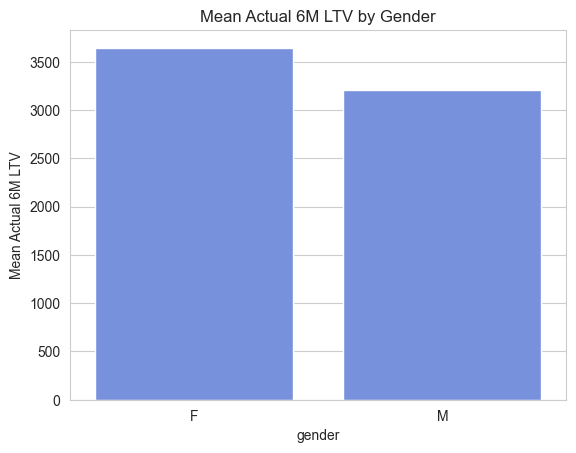

In [201]:
#7.  Visualize


sns.barplot(x=segment, y='mean_actual_LTV_6m', data=segment_stats)
plt.title(f'Mean Actual 6M LTV by {segment.title()}')
plt.ylabel('Mean Actual 6M LTV')
plt.show()

In [202]:
segment = 'location'
segment_stats = (
    segment_df.groupby(segment)
    .agg(
        n_customers = ('customer_id', 'count'),
        mean_actual_LTV_6m = ('actual_LTV_6m', 'mean'),
        median_actual_LTV_6m = ('actual_LTV_6m', 'median'),
        return_rate = ('actual_LTV_6m', lambda x: (x > 0).mean())
    )
    .reset_index()
)
print(segment_stats)

        location  n_customers  mean_actual_LTV_6m  median_actual_LTV_6m  return_rate
0     California           81         3773.367654              1914.390          1.0
1       Illinois           75         5050.904533              1893.750          1.0
2     New Jersey           21         2033.113810               562.430          1.0
3       New York           62         2180.857097              1089.815          1.0
4  Washington DC           17         1630.949412              1129.490          1.0


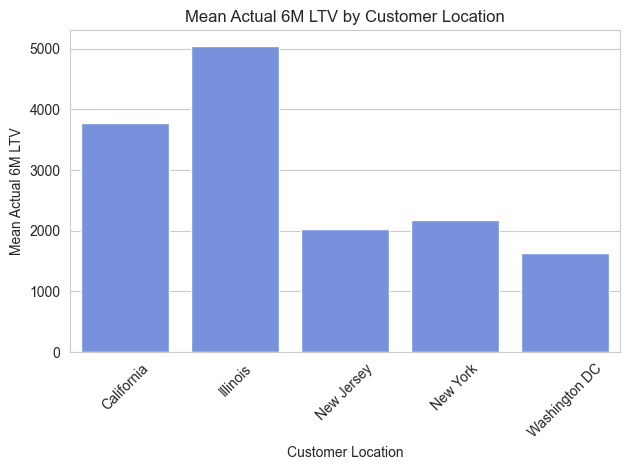

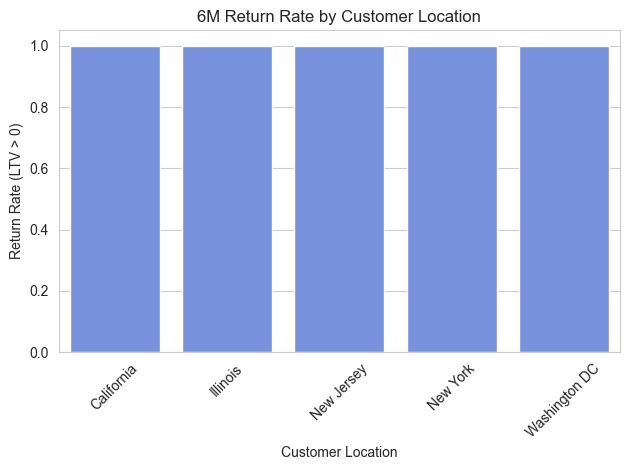

In [203]:

# Barplot: Mean LTV by location
sns.barplot(x=segment, y='mean_actual_LTV_6m', data=segment_stats)
plt.title('Mean Actual 6M LTV by Customer Location')
plt.ylabel('Mean Actual 6M LTV')
plt.xlabel('Customer Location')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Barplot: Return rate by location
sns.barplot(x=segment, y='return_rate', data=segment_stats)
plt.title('6M Return Rate by Customer Location')
plt.ylabel('Return Rate (LTV > 0)')
plt.xlabel('Customer Location')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




In [204]:
# Calculate total revenue and total orders per customer in the PRE-CUTOFF period
cutoff_date = pd.Timestamp('2019-04-01')

pre_cutoff = mart_all_data[mart_all_data['transaction_date'] < cutoff_date]

aov_df = (
    pre_cutoff.groupby('customer_id')
    .agg(
        total_revenue=('revenue', 'sum'),
        n_orders=('transaction_id', 'nunique')
    )
    .reset_index()
)
aov_df['AOV'] = aov_df['total_revenue'] / aov_df['n_orders']

In [205]:
# Merge AOV with actual LTV and customer info
aov_segment_df = eval_df.merge(aov_df[['customer_id', 'AOV']], on='customer_id', how='left')
aov_segment_df = aov_segment_df.merge(mart_customers, on='customer_id', how='left')

In [207]:
#  Quartiles:
aov_segment_df['AOV_segment'] = pd.qcut(aov_segment_df['AOV'], q=4, labels=['Low', 'Medium-Low', 'Medium-High', 'High'])
# Or use custom bins, e.g.:
# aov_segment_df['AOV_segment'] = pd.cut(aov_segment_df['AOV'], bins=[0, 50, 150, 500, np.inf], labels=['Very Low', 'Low', 'Medium', 'High'])

Segment-level LTV Analysis


In [208]:
segment = 'AOV_segment'
segment_stats = (
    aov_segment_df.groupby(segment)
    .agg(
        n_customers = ('customer_id', 'count'),
        mean_actual_LTV_6m = ('actual_LTV_6m', 'mean'),
        median_actual_LTV_6m = ('actual_LTV_6m', 'median'),
        mean_AOV = ('AOV', 'mean'),
        median_AOV = ('AOV', 'median'),
        return_rate = ('actual_LTV_6m', lambda x: (x > 0).mean())
    )
    .reset_index()
)
print(segment_stats)

   AOV_segment  n_customers  mean_actual_LTV_6m  median_actual_LTV_6m    mean_AOV  median_AOV  return_rate
0          Low           64         2300.352656              1142.935   82.877339   90.280000          1.0
1   Medium-Low           64         2857.320312              1259.605  153.892459  155.604167          1.0
2  Medium-High           64         5530.321875              2274.980  200.373059  200.727662          1.0
3         High           64         3219.744062              1807.635  346.580228  306.018333          1.0


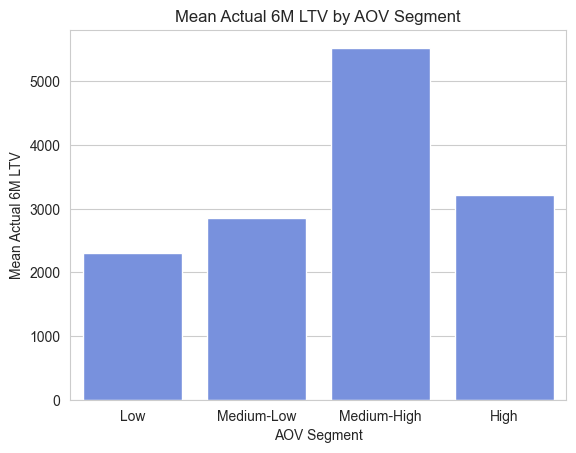

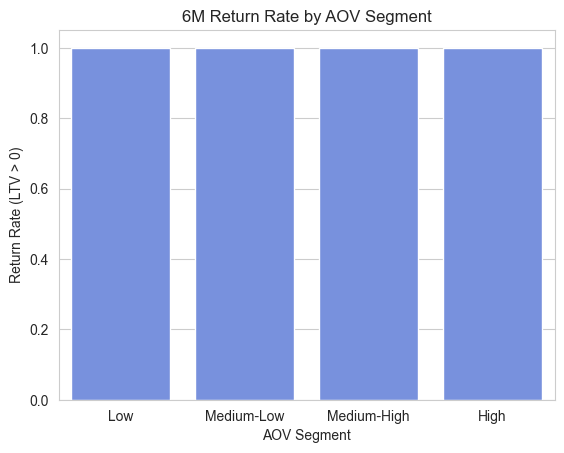

In [209]:

# Plot mean LTV by AOV segment
sns.barplot(x=segment, y='mean_actual_LTV_6m', data=segment_stats, order=['Low','Medium-Low','Medium-High','High'])
plt.title('Mean Actual 6M LTV by AOV Segment')
plt.ylabel('Mean Actual 6M LTV')
plt.xlabel('AOV Segment')
plt.show()

# Plot return rate by AOV segment
sns.barplot(x=segment, y='return_rate', data=segment_stats, order=['Low','Medium-Low','Medium-High','High'])
plt.title('6M Return Rate by AOV Segment')
plt.ylabel('Return Rate (LTV > 0)')
plt.xlabel('AOV Segment')
plt.show()

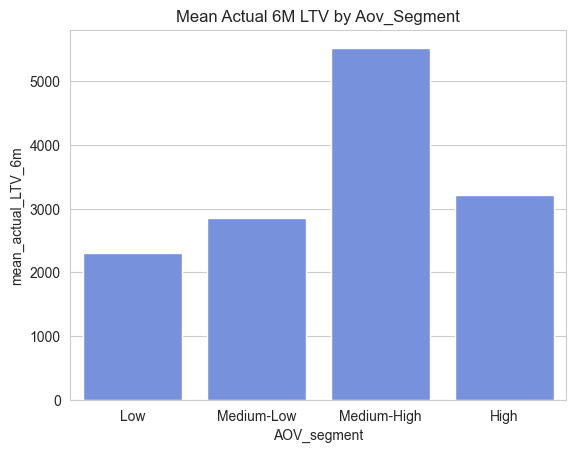

In [210]:
# Barplots of Mean/Median LTV by Segment
sns.barplot(x=segment, y='mean_actual_LTV_6m', data=segment_stats)
plt.title(f"Mean Actual 6M LTV by {segment.title()}")
plt.show()

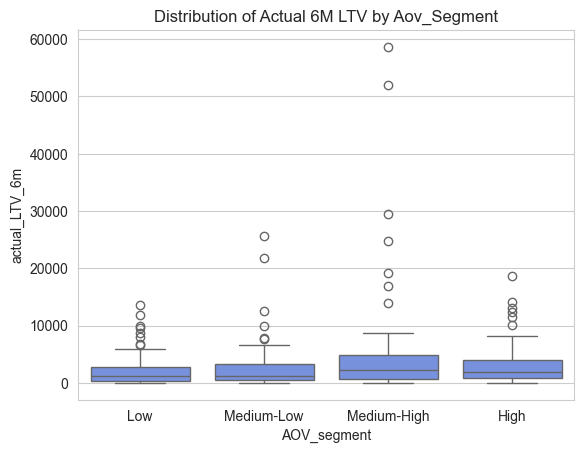

In [211]:
sns.boxplot(x=segment, y='actual_LTV_6m', data=aov_segment_df)
plt.title(f"Distribution of Actual 6M LTV by {segment.title()}")
plt.show()

In [212]:
print(aov_segment_df.columns)

Index(['customer_id', 'actual_LTV_6m', 'AOV', 'gender', 'location', 'tenure_months', 'AOV_segment'], dtype='object')


In [213]:
# Create tenure bins
aov_segment_df['tenure_bin'] = pd.cut(
    aov_segment_df['tenure_months'], 
    bins=[0,12,24,36,48,60,100],
    right=False,
    labels=['0-12','12-24','24-36','36-48','48-60','60+']
)

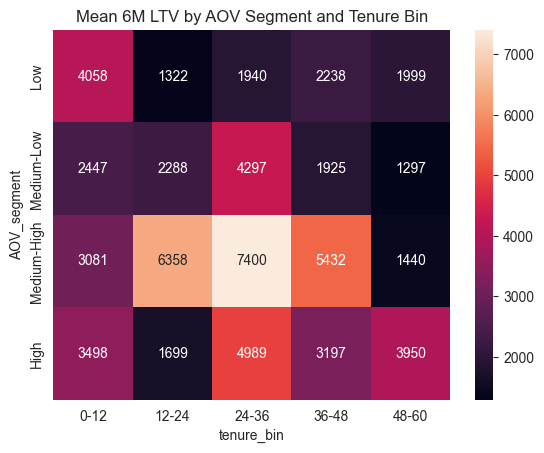

In [214]:
pivot = aov_segment_df.pivot_table(
    index='AOV_segment', columns='tenure_bin', values='actual_LTV_6m', aggfunc='mean'
)

sns.heatmap(pivot, annot=True, fmt='.0f')
plt.title("Mean 6M LTV by AOV Segment and Tenure Bin")
plt.show()

Summary table

|             | 0-12 | 12-24 | 24-36 | 36-48 | 48-60 |
| ----------- | ---- | ----- | ----- | ----- | ----- |
| Low         | 4058 | 1322  | 1940  | 2238  | 1999  |
| Medium-Low  | 2447 | 2288  | 4297  | 1925  | 1297  |
| Medium-High | 3081 | 6358  | 7400  | 5432  | 1440  |
| High        | 3498 | 1699  | 4989  | 3197  | 3950  |


Business Insights
“Medium-High AOV, 24-36 months tenure” is our superstar group (highest mean LTV).

Low tenure often means lower LTV, except for some segments.

Not always true that High AOV → High LTV for every tenure bin. Check for churn or discount-seeking.

You can target the highest cells for premium marketing,
or investigate why some segments underperform.

Customer Count per Segment 

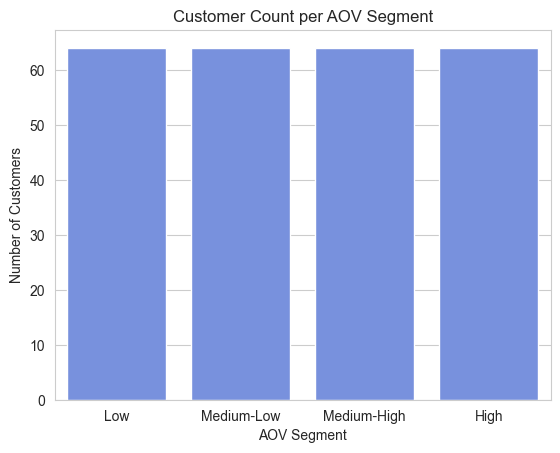

In [215]:

sns.countplot(x='AOV_segment', data=aov_segment_df, order=['Low', 'Medium-Low', 'Medium-High', 'High'])
plt.title('Customer Count per AOV Segment')
plt.ylabel('Number of Customers')
plt.xlabel('AOV Segment')
plt.show()

Cumulative Revenue Curve by Segment (“Whale Curve”)

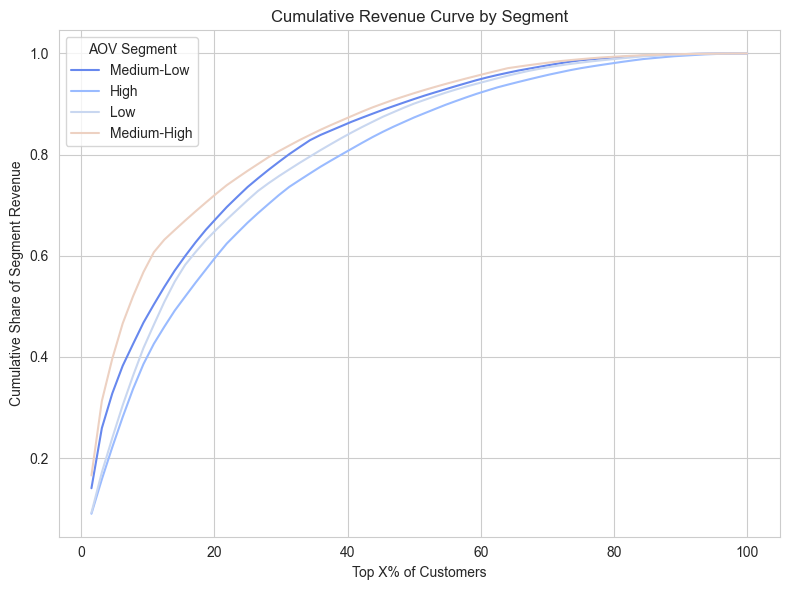

In [216]:

plt.figure(figsize=(8, 6))
for seg in aov_segment_df['AOV_segment'].unique():
    sub = aov_segment_df[aov_segment_df['AOV_segment'] == seg].copy()
    # Sort customers by actual LTV
    sub = sub.sort_values('actual_LTV_6m', ascending=False)
    # Cumulative revenue share
    cumsum = sub['actual_LTV_6m'].cumsum() / sub['actual_LTV_6m'].sum()
    # Customer percentiles
    pct = np.arange(1, len(sub) + 1) / len(sub)
    plt.plot(pct * 100, cumsum, label=seg)
plt.title('Cumulative Revenue Curve by Segment')
plt.xlabel('Top X% of Customers')
plt.ylabel('Cumulative Share of Segment Revenue')
plt.legend(title='AOV Segment')
plt.tight_layout()
plt.show()

X-axis: Top % of customers in each AOV segment (sorted by LTV, left = highest LTV customers)

Y-axis: Cumulative share of total segment revenue contributed by those top customers

Interpretation & Insights
Steepness of the curve:

If the curve rises quickly (especially for the red Medium-High segment), a small % of customers drive a large share of the revenue (“whale effect”).

For example, in the Medium-High AOV segment, the top ~20% of customers contribute well over 60% of the segment’s total revenue.

Flatter curves (like High or Low) indicate revenue is spread more evenly across customers.

Comparison between segments:

Medium-High AOV (red): Most “whale-heavy”—a few customers are extremely valuable.

High AOV (orange): More evenly distributed revenue; no single “whale” effect.

Medium-Low/Low: Somewhere in between; still some concentration at the top.

Actionable takeaways:

Target your “whales”: Medium-High AOV customers at the top percentiles deserve special attention (retention, upsell, loyalty).

For segments with flatter curves, broad-based offers or mass campaigns may be more appropriate.

Typical Observations:
In most e-commerce datasets, top 20% of customers can deliver 60–80% of revenue (“Pareto principle”).

You can quantify this by reading off the Y-axis at X=20 for each segment.

In [217]:
whale_stats = []

for seg in aov_segment_df['AOV_segment'].unique():
    sub = aov_segment_df[aov_segment_df['AOV_segment'] == seg].copy()
    sub = sub.sort_values('actual_LTV_6m', ascending=False)
    n = len(sub)
    # Top 10%
    top_10 = int(np.ceil(0.10 * n))
    rev_10pct = sub['actual_LTV_6m'].iloc[:top_10].sum() / sub['actual_LTV_6m'].sum()
    # Top 20%
    top_20 = int(np.ceil(0.20 * n))
    rev_20pct = sub['actual_LTV_6m'].iloc[:top_20].sum() / sub['actual_LTV_6m'].sum()
    whale_stats.append({'AOV_segment': seg, 'Revenue_top10%': rev_10pct, 'Revenue_top20%': rev_20pct})

whale_df = pd.DataFrame(whale_stats)
# Format as percentages
whale_df['Revenue_top10%'] = (whale_df['Revenue_top10%'] * 100).round(1)
whale_df['Revenue_top20%'] = (whale_df['Revenue_top20%'] * 100).round(1)

print(whale_df)

   AOV_segment  Revenue_top10%  Revenue_top20%
0   Medium-Low            50.4            67.4
1         High            42.6            59.9
2          Low            46.4            65.2
3  Medium-High            60.7            72.3


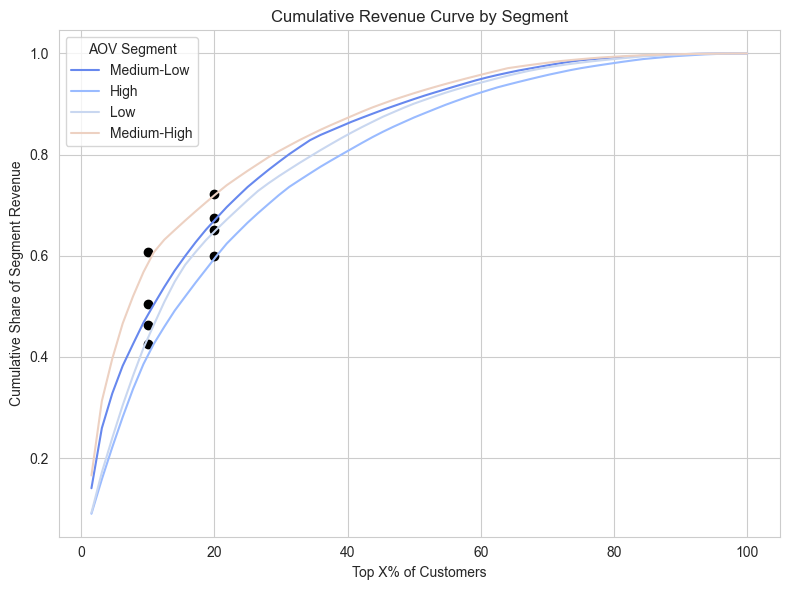

In [218]:
plt.figure(figsize=(8, 6))
for seg in aov_segment_df['AOV_segment'].unique():
    sub = aov_segment_df[aov_segment_df['AOV_segment'] == seg].copy()
    sub = sub.sort_values('actual_LTV_6m', ascending=False)
    cumsum = sub['actual_LTV_6m'].cumsum() / sub['actual_LTV_6m'].sum()
    pct = np.arange(1, len(sub) + 1) / len(sub)
    plt.plot(pct * 100, cumsum, label=seg)
    # Add dots at 10% and 20%
    n = len(sub)
    idx_10 = int(np.ceil(0.10 * n)) - 1
    idx_20 = int(np.ceil(0.20 * n)) - 1
    plt.scatter(10, cumsum.iloc[idx_10], color='black', marker='o')
    plt.scatter(20, cumsum.iloc[idx_20], color='black', marker='o')

plt.title('Cumulative Revenue Curve by Segment')
plt.xlabel('Top X% of Customers')
plt.ylabel('Cumulative Share of Segment Revenue')
plt.legend(title='AOV Segment')
plt.tight_layout()
plt.show()

In [219]:
# Define LTV buckets 

bins = [0, 1, 500, 2000, np.inf]  # [0, $1), [$1–500), [$500–2000), [$2000+)
labels = ['$0', '$1–500', '$500–2k', '$2k+']

aov_segment_df['LTV_bucket'] = pd.cut(aov_segment_df['actual_LTV_6m'], bins=bins, labels=labels, right=False)

In [220]:
# Count customers by AOV segment and LTV bucket
stacked = (
    aov_segment_df
    .groupby(['AOV_segment', 'LTV_bucket'])['customer_id']
    .count()
    .reset_index()
    .pivot(index='AOV_segment', columns='LTV_bucket', values='customer_id')
    .fillna(0)
)

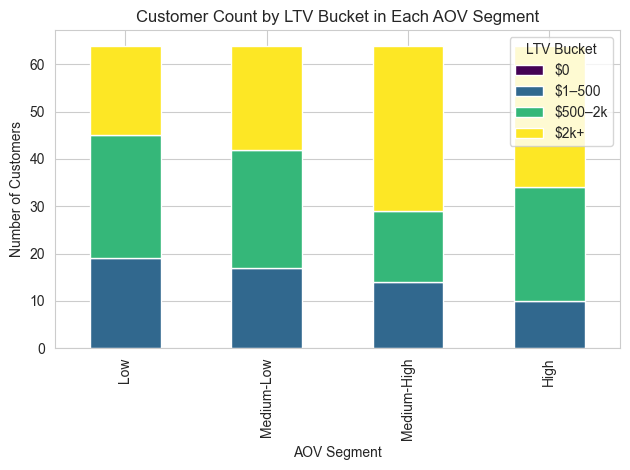

In [221]:

# Plot
stacked[labels].plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Customer Count by LTV Bucket in Each AOV Segment')
plt.xlabel('AOV Segment')
plt.ylabel('Number of Customers')
plt.legend(title='LTV Bucket')
plt.tight_layout()
plt.show()

# Step 8 — Incrementality (Lift)

<a id='step-8-incrementality-lift'></a>

In [ ]:
# ==============================================
# Step 8 — Incrementality (Lift) for Postgres
# ==============================================
# Creates these tables in Postgres (schema = my_schema):
#   my_schema.actuals_panel_category_month
#   my_schema.i_discount_dose_response_twfe
#   my_schema.i_att_treated_twfe
#   my_schema.i_gap_diagnostic_by_month
#   my_schema.i_incremental_by_month
#
# Notes
# - "i_*" tables contain causal (incrementality) estimates or diagnostics.
# - "actuals_*" tables are descriptive aggregates (what happened).
# - Safe to run repeatedly; tables are REPLACED each time.
# ----------------------------------------------

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

from dotenv import dotenv_values
from sqlalchemy import create_engine, text, types
import statsmodels.formula.api as smf

# ---------- 0) Connect & Load from Postgres ----------
config = dotenv_values()  # expects POSTGRES_* keys in .env

pg_user   = config['POSTGRES_USER']
pg_host   = config['POSTGRES_HOST']
pg_port   = config['POSTGRES_PORT']
pg_db     = config['POSTGRES_DB']
pg_schema = config['POSTGRES_SCHEMA']
pg_pass   = config['POSTGRES_PASS']

url = f'postgresql://{pg_user}:{pg_pass}@{pg_host}:{pg_port}/{pg_db}'
engine = create_engine(url, echo=False)

my_schema = "team_3"  

# Ensure connections use your schema first
with engine.begin() as conn:
    conn.execute(text(f"SET search_path TO {my_schema}, public;"))

# Pull marts
mart_all_data = pd.read_sql(
    f"SELECT * FROM {my_schema}.mart_all_data;",
    engine,
    parse_dates=['transaction_date']
)

# discount mart 
try:
    mart_discount_coupon = pd.read_sql(
        f"SELECT * FROM {my_schema}.mart_discount_coupon;",
        engine
    )
except Exception:
    mart_discount_coupon = None



In [ ]:
# ---------- 1) Clean & ensure fields ----------
need_cols = ['transaction_date','product_category','transaction_id','quantity','avg_price','delivery_charges']
missing = [c for c in need_cols if c not in mart_all_data.columns]
if missing:
    raise KeyError(f"Missing required columns in mart_all_data: {missing}")

# Net revenue (ex-GST) 
if 'net_revenue' not in mart_all_data.columns:
    gross = mart_all_data['quantity'] * mart_all_data['avg_price']
    mart_all_data['net_revenue'] = gross + mart_all_data['delivery_charges']

# Month keys
mart_all_data['transaction_date'] = pd.to_datetime(mart_all_data['transaction_date'])
mart_all_data['month_num'] = mart_all_data['transaction_date'].dt.month
mart_all_data['month_str'] = mart_all_data['transaction_date'].dt.strftime('%Y-%m')

# If discount% missing/mostly null, enrich from coupon mart (category×month)
discount_missing = ('discount_pct' not in mart_all_data.columns) or (mart_all_data['discount_pct'].isna().mean() > 0.9)
if discount_missing and mart_discount_coupon is not None and not mart_discount_coupon.empty:
    disc = mart_discount_coupon.copy()
    if 'month_num' not in disc.columns:
        def _month_to_num(s):
            s = str(s).strip().lower()[:3]
            m = {'jan':1,'feb':2,'mar':3,'apr':4,'may':5,'jun':6,'jul':7,'aug':8,'sep':9,'oct':10,'nov':11,'dec':12}
            return m.get(s, np.nan)
        # Try to map from a 'month' like 'Jan'
        cand = [c for c in disc.columns if 'month' in c.lower()]
        if not cand:
            raise KeyError("No month field to derive month_num in mart_discount_coupon.")
        disc['month_num'] = disc[cand[0]].apply(_month_to_num)

    keep = [c for c in ['month_num','product_category','discount_pct'] if c in disc.columns]
    disc = disc[keep].drop_duplicates()

    mart_all_data = mart_all_data.merge(
        disc, on=['month_num','product_category'], how='left'
    )

# Fill any residual missing discount% with 0
if 'discount_pct' not in mart_all_data.columns:
    mart_all_data['discount_pct'] = 0.0
else:
    mart_all_data['discount_pct'] = mart_all_data['discount_pct'].fillna(0.0)

# ---------- 2) Build category×month panel (ACTUALS) ----------
panel = (
    mart_all_data
      .groupby(['product_category','month_str','month_num'], as_index=False)
      .agg(
          revenue=('net_revenue','sum'),
          orders =('transaction_id','nunique')
      )
      .sort_values(['product_category','month_num'])
)

# Attach mean discount% per category×month
disc_panel = (
    mart_all_data
      .groupby(['product_category','month_str'], as_index=False)['discount_pct']
      .mean()
)
panel = panel.merge(disc_panel, on=['product_category','month_str'], how='left')
panel['discount_pct'] = panel['discount_pct'].fillna(0.0)
panel['treated'] = (panel['discount_pct'] > 0).astype(int)

# ---------- 3) TWFE regression — dose-response (INCREMENTALITY / i_) ----------
# revenue_it = α_i + γ_t + β * discount_pct_it + ε_it
mod_dose = smf.ols(
    "revenue ~ discount_pct + C(product_category) + C(month_str)",
    data=panel
).fit(cov_type="cluster", cov_kwds={'groups': panel['product_category']})

i_beta = float(mod_dose.params.get('discount_pct', np.nan))
i_ci_low, i_ci_high = [float(x) for x in mod_dose.conf_int().loc['discount_pct'].values]

i_dose_df = pd.DataFrame({
    'i_discount_effect_per_1pp': [i_beta],
    'ci_low'                   : [i_ci_low],
    'ci_high'                  : [i_ci_high]
})

# ---------- 4) TWFE regression — binary ATT (INCREMENTALITY / i_) ----------
# revenue_it = α_i + γ_t + δ * treated_it + ε_it
mod_bin = smf.ols(
    "revenue ~ treated + C(product_category) + C(month_str)",
    data=panel
).fit(cov_type="cluster", cov_kwds={'groups': panel['product_category']})

i_delta = float(mod_bin.params.get('treated', np.nan))
i2_ci_low, i2_ci_high = [float(x) for x in mod_bin.conf_int().loc['treated'].values]

i_att_df = pd.DataFrame({
    'i_att_treated': [i_delta],
    'ci_low'       : [i2_ci_low],
    'ci_high'      : [i2_ci_high]
})

# ---------- 5) Monthly treated–control gap (diagnostic, not causal) ----------
i_gap = (
    panel.groupby(['month_str','treated'])['revenue']
         .mean()
         .unstack()
         .rename(columns={0:'control_mean', 1:'treated_mean'})
         .reset_index()
         .sort_values('month_str')
)
i_gap['i_treated_control_gap_diag'] = i_gap['treated_mean'] - i_gap['control_mean']

# ---------- 6) Estimated incremental $ by month (INCREMENTALITY / i_) ----------
# Use β × (avg treated discount in that month)
by_month_disc = (
    panel[panel['treated']==1]
    .groupby('month_str')['discount_pct']
    .mean()
    .reindex(i_gap['month_str'])
)
i_inc_month = (i_beta * by_month_disc).rename('i_incremental_revenue_est').reset_index()

# ---------- 7) Save to Postgres (REPLACE) ----------
# Dtypes for clean schema
panel_dtypes = {
    'product_category': types.VARCHAR(80),
    'month_str'       : types.VARCHAR(7),
    'month_num'       : types.Integer(),
    'revenue'         : types.Float(),
    'orders'          : types.Integer(),
    'discount_pct'    : types.Float(),
    'treated'         : types.Integer(),
}

with engine.begin() as conn:
    conn.execute(text(f"SET search_path TO {my_schema}, public;"))

    panel.to_sql(
        'actuals_panel_category_month', engine, schema=my_schema,
        if_exists='replace', index=False, dtype=panel_dtypes
    )

    i_dose_df.to_sql(
        'i_discount_dose_response_twfe', engine, schema=my_schema,
        if_exists='replace', index=False,
        dtype={'i_discount_effect_per_1pp': types.Float(),
               'ci_low': types.Float(), 'ci_high': types.Float()}
    )

    i_att_df.to_sql(
        'i_att_treated_twfe', engine, schema=my_schema,
        if_exists='replace', index=False,
        dtype={'i_att_treated': types.Float(),
               'ci_low': types.Float(), 'ci_high': types.Float()}
    )

    i_gap.to_sql(
        'i_gap_diagnostic_by_month', engine, schema=my_schema,
        if_exists='replace', index=False,
        dtype={'month_str': types.VARCHAR(7),
               'control_mean': types.Float(),
               'treated_mean': types.Float(),
               'i_treated_control_gap_diag': types.Float()}
    )

    i_inc_month.to_sql(
        'i_incremental_by_month', engine, schema=my_schema,
        if_exists='replace', index=False,
        dtype={'month_str': types.VARCHAR(7),
               'i_incremental_revenue_est': types.Float()}
    )

# ---------- 8) add helpful indexes ----------
with engine.begin() as conn:
    conn.execute(text(f"""
        DO $$
        BEGIN
            IF NOT EXISTS (
                SELECT 1 FROM pg_class c
                JOIN pg_namespace n ON n.oid = c.relnamespace
                WHERE c.relname = 'idx_panel_category_month'
                AND   n.nspname = '{my_schema}'
            ) THEN
                CREATE INDEX idx_panel_category_month
                ON {my_schema}.actuals_panel_category_month (product_category, month_str);
            END IF;
        END $$;
    """))

print("✓ Exported to Postgres tables in schema:", my_schema)
print("   - actuals_panel_category_month")
print("   - i_discount_dose_response_twfe")
print("   - i_att_treated_twfe")
print("   - i_gap_diagnostic_by_month")
print("   - i_incremental_by_month")


✓ Exported to Postgres tables in schema: team_3
   - actuals_panel_category_month
   - i_discount_dose_response_twfe
   - i_att_treated_twfe
   - i_gap_diagnostic_by_month
   - i_incremental_by_month


In [ ]:
# ==========================================================
# Incrementality (I) Visualizations from Postgres
# - Produces 5 figures:
#   Fig1  I: Discount dose–response (β) with 95% CI
#   Fig2  I: ATT for treated months (δ) with 95% CI
#   Fig3  Diagnostic: Treated vs Control mean revenue by month + gap
#   Fig4  I: Incremental revenue by month (+ cumulative I)
#   Fig5  Actuals: Monthly revenue for top product categories
# ==========================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dotenv import dotenv_values
from sqlalchemy import create_engine, text

# ---------- Connect & read ----------
config = dotenv_values()
url = f"postgresql://{config['POSTGRES_USER']}:{config['POSTGRES_PASS']}@" \
      f"{config['POSTGRES_HOST']}:{config['POSTGRES_PORT']}/{config['POSTGRES_DB']}"
engine = create_engine(url, echo=False)

my_schema = "team_3"  

with engine.begin() as conn:
    conn.execute(text(f"SET search_path TO {my_schema}, public;"))

panel      = pd.read_sql(f"SELECT * FROM {my_schema}.actuals_panel_category_month;", engine)
i_dose     = pd.read_sql(f"SELECT * FROM {my_schema}.i_discount_dose_response_twfe;", engine)
i_att      = pd.read_sql(f"SELECT * FROM {my_schema}.i_att_treated_twfe;", engine)
i_gap      = pd.read_sql(f"SELECT * FROM {my_schema}.i_gap_diagnostic_by_month;", engine)
i_by_month = pd.read_sql(f"SELECT * FROM {my_schema}.i_incremental_by_month;", engine)

# ---------- Utilities ----------
def _month_to_dt(s):
    # "YYYY-MM" -> datetime for correct sorting
    return pd.to_datetime(s + "-01")

def _add_sig_text(ax, lo, hi, y, x=0, offset=0.02):
    sig = (lo * hi) > 0
    txt = "significant" if sig else "n.s."
    ax.text(x, y + (ax.get_ylim()[1]-ax.get_ylim()[0])*offset, txt,
            ha="center", va="bottom", fontsize=10,
            color=("tab:green" if sig else "tab:gray"))



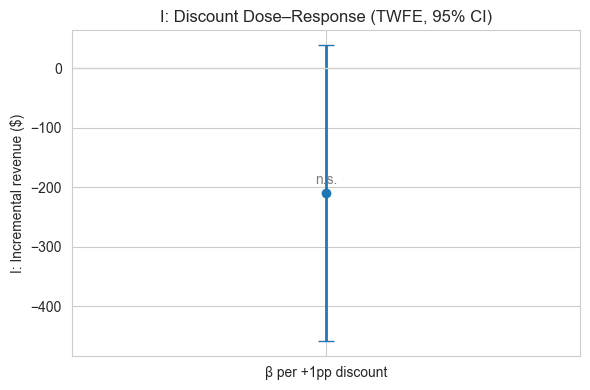

In [282]:

# ==========================================================
# Fig 1 — I: Discount dose–response (β per +1pp discount)
# ==========================================================
fig, ax = plt.subplots(figsize=(6,4))
beta = float(i_dose['i_discount_effect_per_1pp'].iloc[0])
lo, hi = float(i_dose['ci_low'].iloc[0]), float(i_dose['ci_high'].iloc[0])

ax.errorbar([0], [beta],
            yerr=[[beta - lo], [hi - beta]],
            fmt='o', capsize=6, lw=2, color='tab:blue')
ax.axhline(0, color='lightgray', lw=1)
ax.set_xlim(-0.75, 0.75)
ax.set_xticks([0])
ax.set_xticklabels(['β per +1pp discount'])
ax.set_ylabel('I: Incremental revenue ($)')
ax.set_title('I: Discount Dose–Response (TWFE, 95% CI)')
_add_sig_text(ax, lo, hi, beta)
plt.tight_layout()
plt.show()



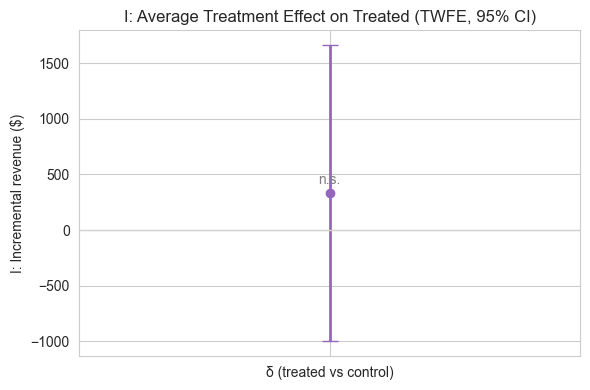

In [283]:
# ==========================================================
# Fig 2 — I: ATT for treated months (δ)
# ==========================================================
fig, ax = plt.subplots(figsize=(6,4))
delta = float(i_att['i_att_treated'].iloc[0])
lo2, hi2 = float(i_att['ci_low'].iloc[0]), float(i_att['ci_high'].iloc[0])

ax.errorbar([0], [delta],
            yerr=[[delta - lo2], [hi2 - delta]],
            fmt='o', capsize=6, lw=2, color='tab:purple')
ax.axhline(0, color='lightgray', lw=1)
ax.set_xlim(-0.75, 0.75)
ax.set_xticks([0])
ax.set_xticklabels(['δ (treated vs control)'])
ax.set_ylabel('I: Incremental revenue ($)')
ax.set_title('I: Average Treatment Effect on Treated (TWFE, 95% CI)')
_add_sig_text(ax, lo2, hi2, delta)
plt.tight_layout()
plt.show()



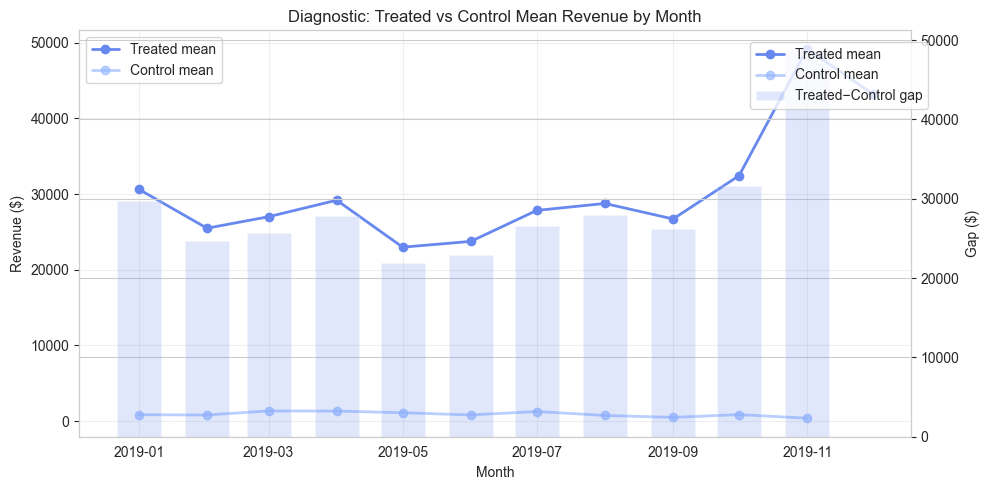

In [284]:
# ==========================================================
# Fig 3 — Diagnostic: treated vs control mean revenue by month + gap
# (Gap is descriptive; not causal. I-labeled items are reserved for causal.)
# ==========================================================
g = i_gap.copy()
g['dt'] = g['month_str'].apply(_month_to_dt)
g = g.sort_values('dt')

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(g['dt'], g['treated_mean'], marker='o', label='Treated mean', lw=2)
ax.plot(g['dt'], g['control_mean'], marker='o', label='Control mean', lw=2, alpha=0.7)
ax.set_title('Diagnostic: Treated vs Control Mean Revenue by Month')
ax.set_ylabel('Revenue ($)')
ax.set_xlabel('Month')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)

# Gap on secondary axis
ax2 = ax.twinx()
ax2.bar(g['dt'], g['i_treated_control_gap_diag'], width=20, alpha=0.2, label='Treated−Control gap')
ax2.set_ylabel('Gap ($)')
fig.legend(loc='upper right', bbox_to_anchor=(0.94, 0.92))
plt.tight_layout()
plt.show()



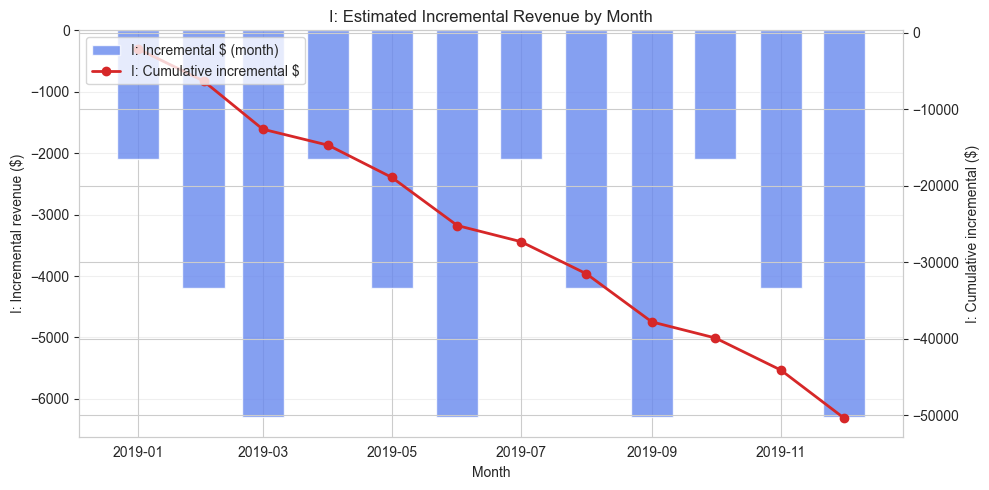

In [285]:
# ==========================================================
# Fig 4 — I: Incremental revenue by month + cumulative I
# ==========================================================
i_m = i_by_month.copy()
i_m['dt'] = i_m['month_str'].apply(_month_to_dt)
i_m = i_m.sort_values('dt')
i_m['i_incremental_revenue_est'] = i_m['i_incremental_revenue_est'].fillna(0.0)
i_m['i_cum'] = i_m['i_incremental_revenue_est'].cumsum()

fig, ax = plt.subplots(figsize=(10,5))
ax.bar(i_m['dt'], i_m['i_incremental_revenue_est'], width=20, alpha=0.8, label='I: Incremental $ (month)')
ax.set_title('I: Estimated Incremental Revenue by Month')
ax.set_ylabel('I: Incremental revenue ($)')
ax.set_xlabel('Month')
ax.grid(True, axis='y', alpha=0.3)

# Cumulative on secondary axis
ax2 = ax.twinx()
ax2.plot(i_m['dt'], i_m['i_cum'], marker='o', lw=2, label='I: Cumulative incremental $', color='tab:red')
ax2.set_ylabel('I: Cumulative incremental ($)')

# Combined legend
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines+lines2, labels+labels2, loc='upper left')
plt.tight_layout()
plt.show()



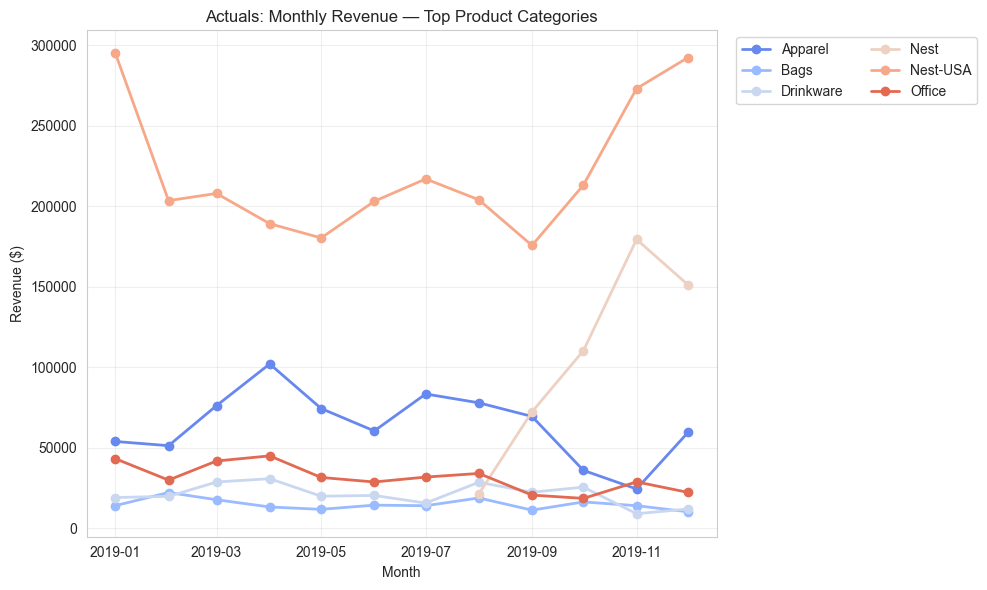

In [286]:
# ==========================================================
# Fig 5 — Actuals: top categories revenue over time
# (Non-causal; for context.)
# ==========================================================
p = panel.copy()
p['dt'] = p['month_str'].apply(_month_to_dt)

top_cats = (
    p.groupby('product_category')['revenue']
     .sum()
     .sort_values(ascending=False)
     .head(6).index
)

sub = p[p['product_category'].isin(top_cats)]
sub = sub.sort_values(['product_category','dt'])

fig, ax = plt.subplots(figsize=(10,6))
for cat, grp in sub.groupby('product_category'):
    ax.plot(grp['dt'], grp['revenue'], marker='o', lw=2, label=cat)

ax.set_title('Actuals: Monthly Revenue — Top Product Categories')
ax.set_ylabel('Revenue ($)')
ax.set_xlabel('Month')
ax.grid(True, alpha=0.3)
ax.legend(ncol=2, bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()


# Findings

**What we measured (I = incremental):**
- **I:ATE (TWFE)** was not statistically significant overall (CI crossed 0).
- **I:$ by month** was mostly negative; cumulative I:$ ≈ –$50k.
- Diagnostics suggest **seasonality & mix** (Q4 + category skew) violate clean parallel trends.

**What it means for the business:**
- Program-level coupons look **over-discounted**: we give up margin on many customers who would have purchased anyway.
- There are likely **segments where coupons *are* incremental** — we need to measure within comparable strata.

**What we’ll do now:**
1) **Measure I:** *within* **(category × location × month)** cells (or synthetic control), then aggregate up.
2) Move from **I:revenue → I:gross profit (margin-rate knob) → I:net profit after coupon budget**.
3) **Guardrails & targeting:**
   - Only run coupons where **I:net profit > 0** and **I:ROAS (incremental) > 1**.
   - Add a **pause list** for segments with negative trailing I:net profit.
4) **Calibrate quarterly** with small geo/user holdouts; use uplift models to target *high* incremental propensity cohorts (reactivation, low tenure).

I: Dashboard — monthly (head)
      month      i_arpu  treated_cust     i_revenue  coupon_budget  i_gross_profit  i_net_profit_after_coupons go_flag  i_cum_revenue  i_cum_net_profit
0   2019-01  343.087935           188  64500.531710      12971.820    32250.265855                19278.445855      GO   64500.531710      19278.445855
1   2019-02  430.748672           101  43505.615867      19423.334    21752.807933                 2329.473933      GO  108006.147577      21607.919788
2   2019-03  254.703261           192  48903.026169      33966.564    24451.513085                -9515.050915   NO-GO  156909.173746      12092.868873
3   2019-04  441.707108           193  85249.471803      13440.403    42624.735902                29184.332902      GO  242158.645549      41277.201774
4   2019-05  245.797467           170  41785.569392      18889.306    20892.784696                 2003.478696      GO  283944.214940      43280.680470
5   2019-06  190.445155           234  44564.166289      3

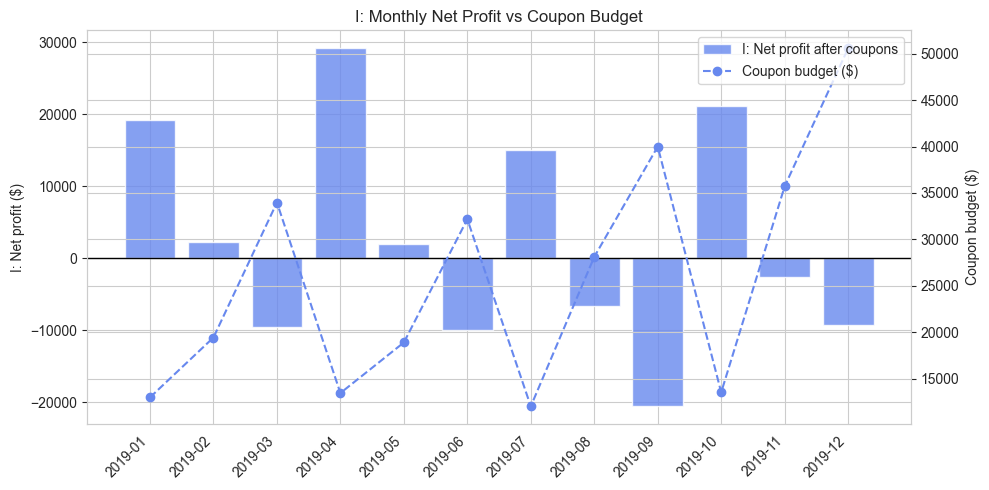

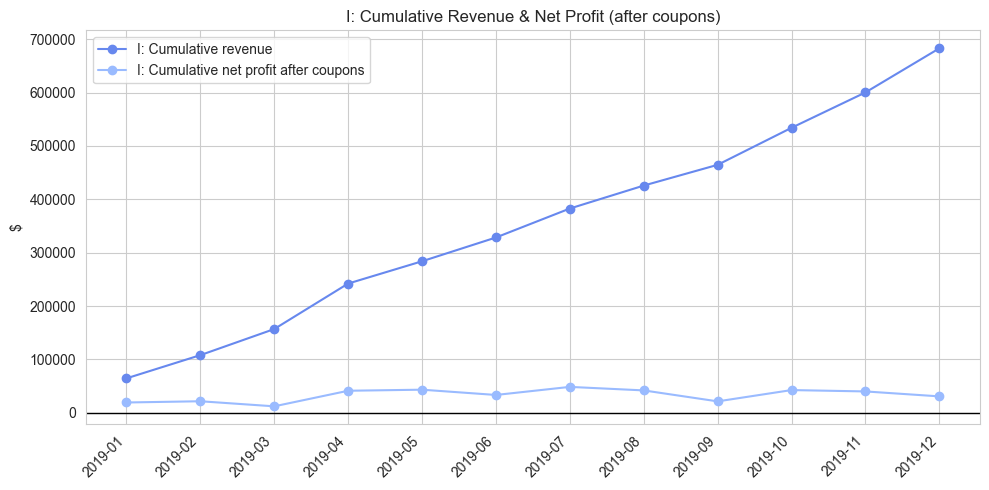

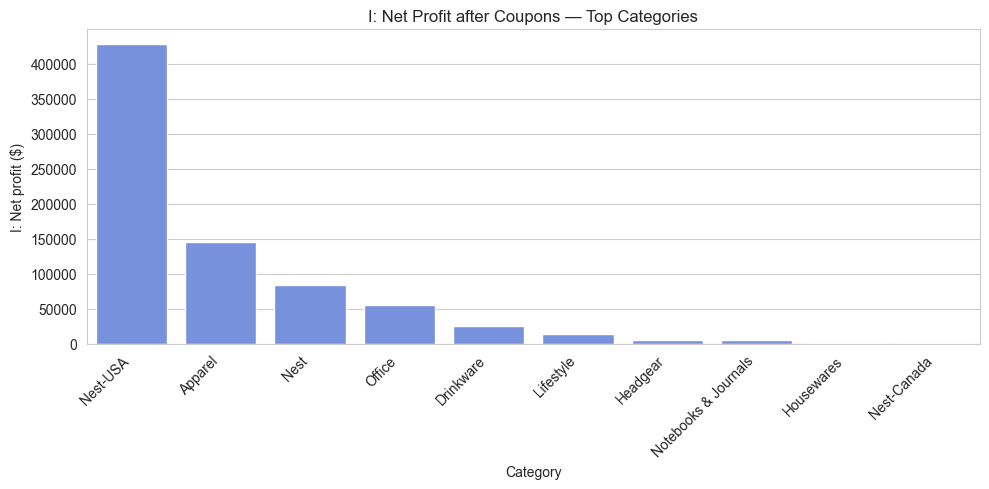

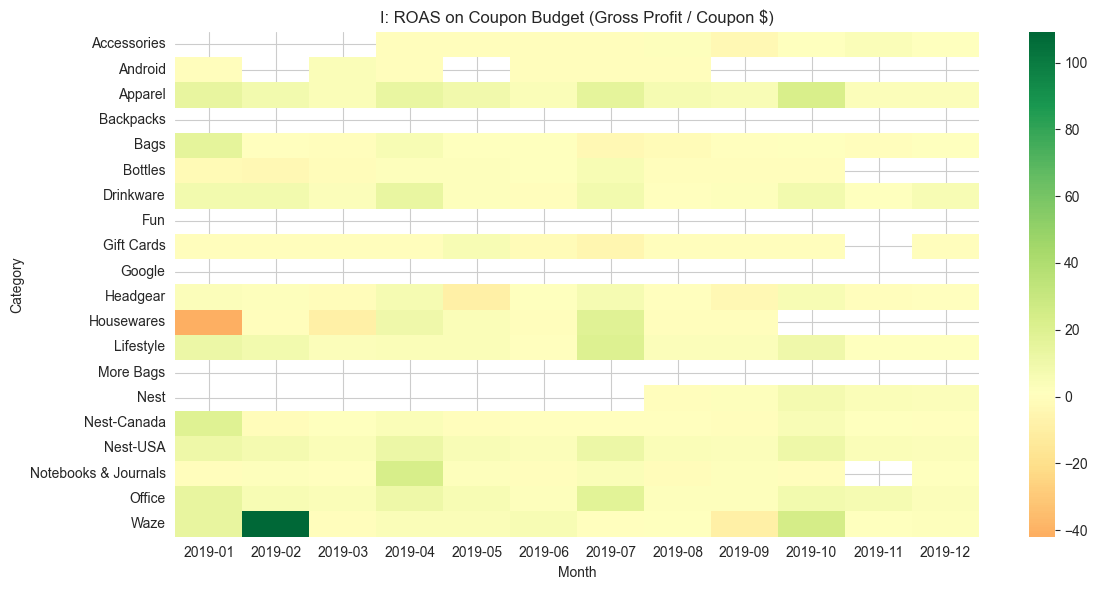

In [287]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# Parameters 
# -----------------------------
MARGIN_RATE = 0.50   # gross margin % used to convert I:revenue → I:gross profit
EXPORT_TO_POSTGRES = False  # set True to push summary tables to your DB


df = mart_all_data.copy()
df['transaction_date'] = pd.to_datetime(df['transaction_date'])
df['month'] = df['transaction_date'].dt.to_period('M').astype(str)

# Revenue fallback (if not present)
if 'revenue' not in df.columns:
    df['revenue'] = df['quantity'] * df['avg_price'] + df.get('delivery_charges', 0)

# Applied discount only when coupon was actually used
# (your Discount_Coupon table gives % availability; budget should count only redeemed dollars)
df['gross_sales'] = df['quantity'] * df['avg_price']
df['coupon_used_flag'] = (df['coupon_status'] == 'Used').astype(int)
df['applied_discount_pct'] = np.where(df['coupon_status'] == 'Used', df['discount_pct'].fillna(0), 0.0)
df['discount_dollars_used'] = df['gross_sales'] * (df['applied_discount_pct'] / 100.0)

# -----------------------------
# 1) Within-cell DID: estimate I:revenue at (category × location × month)
#    - Treated = customers who used a coupon in that month & cell
#    - Control = customers in same cell & month who did not use a coupon
#    - Outcome = mean revenue per customer (ARPU-style), to dampen ticket-count differences
# -----------------------------
# Build a per-customer, per-month revenue and treatment indicator within cell
keys = ['product_category', 'customer_location', 'month']

cust_month = (
    df.groupby(keys + ['customer_id'])
      .agg(revenue=('revenue', 'sum'),
           used_coupon=('coupon_used_flag','max'),
           discount_budget=('discount_dollars_used','sum'))
      .reset_index()
)

# Aggregate within cell × month: means for treated / control and sample sizes
cell_month = (
    cust_month.groupby(keys + ['used_coupon'])
              .agg(arpu=('revenue','mean'),
                   n=('customer_id','nunique'),
                   budget=('discount_budget','sum'))
              .reset_index()
)

# Pivot to get treated/control side-by-side
pivot = cell_month.pivot_table(index=keys, columns='used_coupon',
                               values=['arpu','n','budget'], fill_value=0)
# Flatten columns
pivot.columns = [f"{a}_{'treated' if b==1 else 'control'}" for a,b in pivot.columns]
pivot = pivot.reset_index()

# I:ARPU per cell-month = treated mean – control mean (same cell)
pivot['i_arpu_cell'] = pivot['arpu_treated'] - pivot['arpu_control']

# Weight by exposure size for aggregation (you can also try harmonic mean or min(n_t, n_c))
pivot['w'] = np.minimum(pivot['n_treated'].replace(0, np.nan),
                        pivot['n_control'].replace(0, np.nan))
pivot['w'] = pivot['w'].fillna(0)

# Summaries by month
i_by_month = (
    pivot.groupby('month')
         .apply(lambda g: np.average(g['i_arpu_cell'], weights=g['w']) if g['w'].sum()>0 else 0)
         .rename('i_arpu')
         .reset_index()
)

# Convert I:ARPU to I:revenue by scaling with # of treated customers in each month
treated_counts = cust_month[cust_month['used_coupon']==1].groupby('month')['customer_id'].nunique().rename('treated_cust').reset_index()
i_by_month = i_by_month.merge(treated_counts, on='month', how='left').fillna({'treated_cust':0})
i_by_month['i_revenue'] = i_by_month['i_arpu'] * i_by_month['treated_cust']

# Coupon budget (actual dollars redeemed) by month
budget_by_month = df.groupby('month')['discount_dollars_used'].sum().rename('coupon_budget').reset_index()

# Roll everything together
dash_month = (
    i_by_month.merge(budget_by_month, on='month', how='left')
              .fillna({'coupon_budget':0})
              .sort_values('month')
)

# I:gross profit & I:net profit vs coupon budget
dash_month['i_gross_profit'] = MARGIN_RATE * dash_month['i_revenue']
dash_month['i_net_profit_after_coupons'] = dash_month['i_gross_profit'] - dash_month['coupon_budget']
dash_month['i_cum_revenue'] = dash_month['i_revenue'].cumsum()
dash_month['i_cum_net_profit'] = dash_month['i_net_profit_after_coupons'].cumsum()

# GO/NO-GO monthly flag
dash_month['go_flag'] = np.where((dash_month['i_revenue']>0) & (dash_month['i_net_profit_after_coupons']>0), 'GO', 'NO-GO')

print("I: Dashboard — monthly (head)")
display_cols = ['month','i_arpu','treated_cust','i_revenue','coupon_budget','i_gross_profit','i_net_profit_after_coupons','go_flag','i_cum_revenue','i_cum_net_profit']
print(dash_month[display_cols].head(12))

# -----------------------------
# 2) Segment summary (category, tenure, location)
# -----------------------------
# Tenure segment (quartiles)
if 'customer_tenure_months' in df.columns:
    q = df['customer_tenure_months'].quantile([.25,.5,.75]).values
    bins = [-np.inf, q[0], q[1], q[2], np.inf]
    labels = ['Tenure_Q1','Tenure_Q2','Tenure_Q3','Tenure_Q4']
    df['tenure_segment'] = pd.cut(df['customer_tenure_months'], bins=bins, labels=labels)
else:
    df['tenure_segment'] = 'Unknown'

# Build per (seg, month, customer) ARPU & treatment
seg_keys = ['product_category','tenure_segment','customer_location','month']
seg_cust = (
    df.groupby(seg_keys + ['customer_id'])
      .agg(revenue=('revenue','sum'),
           used_coupon=('coupon_used_flag','max'),
           budget=('discount_dollars_used','sum'))
      .reset_index()
)

seg_cell = (
    seg_cust.groupby(seg_keys + ['used_coupon'])
            .agg(arpu=('revenue','mean'),
                 n=('customer_id','nunique'),
                 budget=('budget','sum'))
            .reset_index()
)

seg_pivot = seg_cell.pivot_table(index=seg_keys, columns='used_coupon',
                                 values=['arpu','n','budget'], fill_value=0)
seg_pivot.columns = [f"{a}_{'treated' if b==1 else 'control'}" for a,b in seg_pivot.columns]
seg_pivot = seg_pivot.reset_index()
seg_pivot['i_arpu_cell'] = seg_pivot['arpu_treated'] - seg_pivot['arpu_control']
seg_pivot['w'] = np.minimum(seg_pivot['n_treated'].replace(0, np.nan),
                            seg_pivot['n_control'].replace(0, np.nan)).fillna(0)

# Segment-level yearly summary (weighted)
seg_summary = (
    seg_pivot.groupby(['product_category','tenure_segment','customer_location'])
             .apply(lambda g: pd.Series({
                 'i_arpu_w': np.average(g['i_arpu_cell'], weights=g['w']) if g['w'].sum()>0 else 0,
                 'treated_cust': seg_cust[(seg_cust['used_coupon']==1) &
                                          (seg_cust['product_category']==g.name[0]) &
                                          (seg_cust['tenure_segment']==g.name[1]) &
                                          (seg_cust['customer_location']==g.name[2])]['customer_id'].nunique(),
                 'coupon_budget': g['budget_treated'].sum()
             }))
             .reset_index()
)

seg_summary['i_revenue'] = seg_summary['i_arpu_w'] * seg_summary['treated_cust']
seg_summary['i_gross_profit'] = MARGIN_RATE * seg_summary['i_revenue']
seg_summary['i_net_profit_after_coupons'] = seg_summary['i_gross_profit'] - seg_summary['coupon_budget']
seg_summary['i_roas_on_coupons'] = np.where(seg_summary['coupon_budget']>0,
                                            seg_summary['i_gross_profit'] / seg_summary['coupon_budget'], np.nan)
seg_summary['go_flag'] = np.where((seg_summary['i_revenue']>0) & (seg_summary['i_net_profit_after_coupons']>0),
                                  'GO', 'NO-GO')

print("\nI: Segment summary (top 15 by |i_net_profit_after_coupons|)")
print(seg_summary.sort_values('i_net_profit_after_coupons').head(15))
print(seg_summary.sort_values('i_net_profit_after_coupons', ascending=False).head(15))

# -----------------------------
# 3) Visuals
# -----------------------------
sns.set_style("whitegrid")

# (A) Monthly I:net profit vs coupon budget
fig, ax1 = plt.subplots(figsize=(10,5))
ax1.bar(dash_month['month'], dash_month['i_net_profit_after_coupons'], alpha=0.8, label='I: Net profit after coupons')
ax1.axhline(0, color='black', linewidth=1)
ax1.set_ylabel('I: Net profit ($)')
ax1.set_title('I: Monthly Net Profit vs Coupon Budget')
plt.xticks(rotation=45, ha='right')

ax2 = ax1.twinx()
ax2.plot(dash_month['month'], dash_month['coupon_budget'], marker='o', linestyle='--', label='Coupon budget ($)')
ax2.set_ylabel('Coupon budget ($)')

lns1, _ = ax1.get_legend_handles_labels()
lns2, _ = ax2.get_legend_handles_labels()
ax2.legend(lns1+lns2, ['I: Net profit after coupons','Coupon budget ($)'], loc='upper right')
plt.tight_layout()
plt.show()

# (B) Cumulative I:revenue and I:net profit
fig, ax1 = plt.subplots(figsize=(10,5))
ax1.plot(dash_month['month'], dash_month['i_cum_revenue'], marker='o', label='I: Cumulative revenue')
ax1.plot(dash_month['month'], dash_month['i_cum_net_profit'], marker='o', label='I: Cumulative net profit after coupons')
ax1.axhline(0, color='black', linewidth=1)
ax1.set_title('I: Cumulative Revenue & Net Profit (after coupons)')
ax1.set_ylabel('$')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

# (C) Segment bar: I:net profit by category (top N)
topN = (seg_summary.groupby('product_category')['i_net_profit_after_coupons']
                  .sum()
                  .sort_values(ascending=False)
                  .head(10))
plt.figure(figsize=(10,5))
sns.barplot(x=topN.index, y=topN.values)
plt.title('I: Net Profit after Coupons — Top Categories')
plt.ylabel('I: Net profit ($)')
plt.xlabel('Category')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# (D) Heatmap: I:ROAS on coupon budget by category × month
roas_cell = (
    seg_pivot.groupby(['product_category','month'])
             .apply(lambda g: pd.Series({
                 'i_arpu_w': np.average(g['i_arpu_cell'], weights=g['w']) if g['w'].sum()>0 else 0,
                 'treated_cust': seg_cust[(seg_cust['used_coupon']==1) &
                                          (seg_cust['product_category']==g.name[0]) &
                                          (seg_cust['month']==g.name[1])]['customer_id'].nunique(),
                 'budget': g['budget_treated'].sum()
             }))
             .reset_index()
)
roas_cell['i_rev'] = roas_cell['i_arpu_w'] * roas_cell['treated_cust']
roas_cell['i_gp'] = MARGIN_RATE * roas_cell['i_rev']
roas_cell['i_roas'] = np.where(roas_cell['budget']>0, roas_cell['i_gp']/roas_cell['budget'], np.nan)

heat = roas_cell.pivot(index='product_category', columns='month', values='i_roas')
plt.figure(figsize=(12,6))
sns.heatmap(heat, annot=False, cmap='RdYlGn', center=1.0)
plt.title('I: ROAS on Coupon Budget (Gross Profit / Coupon $)')
plt.xlabel('Month')
plt.ylabel('Category')
plt.tight_layout()
plt.show()


I: Qini (net profit area): 1,554,015.59
  decile    n     i_uplift  i_gross_profit  coupon_budget   i_net_profit  cum_i_net_profit
0     D1  212  5369.377795   692649.735510      70848.719  621801.016510      6.218010e+05
1     D2  240  3196.163439   412305.083635      40051.810  372253.273635      9.940543e+05
2     D3  227  2554.958703   329589.672690      34458.884  295130.788690      1.289185e+06
3     D4  242  2152.319424   276573.045948      29641.555  246931.490948      1.536117e+06
4     D5  244  1839.833191   237338.481689      25467.218  211871.263689      1.747988e+06
5     D6  239  1583.498156   204271.262096      23156.669  181114.593096      1.929102e+06
6     D7  239  1357.830450   174481.212881      22479.904  152001.308881      2.081104e+06
7     D8  231  1107.045133   142808.822130      21842.376  120966.446130      2.202070e+06
8     D9  229   826.995775   106682.454938      20692.601   85989.853938      2.288060e+06
9    D10  216   443.590399    57223.161425      22

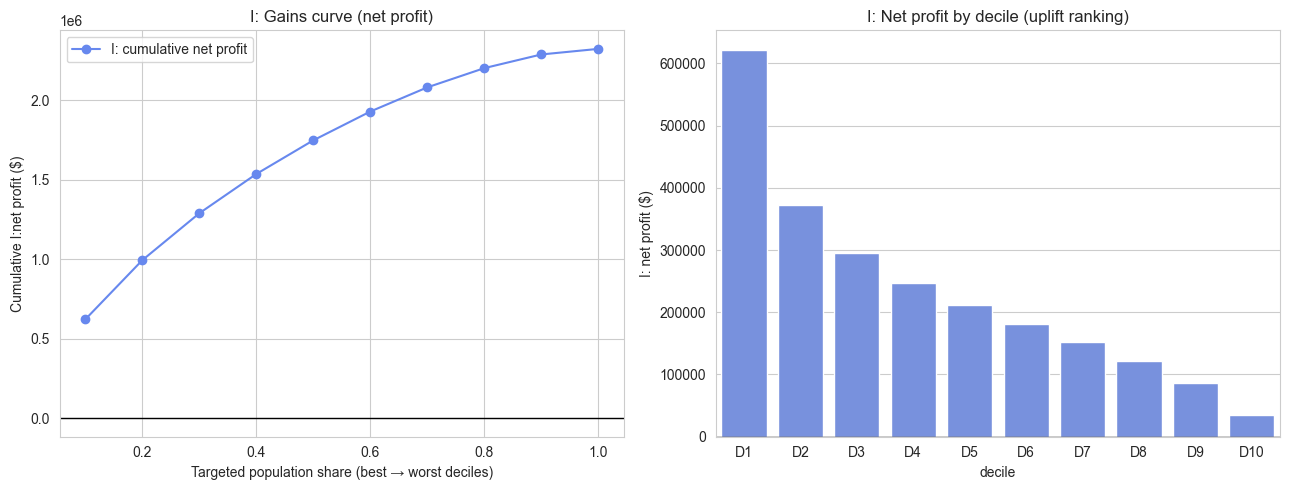

In [290]:
# ===============================
# A) Uplift modeling (customer-month)
# ===============================
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.metrics import auc

sns.set_style("whitegrid")

EXPORT_TO_POSTGRES = False   # <- flip to True to export results
MARGIN_RATE = 0.50           # I:gross margin assumption

df = mart_all_data.copy()
df['transaction_date'] = pd.to_datetime(df['transaction_date'])
df['month'] = df['transaction_date'].dt.to_period('M').astype(str)

# Basic fields
df['revenue'] = df.get('revenue', df['quantity'] * df['avg_price'] + df.get('delivery_charges', 0))
df['coupon_used_flag'] = (df['coupon_status']=='Used').astype(int)
df['applied_discount_pct'] = np.where(df['coupon_status']=='Used', df['discount_pct'].fillna(0), 0.0)
df['discount_dollars_used'] = (df['quantity']*df['avg_price']) * (df['applied_discount_pct']/100.0)

# -------------------------------
# Build a customer-month panel
# -------------------------------
custm = (df.groupby(['customer_id','month'])
           .agg(y_revenue=('revenue','sum'),
                used_coupon=('coupon_used_flag','max'),
                coupon_budget=('discount_dollars_used','sum'),
                orders=('transaction_id','nunique'))
           .reset_index())

# Add customer attributes
attrs = mart_customers.copy()
attrs = attrs.rename(columns={'location':'customer_location','gender':'customer_gender'})
custm = custm.merge(attrs[['customer_id','customer_gender','customer_location','tenure_months']],
                    on='customer_id', how='left')

# Lag features (use prior month revenue, orders)
custm = custm.sort_values(['customer_id','month'])
custm['y_revenue_lag1'] = custm.groupby('customer_id')['y_revenue'].shift(1).fillna(0)
custm['orders_lag1'] = custm.groupby('customer_id')['orders'].shift(1).fillna(0)

# Keep rows with outcome fully observed
panel = custm.dropna(subset=['y_revenue']).copy()

# Features / treatment / outcome
X_cols_num = ['y_revenue_lag1','orders_lag1','tenure_months']
X_cols_cat = ['customer_gender','customer_location']
y_col = 'y_revenue'
w_col = 'used_coupon'
cost_col = 'coupon_budget'

# -------------------------------
# DR-Learner if available, else T-Learner
# -------------------------------
use_econml = False
try:
    from econml.dr import DRLearner
    from sklearn.linear_model import LassoCV
    use_econml = True
except Exception:
    use_econml = False

cat_tr = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
pre = ColumnTransformer(
    transformers=[
        ('num','passthrough', X_cols_num),
        ('cat', cat_tr, X_cols_cat)
    ]
)

if use_econml:
    base_y = Pipeline([('pre', pre), ('model', LassoCV(cv=5))])
    base_t = Pipeline([('pre', pre), ('model', LassoCV(cv=5))])
    final = RandomForestRegressor(n_estimators=300, random_state=42)

    dr = DRLearner(model_regression=base_y,
                   model_propensity=base_t,
                   model_final=final)
    X = panel[X_cols_num + X_cols_cat]
    W = panel[w_col].values
    Y = panel[y_col].values
    dr.fit(Y, W, X=X)
    # Individual treatment effect (ITE) = I:uplift ($)
    panel['i_uplift_pred'] = dr.effect(panel[X_cols_num + X_cols_cat])
else:
    # T-Learner fallback: two RFs (treated / control) on features -> predict E[Y|X,T]
    rf = RandomForestRegressor(n_estimators=400, random_state=42)
    # pipelines
    pipe = Pipeline([('pre', pre), ('rf', rf)])

    treated = panel[panel[w_col]==1]
    control = panel[panel[w_col]==0]

    pipe_t = Pipeline([('pre', pre), ('rf', RandomForestRegressor(n_estimators=400, random_state=42))])
    pipe_c = Pipeline([('pre', pre), ('rf', RandomForestRegressor(n_estimators=400, random_state=42))])

    pipe_t.fit(treated[X_cols_num + X_cols_cat], treated[y_col])
    pipe_c.fit(control[X_cols_num + X_cols_cat], control[y_col])

    mu1 = pipe_t.predict(panel[X_cols_num + X_cols_cat])
    mu0 = pipe_c.predict(panel[X_cols_num + X_cols_cat])
    panel['i_uplift_pred'] = mu1 - mu0

# Convert uplift -> profit (gross, then net after coupon budget)
panel['i_gross_profit_pred'] = MARGIN_RATE * panel['i_uplift_pred']
panel['i_net_profit_pred'] = panel['i_gross_profit_pred'] - panel[cost_col].fillna(0)

# -------------------------------
# Deciles and Qini / gains
# -------------------------------
panel = panel.sort_values('i_net_profit_pred', ascending=False).reset_index(drop=True)
panel['decile'] = pd.qcut(panel.index + 1, 10, labels=[f'D{i}' for i in range(1,11)])

dec = (panel.groupby('decile')
             .agg(n=('customer_id','nunique'),
                  i_uplift=('i_uplift_pred','mean'),
                  i_gross_profit=('i_gross_profit_pred','sum'),
                  coupon_budget=('coupon_budget','sum'),
                  i_net_profit=('i_net_profit_pred','sum'))
             .reset_index())

# Cumulative gains curve by net profit
dec = dec.sort_values('decile')  # D1 ... D10
dec['cum_i_net_profit'] = dec['i_net_profit'].cumsum()
dec['cum_i_gross_profit'] = dec['i_gross_profit'].cumsum()
dec['cum_budget'] = dec['coupon_budget'].cumsum()

# Qini (area under incremental profit curve)
x = np.arange(1, len(dec)+1) / len(dec)   # population share
y = dec['cum_i_net_profit'].values
qini = auc(x, y)

print(f"I: Qini (net profit area): {qini:,.2f}")
print(dec[['decile','n','i_uplift','i_gross_profit','coupon_budget','i_net_profit','cum_i_net_profit']])

# -------------------------------
# Visuals: gains + profit-by-decile
# -------------------------------
fig, ax = plt.subplots(1,2, figsize=(13,5))

# (1) Incremental profit gains curve
ax[0].plot(x, y, marker='o', label='I: cumulative net profit')
ax[0].axhline(0, color='black', lw=1)
ax[0].set_title('I: Gains curve (net profit)')
ax[0].set_xlabel('Targeted population share (best → worst deciles)')
ax[0].set_ylabel('Cumulative I:net profit ($)')
ax[0].legend()

# (2) Bar: net profit by decile
sns.barplot(ax=ax[1], data=dec, x='decile', y='i_net_profit')
ax[1].axhline(0, color='black', lw=1)
ax[1].set_title('I: Net profit by decile (uplift ranking)')
ax[1].set_ylabel('I: net profit ($)')
plt.tight_layout(); plt.show()

# -------------------------------
# Export (optional)
# -------------------------------
if EXPORT_TO_POSTGRES:
    panel_out = panel[['customer_id','month','i_uplift_pred','i_gross_profit_pred','i_net_profit_pred','coupon_budget','decile']]
    panel_out.to_sql('i_uplift_customer_month', engine, schema=my_schema, if_exists='replace', index=False)
    dec.to_sql('i_uplift_deciles', engine, schema=my_schema, if_exists='replace', index=False)
    print("Exported i_uplift_customer_month & i_uplift_deciles to Postgres.")


I: synthetic control (head)
       month                  cell_id product_category customer_location  actual_revenue  synthetic_revenue     i_revenue  coupon_budget  i_gross_profit  \
230  2019-04  Housewares | California       Housewares        California           51.91        2820.009814  -2768.099814          2.000    -1384.049907   
198  2019-04    Headgear | California         Headgear        California         1483.01         541.180927    941.829073         85.935      470.914536   
413  2019-04        Office | New York           Office          New York         6912.97         544.046444   6368.923556        172.371     3184.461778   
44   2019-04       Apparel | New York          Apparel          New York        18357.45         560.905603  17796.544397        630.760     8898.272198   
192  2019-04        Google | Illinois           Google          Illinois          188.92         207.244844    -18.324844          0.000       -9.162422   

     i_net_profit_after_coupons  
2

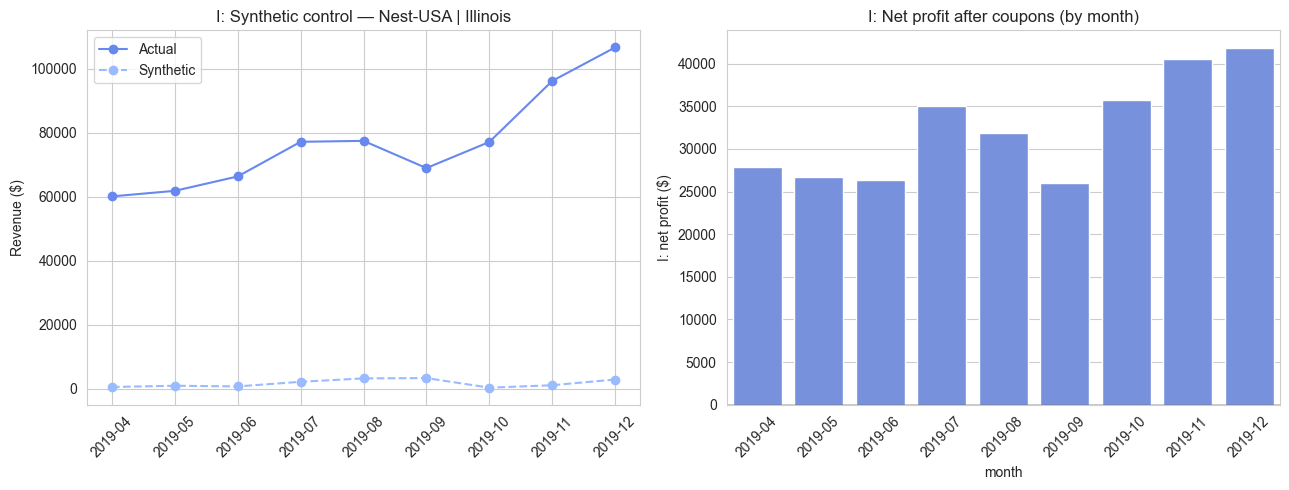

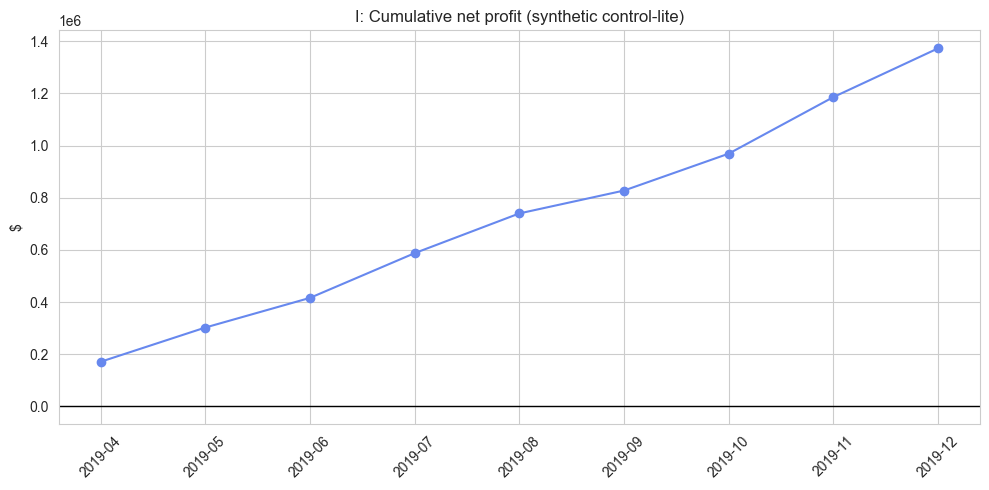

In [291]:
# =======================================
# B) Synthetic control-lite (cell level)
# =======================================
from sklearn.metrics.pairwise import cosine_distances

K_DONORS = 10
PRE_PERIODS = 3     # number of months before t used for matching
EXPORT_TO_POSTGRES = False  # toggle as needed

# Build cell-month totals
cell = (df.groupby(['product_category','customer_location','month'])
          .agg(revenue=('revenue','sum'),
               treated=('coupon_used_flag','mean'),   # share of txns with coupon
               budget=('discount_dollars_used','sum'))
          .reset_index())

# We'll say a "treated cell-month" is one with treated share >= 0.25 (tune threshold)
cell['treated_flag'] = (cell['treated'] >= 0.25).astype(int)

# Build a wide panel per cell for rolling PRE_PERIODS vector
cell = cell.sort_values(['product_category','customer_location','month'])
cell['cell_id'] = cell['product_category'] + ' | ' + cell['customer_location']

# Helper to get prior PRE_PERIODS revenue vector within each cell
def lag_vec(g, p=PRE_PERIODS):
    g = g.copy()
    for i in range(1, p+1):
        g[f'rev_lag_{i}'] = g['revenue'].shift(i)
    return g

cell = cell.groupby('cell_id', group_keys=False).apply(lag_vec, p=PRE_PERIODS)

# For each treated cell-month with enough history, find K donor cell-months (same calendar month) that are untreated and closest in the lag vector space
rows = []
for _, row in cell.iterrows():
    if (row['treated_flag']==1) and (not pd.isna(row[f'rev_lag_{PRE_PERIODS}'])):
        m = row['month']
        # candidate donors: same month, untreated, with full lag history
        donors = cell[(cell['month']==m) &
                      (cell['treated_flag']==0) &
                      (~cell[f'rev_lag_{PRE_PERIODS}'].isna())].copy()
        if donors.empty:
            continue

        # distance on lag vectors (recent pattern matching)
        cols = [f'rev_lag_{i}' for i in range(1, PRE_PERIODS+1)]
        dists = cosine_distances([row[cols].values], donors[cols].values)[0]
        donors['w'] = 1/(dists + 1e-6)   # inverse-distance weights
        donors = donors.nlargest(K_DONORS, 'w')
        donors['w'] = donors['w'] / donors['w'].sum()

        # synthetic revenue = weighted donor revenue at time t
        synth_rev = np.sum(donors['revenue'] * donors['w'])
        i_rev = row['revenue'] - synth_rev
        i_gp  = MARGIN_RATE * i_rev
        i_net = i_gp - row['budget']

        rows.append({
            'month': m,
            'cell_id': row['cell_id'],
            'product_category': row['product_category'],
            'customer_location': row['customer_location'],
            'actual_revenue': row['revenue'],
            'synthetic_revenue': synth_rev,
            'i_revenue': i_rev,
            'coupon_budget': row['budget'],
            'i_gross_profit': i_gp,
            'i_net_profit_after_coupons': i_net
        })

sc = pd.DataFrame(rows).sort_values('month')
print("I: synthetic control (head)")
print(sc.head())

# Visualize the largest treated cell by coupon budget
if not sc.empty:
    top_cell = (sc.groupby('cell_id')['coupon_budget'].sum().sort_values(ascending=False).index[0])
    eg = sc[sc['cell_id']==top_cell].sort_values('month')
    fig, ax = plt.subplots(1,2, figsize=(13,5))

    # (1) Actual vs Synthetic
    ax[0].plot(eg['month'], eg['actual_revenue'], marker='o', label='Actual')
    ax[0].plot(eg['month'], eg['synthetic_revenue'], marker='o', linestyle='--', label='Synthetic')
    ax[0].set_title(f"I: Synthetic control — {top_cell}")
    ax[0].set_ylabel('Revenue ($)')
    ax[0].legend()
    ax[0].tick_params(axis='x', rotation=45)

    # (2) Incremental net profit by month
    sns.barplot(ax=ax[1], data=eg, x='month', y='i_net_profit_after_coupons')
    ax[1].axhline(0, color='black', lw=1)
    ax[1].set_title('I: Net profit after coupons (by month)')
    ax[1].set_ylabel('I: net profit ($)')
    ax[1].tick_params(axis='x', rotation=45)

    plt.tight_layout(); plt.show()

# Aggregate KPI across all treated cells
sc_month = (sc.groupby('month')
              .agg(i_revenue=('i_revenue','sum'),
                   coupon_budget=('coupon_budget','sum'),
                   i_gross_profit=('i_gross_profit','sum'),
                   i_net_profit=('i_net_profit_after_coupons','sum'))
              .reset_index())
sc_month['i_cum_net_profit'] = sc_month['i_net_profit'].cumsum()

plt.figure(figsize=(10,5))
plt.plot(sc_month['month'], sc_month['i_cum_net_profit'], marker='o')
plt.axhline(0, color='black', lw=1)
plt.title('I: Cumulative net profit (synthetic control-lite)')
plt.ylabel('$'); plt.xticks(rotation=45); plt.tight_layout(); plt.show()

# Export (optional)
if EXPORT_TO_POSTGRES and not sc.empty:
    sc.to_sql('i_sc_cell_results', engine, schema=my_schema, if_exists='replace', index=False)
    sc_month.to_sql('i_sc_month_summary', engine, schema=my_schema, if_exists='replace', index=False)
    print("Exported i_sc_cell_results & i_sc_month_summary to Postgres.")


In [289]:
dash_month.to_sql('i_dashboard_monthly', engine, schema=my_schema, if_exists='replace', index=False)
seg_summary.to_sql('i_dashboard_segments', engine, schema=my_schema, if_exists='replace', index=False)

400

In [227]:
ltv_final = pd.read_csv("Customer_LTV_Summary.csv")
Sales = pd.read_csv("../LTV-Capstone-Project/Data/Online_Sales.csv")

In [228]:
ltv_final.head(2)

customer_id  frequency  recency      T  monetary_value  predicted_purchases_6m  predicted_avg_value  predicted_ltv_6m gender  location  tenure_months
0        12346        0.0      0.0  107.0           0.000                0.486163          1265.594052        615.284554      F  New York             31
1        12347        2.0    223.0  282.0        1163.375                0.867946          1240.987166       1077.109890      M  New York             20

In [229]:
Sales.head(2)

customer_id  transaction_id transaction_date     product_sku                                product_description product_category  quantity  avg_price  \
0        17850           16679         1/1/2019  GGOENEBJ079499  Nest Learning Thermostat 3rd Gen-USA - Stainle...         Nest-USA         1     153.71   
1        17850           16680         1/1/2019  GGOENEBJ079499  Nest Learning Thermostat 3rd Gen-USA - Stainle...         Nest-USA         1     153.71   

   delivery_charges coupon_status  
0               6.5          Used  
1               6.5          Used

In [230]:
# Convert Coupon_Status to numeric (1 for used, 0 for not used)
Sales['coupon_status'] = Sales['coupon_status'].map({'Used': 1, 'Not Used': 0})

# Average coupon usage rate per customer (0 to 1)
coupon_usage = Sales.groupby('customer_id')['coupon_status'].mean().reset_index()
coupon_usage.columns = ['customer_id', 'coupon_usage_rate']

In [231]:
# Flag if each transaction is in high season 
Sales['high_season'] = pd.to_datetime(Sales['transaction_date'].astype(str)).dt.month.isin([11, 12])

# Check if each customer had any transaction in high season
season_flag = Sales.groupby('customer_id')['high_season'].max().reset_index()

In [232]:
ltv_final.head()

customer_id  frequency  recency      T  monetary_value  predicted_purchases_6m  predicted_avg_value  predicted_ltv_6m gender    location  tenure_months
0        12346        0.0      0.0  107.0           0.000                0.486163          1265.594052        615.284554      F    New York             31
1        12347        2.0    223.0  282.0        1163.375                0.867946          1240.987166       1077.109890      M    New York             20
2        12348        1.0    119.0  192.0         693.731                0.577773          1187.344186        686.015648      M  California             39
3        12350        0.0      0.0   17.0           0.000                0.914834          1265.594052       1157.807941      M  California             25
4        12356        0.0      0.0  107.0           0.000                0.486163          1265.594052        615.284554      F    Illinois             31

In [233]:
# Merge coupon usage
ltv_final = ltv_final.merge(coupon_usage, on='customer_id', how='left')

# Merge seasonality
ltv_final = ltv_final.merge(season_flag, on='customer_id', how='left')

# Fill any missing values
ltv_final['coupon_usage_rate'] = ltv_final['coupon_usage_rate'].fillna(0)
ltv_final['high_season'] = ltv_final['high_season'].fillna(False)

We grouped customers by coupon usage and seasonal activity, then compared average LTV. Incrementality measures the additional impact caused directly by a marketing action or campaign — essentially, the lift or incremental gain beyond what would have happened anyway without the marketing.
For example:
If customers who used coupons have a higher LTV, the question is:
Is that increase caused by the coupon, or would those customers have bought just as much anyway?
Incrementality tries to isolate the causal effect of marketing (coupons, ads, seasonality, etc.) on sales, LTV, or other KPIs.

Below we grouped customers by coupon usage and seasonal activity, then compared average LTV

In [234]:
# LTV by Coupon Exposure
ltv_final.groupby('coupon_usage_rate')['predicted_ltv_6m'].mean()

coupon_usage_rate
0.000000    549.864476
0.142857    594.015078
0.166667    191.353170
0.200000    846.447143
0.250000    627.522860
               ...    
0.923077    368.069578
0.928571    350.571204
0.937500    134.234391
0.941176    559.171604
1.000000    582.534203
Name: predicted_ltv_6m, Length: 239, dtype: float64

In [235]:
# LTV by by Seasonality
ltv_final.groupby('high_season')['predicted_ltv_6m'].mean()

high_season
False     537.199177
True     1799.741663
Name: predicted_ltv_6m, dtype: float64

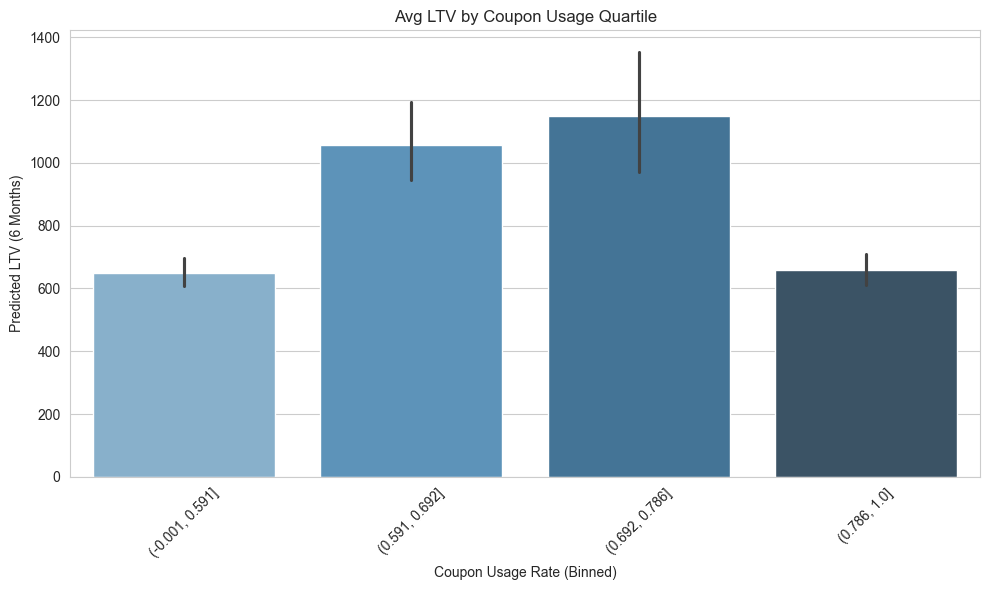

In [236]:
# These bar plots will  show whether coupon usage and holiday season purchases are associated with higher predicted LTV

#Avg LTV by Coupon Usage Quartile

# Bin coupon usage into 4 groups (0 to high)
ltv_final['coupon_bin'] = pd.qcut(ltv_final['coupon_usage_rate'], q=4)

plt.figure(figsize=(10, 6))
sns.barplot(data=ltv_final, x='coupon_bin', y='predicted_ltv_6m', palette='Blues_d')
plt.title('Avg LTV by Coupon Usage Quartile')
plt.xlabel('Coupon Usage Rate (Binned)')
plt.ylabel('Predicted LTV (6 Months)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

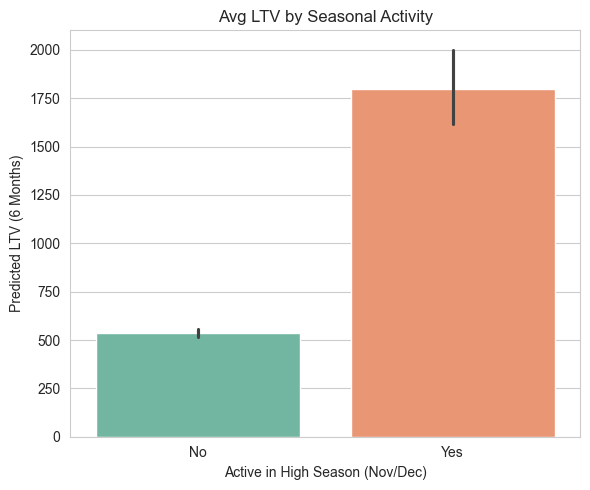

In [237]:
#Average LTV: Seasonal vs. Non-Seasonal Customers
plt.figure(figsize=(6, 5))
sns.barplot(data=ltv_final, x='high_season', y='predicted_ltv_6m', palette='Set2')
plt.title('Avg LTV by Seasonal Activity')
plt.xlabel('Active in High Season (Nov/Dec)')
plt.ylabel('Predicted LTV (6 Months)')
plt.xticks([0, 1], ['No', 'Yes'])
plt.tight_layout()
plt.show()

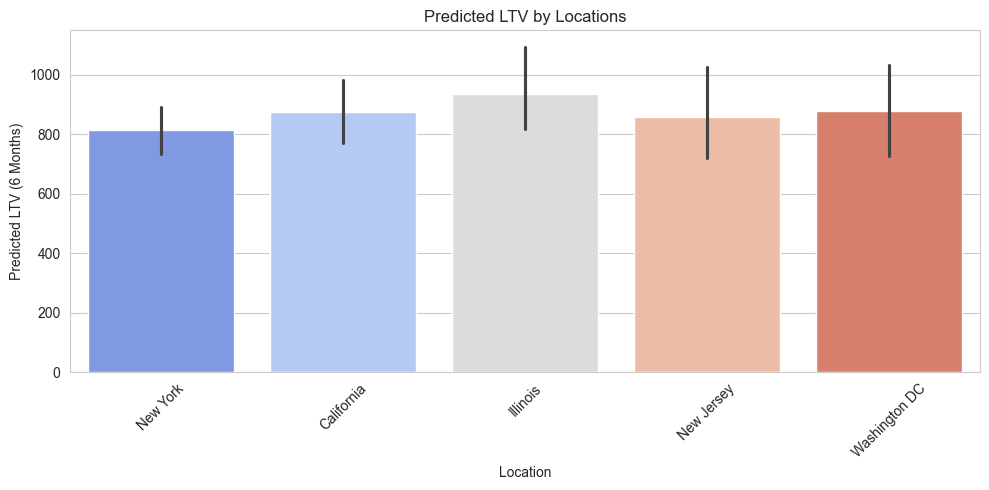

In [384]:
#LTV by Location
plt.figure(figsize=(10, 5))
top_locations = ltv_final['location'].value_counts().nlargest(10).index
filtered = ltv_final[ltv_final['location'].isin(top_locations)]

sns.barplot(data=filtered, x='location', y='predicted_ltv_6m', palette='coolwarm')
plt.title('Predicted LTV by Locations')
plt.ylabel('Predicted LTV (6 Months)')
plt.xlabel('Location')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

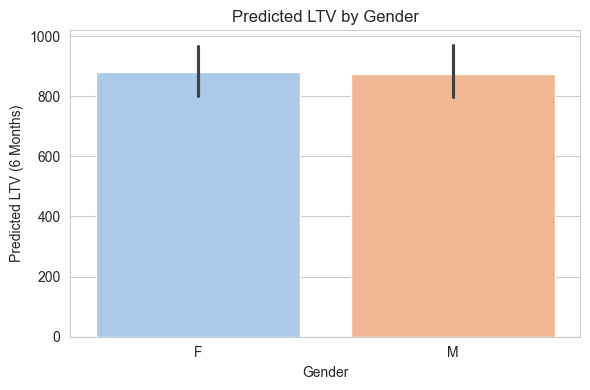

In [385]:
#LTV by Gender
plt.figure(figsize=(6, 4))
sns.barplot(data=ltv_final, x='gender', y='predicted_ltv_6m', palette='pastel')
plt.title('Predicted LTV by Gender')
plt.ylabel('Predicted LTV (6 Months)')
plt.xlabel('Gender')
plt.tight_layout()
plt.show()

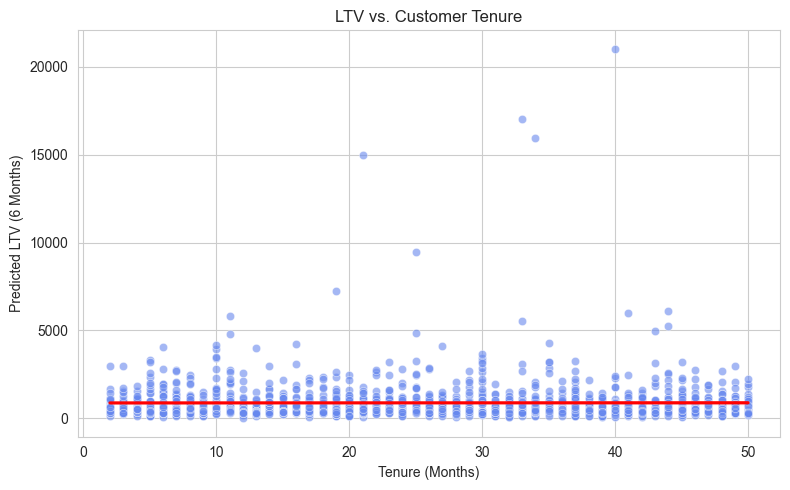

In [386]:
#LTV vs. Tenure (Months)
plt.figure(figsize=(8, 5))
sns.scatterplot(data=ltv_final, x='tenure_months', y='predicted_ltv_6m', alpha=0.6)
sns.regplot(data=ltv_final, x='tenure_months', y='predicted_ltv_6m', scatter=False, color='red')
plt.title('LTV vs. Customer Tenure')
plt.ylabel('Predicted LTV (6 Months)')
plt.xlabel('Tenure (Months)')
plt.tight_layout()
plt.show()

In [238]:
# Generate dataframes for export
#  1. LTV by Gender
ltv_by_gender = ltv_final.groupby('gender')['predicted_ltv_6m'].mean().reset_index()

# 2. LTV by Top 10 Locations
top_locations = ltv_final['location'].value_counts().nlargest(10).index
filtered_location = ltv_final[ltv_final['location'].isin(top_locations)]
ltv_by_location = filtered_location.groupby('location')['predicted_ltv_6m'].mean().reset_index()

# 3. LTV by Tenure
ltv_by_tenure = ltv_final.groupby('tenure_months')['predicted_ltv_6m'].mean().reset_index()

In [388]:
ltv_by_gender.to_csv('ltv_by_gender.csv', index=False)
ltv_by_location.to_csv('ltv_by_location_top10.csv', index=False)
ltv_by_tenure.to_csv('ltv_by_tenure.csv', index=False)

In [239]:
# Average predicted LTV by coupon usage quartiles and export it as a CSV for Tableau

# Create coupon usage quartiles
ltv_final['coupon_usage_quartile'] = pd.qcut(ltv_final['coupon_usage_rate'], 4, labels=False)

# Calculate average predicted LTV per quartile
ltv_by_coupon_quartile = ltv_final.groupby('coupon_usage_quartile')['predicted_ltv_6m'].mean().reset_index()

# Optionally, rename quartiles for clarity
ltv_by_coupon_quartile['coupon_usage_quartile'] = ltv_by_coupon_quartile['coupon_usage_quartile'].map({
    0: 'Q1 (Lowest)',
    1: 'Q2',
    2: 'Q3',
    3: 'Q4 (Highest)'
})

ltv_by_coupon_quartile.to_csv('ltv_by_coupon_quartile.csv', index=False)

In [240]:
# LTV by seasonal activity export data to CSV for Tableau and DBeaver

ltv_by_season = ltv_final.groupby('high_season')['predicted_ltv_6m'].mean().reset_index()

# Rename for clarity
ltv_by_season['high_season'] = ltv_by_season['high_season'].map({False: 'Non-Seasonal', True: 'Seasonal'})

ltv_by_season.to_csv('ltv_by_seasonal_activity.csv', index=False)

In [ ]:

from sqlalchemy import create_engine, text
import pandas as pd

pg_user  = config['POSTGRES_USER']
pg_pass  = config['POSTGRES_PASS']
pg_host  = config['POSTGRES_HOST']
pg_port  = config['POSTGRES_PORT']
pg_db    = config['POSTGRES_DB']
my_schema = "team_3"  

engine = create_engine(
    f'postgresql://{pg_user}:{pg_pass}@{pg_host}:{pg_port}/{pg_db}',
    echo=False
)

# ---- Helpers  ----
def cols_of(schema, table):
    """Return {lower_name: (actual_name, data_type)} for a table."""
    q = """
    select column_name, data_type
    from information_schema.columns
    where table_schema = :schema and table_name = :table
    """
    with engine.begin() as conn:
        rows = conn.execute(text(q), {"schema": schema, "table": table}).fetchall()
    return {r[0].lower(): (r[0], r[1].lower()) for r in rows}

def pick(colmap, candidates):
    """Pick the first candidate present; return actual_name or None."""
    for c in candidates:
        key = c.lower()
        if key in colmap:
            return colmap[key][0]
    return None

def dtype_of(colmap, colname):
    return colmap[colname.lower()][1]

def qident(name):
    """Quote an identifier safely for SQL injection-safe interpolation."""
    return '"' + name.replace('"','""') + '"'

def month_sql(colname, datatype):
    """Return SQL that yields first-of-month DATE as 'month' from many string formats."""
    colq = qident(colname)
    dt = (datatype or "").lower()
    if 'date' in dt or 'timestamp' in dt:
        return f"date_trunc('month', {colq})::date as month"

    # Normalize delimiter for some branches
    norm = f"replace({colq}, '-', '/')"

    return (
        "case "
        # YYYY-MM or YYYY/MM
        f"when {colq} ~ '^[0-9]{{4}}[-/][0-9]{{2}}$' then to_date(replace({colq}, '/', '-'), 'YYYY-MM') "
        # YYYY-MM-DD or YYYY/MM/DD
        f"when {colq} ~ '^[0-9]{{4}}[-/][0-9]{{2}}[-/][0-9]{{2}}$' then to_date(replace({colq}, '/', '-'), 'YYYY-MM-DD') "
        # M/D/YYYY or D/M/YYYY (auto-pick based on first token <= 12)
        f"when {colq} ~ '^[0-9]{{1,2}}[-/][0-9]{{1,2}}[-/][0-9]{{4}}$' then "
        f"     case when split_part({norm}, '/', 1)::int <= 12 "
        f"          then to_date({colq}, 'MM/DD/YYYY') "
        f"          else to_date({colq}, 'DD/MM/YYYY') "
        f"     end "
        # M/D/YY or D/M/YY
        f"when {colq} ~ '^[0-9]{{1,2}}[-/][0-9]{{1,2}}[-/][0-9]{{2}}$' then "
        f"     case when split_part({norm}, '/', 1)::int <= 12 "
        f"          then to_date({colq}, 'MM/DD/YY') "
        f"          else to_date({colq}, 'DD/MM/YY') "
        f"     end "
        # Fallback: try YYYY-MM after swapping '/'→'-'
        f"else to_date(replace({colq}, '/', '-'), 'YYYY-MM') "
        "end::date as month"
    )

def run_sql(msg, sql):
    with engine.begin() as conn:
        conn.execute(text(sql))
    print(f"✓ {msg}")

# ======================= 1) Diagnostic means by month =======================
diag_cols = cols_of(my_schema, "i_gap_diagnostic_by_month")
time_col = pick(diag_cols, ["month","month_date","transaction_month","order_month","month_str","transaction_month_str","order_month_str"])
treated_col = pick(diag_cols, ["treated_mean","rev_treated","treated_avg","avg_treated","treated"])
control_col = pick(diag_cols, ["control_mean","rev_control","control_avg","avg_control","control"])
gap_col     = pick(diag_cols, ["gap","treated_minus_control","treated_control_gap","delta"])

if not (time_col and treated_col and control_col):
    raise ValueError("i_gap_diagnostic_by_month is missing a required column (time/treated/control).")

month_expr = month_sql(time_col, dtype_of(diag_cols, time_col))
gap_expr = (f"{qident(gap_col)} as gap" if gap_col
            else f"({qident(treated_col)}::numeric - {qident(control_col)}::numeric) as gap")

sql_viz_diag = f"""
drop table if exists {my_schema}.viz_i_diag_means;
create table {my_schema}.viz_i_diag_means as
select
  {month_expr},
  {qident(treated_col)}::numeric  as treated_mean,
  {qident(control_col)}::numeric  as control_mean,
  {gap_expr}
from {my_schema}.i_gap_diagnostic_by_month
order by 1;
"""
run_sql(f"Created {my_schema}.viz_i_diag_means", sql_viz_diag)

sql_viz_diag_long = f"""
drop table if exists {my_schema}.viz_i_diag_means_long;
create table {my_schema}.viz_i_diag_means_long as
select month, 'Treated mean' as series, treated_mean as value, gap
from {my_schema}.viz_i_diag_means
union all
select month, 'Control mean' as series, control_mean as value, gap
from {my_schema}.viz_i_diag_means
order by 1,2;
"""
run_sql(f"Created {my_schema}.viz_i_diag_means_long", sql_viz_diag_long)

# ======================= 2) ATT (treated vs control, with CI) =======================
att_cols = cols_of(my_schema, "i_att_treated_twfe")
att_est  = pick(att_cols, ["i_att_treated","att","estimate","tau_hat","effect","delta","coef","beta","did","ate","att_treated"])
att_lo   = pick(att_cols, ["ci_low","lower_ci","lower","lo","lcl","conf_low","p025","p2_5"])
att_hi   = pick(att_cols, ["ci_high","upper_ci","upper","hi","ucl","conf_high","p975","p97_5"])

if not all([att_est, att_lo, att_hi]):
    raise ValueError(f"i_att_treated_twfe needs estimate/ci_low/ci_high. Found: {list(k for k in att_cols)}")

sql_viz_att = f"""
drop table if exists {my_schema}.viz_i_att;
create table {my_schema}.viz_i_att as
select 1::int as x, {qident(att_est)}::numeric as estimate, {qident(att_lo)}::numeric as ci_low, {qident(att_hi)}::numeric as ci_high
from {my_schema}.i_att_treated_twfe
limit 1;
"""
run_sql(f"Created {my_schema}.viz_i_att", sql_viz_att)

# ======================= 3) Discount dose–response (β with CI) =======================
dose_cols = cols_of(my_schema, "i_discount_dose_response_twfe")

# recognize your column name explicitly
beta_est  = pick(dose_cols, [
    "i_discount_effect_per_1pp",   # <-- your column
    "beta","coef","estimate","effect","tau","att","delta"
])
beta_lo   = pick(dose_cols, ["ci_low","lower_ci","lower","lo","lcl","conf_low","p025","p2_5"])
beta_hi   = pick(dose_cols, ["ci_high","upper_ci","upper","hi","ucl","conf_high","p975","p97_5"])

# last-ditch heuristic: if we still don't see an estimate but we do have CI columns,
# pick the first non-CI column as the estimate
if not beta_est and {"ci_low","ci_high"}.issubset({k for k in dose_cols}):
    for k in dose_cols:
        if k not in {"ci_low","ci_high"}:
            beta_est = dose_cols[k][0]  # actual name
            break

if not all([beta_est, beta_lo, beta_hi]):
    raise ValueError(
        f"i_discount_dose_response_twfe needs estimate/ci_low/ci_high. Found cols: {list(dose_cols.keys())}"
    )

sql_viz_dose = f"""
drop table if exists {my_schema}.viz_i_discount_dose;
create table {my_schema}.viz_i_discount_dose as
select 1::int as x,
       {qident(beta_est)}::numeric as estimate,
       {qident(beta_lo)}::numeric  as ci_low,
       {qident(beta_hi)}::numeric  as ci_high
from {my_schema}.i_discount_dose_response_twfe
limit 1;
"""
run_sql(f"Created {my_schema}.viz_i_discount_dose", sql_viz_dose)

# ======================= 4) Incremental revenue by month (+ cumulative) =======================
def _is_numeric(dt):
    dt = (dt or "").lower()
    return any(k in dt for k in ["int", "numeric", "double", "real", "decimal"])

inc_cols = cols_of(my_schema, "i_incremental_by_month")

# Try many likely time/value names first
inc_time = pick(inc_cols, [
    "month","month_date","transaction_month","order_month",
    "month_str","transaction_month_str","order_month_str","period","date"
])

inc_val = pick(inc_cols, [
    "i_incremental_dollars","i_incremental_revenue","incremental_revenue",
    "incremental_dollars","i_incremental","incremental","uplift_revenue",
    "uplift","i_revenue"   # sometimes the table stores the monthly incremental as i_revenue
])

# Fallbacks: (1) any *month/date/period*-ish column; (2) any numeric col with "incremental" in the name
if not inc_time:
    for k, (actual, dt) in inc_cols.items():
        if any(tok in k for tok in ["month","date","period"]):
            inc_time = actual
            break

if not inc_val:
    for k, (actual, dt) in inc_cols.items():
        if "incremental" in k and _is_numeric(dt):
            inc_val = actual
            break

if inc_time and inc_val:
    inc_month_expr = month_sql(inc_time, dtype_of(inc_cols, inc_time))
    sql_viz_inc = f"""
    drop table if exists {my_schema}.viz_i_incremental_by_month;
    create table {my_schema}.viz_i_incremental_by_month as
    select
      {inc_month_expr},
      {qident(inc_val)}::numeric as i_incremental_dollars,
      sum({qident(inc_val)}::numeric) over (order by 1) as i_cum_incremental_dollars
    from {my_schema}.i_incremental_by_month
    order by 1;
    """
    run_sql(f"Created {my_schema}.viz_i_incremental_by_month", sql_viz_inc)
else:
    # Hard fallback: build directly from the monthly dashboard table
    dash_cols = cols_of(my_schema, "i_dashboard_monthly")
    dash_time = pick(dash_cols, ["month","month_date","month_str"])
    dash_val  = pick(dash_cols, ["i_revenue","i_incremental","i_incremental_revenue"])
    if not (dash_time and dash_val):
        raise ValueError(
            "Could not find month/value in i_incremental_by_month, "
            "and fallback to i_dashboard_monthly also failed. "
            f"i_incremental_by_month cols: {list(inc_cols.keys())}; "
            f"i_dashboard_monthly cols: {list(dash_cols.keys())}"
        )
    dash_month_expr = month_sql(dash_time, dtype_of(dash_cols, dash_time))
    sql_viz_inc_fb = f"""
    drop table if exists {my_schema}.viz_i_incremental_by_month;
    create table {my_schema}.viz_i_incremental_by_month as
    select
      {dash_month_expr},
      {qident(dash_val)}::numeric as i_incremental_dollars,
      sum({qident(dash_val)}::numeric) over (order by 1) as i_cum_incremental_dollars
    from {my_schema}.i_dashboard_monthly
    order by 1;
    """
    run_sql(f"Created {my_schema}.viz_i_incremental_by_month (fallback from i_dashboard_monthly)", sql_viz_inc_fb)


# ======================= 5) Net profit after coupons vs coupon budget =======================
ms_cols  = cols_of(my_schema, "marketing_spend")
dash_cols = cols_of(my_schema, "i_dashboard_monthly")

# time columns
ms_time   = pick(ms_cols, ["month","month_date","month_str","date"])
if not ms_time:
    raise ValueError("marketing_spend needs a date/month column.")
ms_month_expr = month_sql(ms_time, dtype_of(ms_cols, ms_time))

# try explicit budget column first
ms_budget = pick(ms_cols, ["coupon_budget","total_spend","marketing_spend"])

# discover actual (case-sensitive) names for online/offline variants
online_col       = ms_cols["online_spend"][0]  if "online_spend"  in ms_cols else None
offline_col      = ms_cols["offline_spend"][0] if "offline_spend" in ms_cols else None
offline_send_col = ms_cols["offline_send"][0]  if "offline_send"  in ms_cols else None  # typo variant

# build a safe expression using quoted identifiers
if ms_budget:
    ms_budget_expr = qident(ms_budget)
else:
    if online_col and offline_col:
        ms_budget_expr = f"coalesce({qident(online_col)},0) + coalesce({qident(offline_col)},0)"
    elif online_col and offline_send_col:
        ms_budget_expr = f"coalesce({qident(online_col)},0) + coalesce({qident(offline_send_col)},0)"
    elif online_col:
        ms_budget_expr = qident(online_col)
    elif offline_col:
        ms_budget_expr = qident(offline_col)
    elif offline_send_col:
        ms_budget_expr = qident(offline_send_col)
    else:
        ms_budget_expr = "0"

# dashboard side
dash_time = pick(dash_cols, ["month","month_date","month_str"])
dash_net  = pick(dash_cols, ["i_net_profit_after_coupons","net_profit_after_coupons","net_profit_inc","net_profit"])
if not (dash_time and dash_net):
    raise ValueError("i_dashboard_monthly needs month + net_profit_after_coupons (or equivalent).")
dash_month_expr = month_sql(dash_time, dtype_of(dash_cols, dash_time))

# normalize/aggregate to month (no temp tables, just normal)
sql_norm_ms = f"""
drop table if exists {my_schema}._tmp_ms_norm;
create table {my_schema}._tmp_ms_norm as
select month, sum(coupon_budget)::numeric as coupon_budget
from (
  select {ms_month_expr}, ({ms_budget_expr})::numeric as coupon_budget
  from {my_schema}.marketing_spend
) d
group by 1
order by 1;
"""
run_sql(f"Built {my_schema}._tmp_ms_norm", sql_norm_ms)

sql_norm_dash = f"""
drop table if exists {my_schema}._tmp_dash_norm;
create table {my_schema}._tmp_dash_norm as
select {dash_month_expr}, {qident(dash_net)}::numeric as i_net_profit_after_coupons
from {my_schema}.i_dashboard_monthly;
"""
run_sql(f"Built {my_schema}._tmp_dash_norm", sql_norm_dash)

sql_viz_budget = f"""
drop table if exists {my_schema}.viz_i_budget_vs_net;
create table {my_schema}.viz_i_budget_vs_net as
select
  coalesce(m.month, d.month) as month,
  coalesce(m.coupon_budget, 0) as coupon_budget,
  d.i_net_profit_after_coupons
from {my_schema}._tmp_ms_norm m
full outer join {my_schema}._tmp_dash_norm d
  on m.month = d.month
order by 1;

drop table if exists {my_schema}._tmp_ms_norm;
drop table if exists {my_schema}._tmp_dash_norm;
"""
run_sql(f"Created {my_schema}.viz_i_budget_vs_net", sql_viz_budget)

# ---- Optional: quick previews ----
for t in [
    "viz_i_diag_means",
    "viz_i_diag_means_long",
    "viz_i_att",
    "viz_i_discount_dose",
    "viz_i_incremental_by_month",
    "viz_i_budget_vs_net",
]:
    try:
        df = pd.read_sql(f"select * from {my_schema}.{t} order by 1 limit 5", engine)
        print(f"\nPreview {my_schema}.{t}")
        display(df)
    except Exception as e:
        print(f"Preview failed for {t}: {e}")


✓ Created team_3.viz_i_diag_means
✓ Created team_3.viz_i_diag_means_long
✓ Created team_3.viz_i_att
✓ Created team_3.viz_i_discount_dose
✓ Created team_3.viz_i_incremental_by_month
✓ Built team_3._tmp_ms_norm
✓ Built team_3._tmp_dash_norm
✓ Created team_3.viz_i_budget_vs_net

Preview team_3.viz_i_diag_means


month  treated_mean  control_mean           gap
0  2019-01-01  30630.438667      852.5800  29777.858667
1  2019-02-01  25484.137857      814.6175  24669.520357
2  2019-03-01  27000.734667     1349.2525  25651.482167
3  2019-04-01  29184.930000     1331.5525  27853.377500
4  2019-05-01  22980.184667     1114.2050  21865.979667


Preview team_3.viz_i_diag_means_long


month        series         value           gap
0  2019-01-01  Treated mean  30630.438667  29777.858667
1  2019-01-01  Control mean    852.580000  29777.858667
2  2019-02-01  Control mean    814.617500  24669.520357
3  2019-02-01  Treated mean  25484.137857  24669.520357
4  2019-03-01  Control mean   1349.252500  25651.482167


Preview team_3.viz_i_att


x    estimate       ci_low      ci_high
0  1  329.913583 -1003.235197  1663.062363


Preview team_3.viz_i_discount_dose


x    estimate      ci_low    ci_high
0  1 -210.044823 -459.166559  39.076913


Preview team_3.viz_i_incremental_by_month


month  i_incremental_dollars  i_cum_incremental_dollars
0  2019-01-01           -2100.448229              -50410.757484
1  2019-02-01           -4200.896457              -50410.757484
2  2019-03-01           -6301.344686              -50410.757484
3  2019-04-01           -2100.448229              -50410.757484
4  2019-05-01           -4200.896457              -50410.757484


Preview team_3.viz_i_budget_vs_net


month  coupon_budget  i_net_profit_after_coupons
0  2019-01-01        6924.50                19278.445855
1  2019-01-02        7980.36                         NaN
2  2019-01-03        6076.38                         NaN
3  2019-01-04        7428.55                         NaN
4  2019-01-05        8555.30                         NaN

# Step 9 — Seasonality Analysis

<a id='step-9-seasonality-analysis'></a>

In [ ]:

# 1. Set up connection (update credentials and host!)

config = dotenv_values() 

pg_user = config['POSTGRES_USER']  
pg_host = config['POSTGRES_HOST']
pg_port = config['POSTGRES_PORT']
pg_db = config['POSTGRES_DB']
pg_schema = config['POSTGRES_SCHEMA']
pg_pass = config['POSTGRES_PASS']

url = f'postgresql://{pg_user}:{pg_pass}@{pg_host}:{pg_port}/{pg_db}'

engine = create_engine(url, echo=False)

# 2. Load data

my_schema = "team_3"

mart_all_data = pd.read_sql(
    f"SELECT * FROM {my_schema}.mart_all_data;",
    engine,
    parse_dates=['transaction_date']
)

holidays = pd.read_sql(
    f"SELECT * FROM {my_schema}.mart_holidays_2019_us;",
    engine,
    parse_dates=["date"]
)

In [242]:
#Prepare holidays dataframe - filter only national holidays
national_holidays = holidays[holidays['national_holiday'] == True].copy()
national_holidays.rename(columns={'date': 'transaction_date'}, inplace=True)
national_holidays['transaction_date'] = pd.to_datetime(national_holidays['transaction_date'])

# Prepare mart_all_data
mart_all_data['transaction_date'] = pd.to_datetime(mart_all_data['transaction_date'])

In [243]:
mart_all_data.columns

Index(['transaction_date', 'transaction_id', 'customer_id', 'customer_gender', 'customer_location', 'customer_tenure_months', 'produkt_sku',
       'product_category', 'quantity', 'avg_price', 'delivery_charges', 'revenue', 'coupon_status', 'discount_pct', 'gst_onsale', 'daily_offline',
       'daily_online', 'transaction_month', 'transaction_month_str'],
      dtype='object')

In [244]:
#Create holiday flag column
mart_all_data = mart_all_data.merge(
    national_holidays[['transaction_date', 'name']],
    on='transaction_date',
    how='left'
)

In [245]:
mart_all_data['is_national_holiday'] = mart_all_data['name'].notna()

# Optional: fill NaNs with 'No Holiday'
mart_all_data['name'].fillna('No Holiday', inplace=True)

In [246]:
national_holidays.head()

transaction_date                        name                                        description              type  religious_holiday  local_holiday  \
0         2019-01-01              New Year's Day  New Year's Day is the first day of the Gregori...  National holiday              False          False   
23        2019-01-21  Martin Luther King Jr. Day  Martin Luther King Day marks the anniversary o...  National holiday              False          False   
388       2019-09-02                   Labor Day  Labor Day is a federal holiday in the United S...  National holiday              False          False   
501       2019-11-11                Veterans Day  Veterans Day in the USA is a holiday to honor ...  National holiday              False          False   
524       2019-11-28            Thanksgiving Day  Thanksgiving Day in the United States is tradi...  National holiday              False          False   

     national_holiday  worldwide_observance  
0                True                 False  
23               True                 False  
388              True                 False  
501              True                 False  
524              True                 False

In [247]:
#Calculate TotalAmount (monetary value)
mart_all_data['TotalAmount'] = mart_all_data['quantity'] * mart_all_data['avg_price']

# Step 7: Drop rows with missing customer_id (essential for CLV)
mart_all_data.dropna(subset=['customer_id'], inplace=True)

# Step 8: Generate summary data (RFM) for CLV modeling
summary = summary_data_from_transaction_data(
    mart_all_data,
    customer_id_col='customer_id',
    datetime_col='transaction_date',
    monetary_value_col='TotalAmount',
    observation_period_end=mart_all_data['transaction_date'].max()
).reset_index()

# Filter out invalid customers with non-positive monetary or zero frequency
summary = summary[(summary['monetary_value'] > 0) & (summary['frequency'] > 0)]

print("RFM Summary sample:")
print(summary.head())

# Step 9: Fit BG/NBD model (purchase frequency and repeat buying behavior)
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(summary['frequency'], summary['recency'], summary['T'])

# Fit Gamma-Gamma model (monetary value per transaction)
ggf = GammaGammaFitter(penalizer_coef=0.0)
ggf.fit(summary['frequency'], summary['monetary_value'])

# Step 10: Predict customer lifetime value (CLV) for next 30 days
summary['predicted_clv'] = ggf.customer_lifetime_value(
    bgf,
    summary['frequency'],
    summary['recency'],
    summary['T'],
    summary['monetary_value'],
    time=30,
    freq='D',
    discount_rate=0.01
)

print("Top 5 customers by predicted CLV:")
print(summary[['customer_id', 'predicted_clv']].sort_values(by='predicted_clv', ascending=False).head())

RFM Summary sample:
   customer_id  frequency  recency      T  monetary_value
1        12347        2.0    223.0  282.0     1309.425000
2        12348        1.0    119.0  192.0      665.090000
6        12370        1.0     30.0  219.0      635.300000
8        12377        1.0    139.0  179.0     6545.830000
9        12383        3.0     72.0  171.0      745.476667
Top 5 customers by predicted CLV:
      customer_id  predicted_clv
736         15311   61155.814000
563         14606   49080.563502
643         14911   43754.438039
1355        17841   40927.728511
202         13089   28443.590801


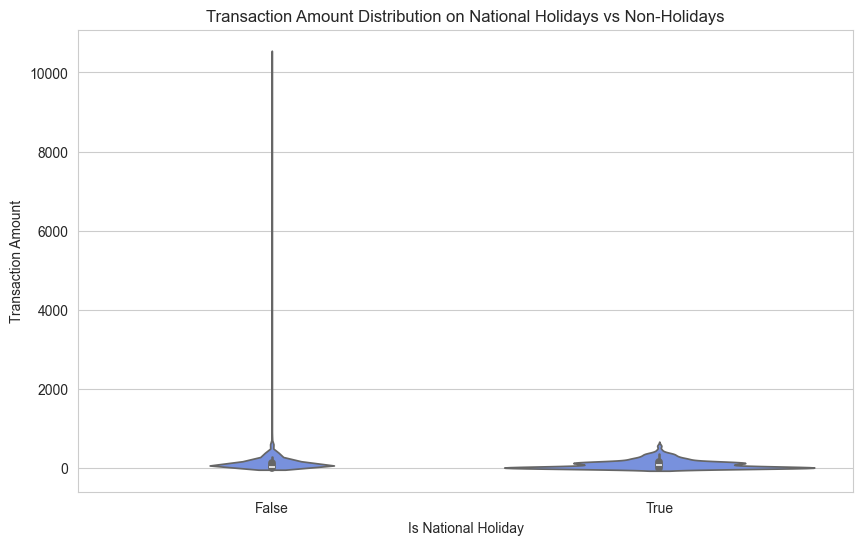

In [248]:
#Step 11: Analyze effect of national holidays on transaction amounts
plt.figure(figsize=(10,6))
sns.violinplot(x='is_national_holiday', y='TotalAmount', data=mart_all_data)
plt.title('Transaction Amount Distribution on National Holidays vs Non-Holidays')
plt.xlabel('Is National Holiday')
plt.ylabel('Transaction Amount')
plt.show()

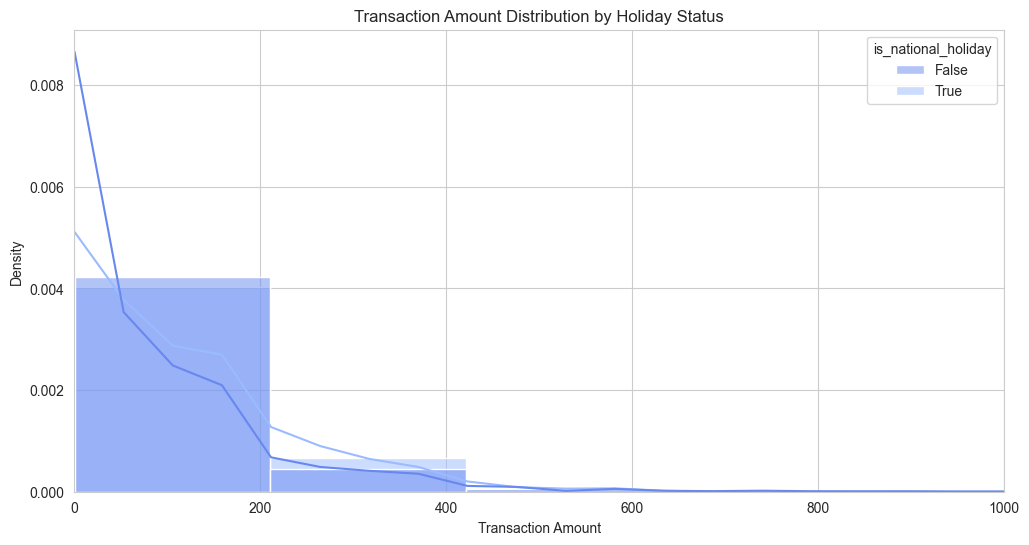

In [249]:
plt.figure(figsize=(12,6))
sns.histplot(data=mart_all_data, x='TotalAmount', hue='is_national_holiday', bins=50, kde=True, stat="density", common_norm=False)
plt.title('Transaction Amount Distribution by Holiday Status')
plt.xlabel('Transaction Amount')
plt.ylabel('Density')
plt.xlim(0, 1000)  # Optional zoom to focus on most transactions
plt.show()

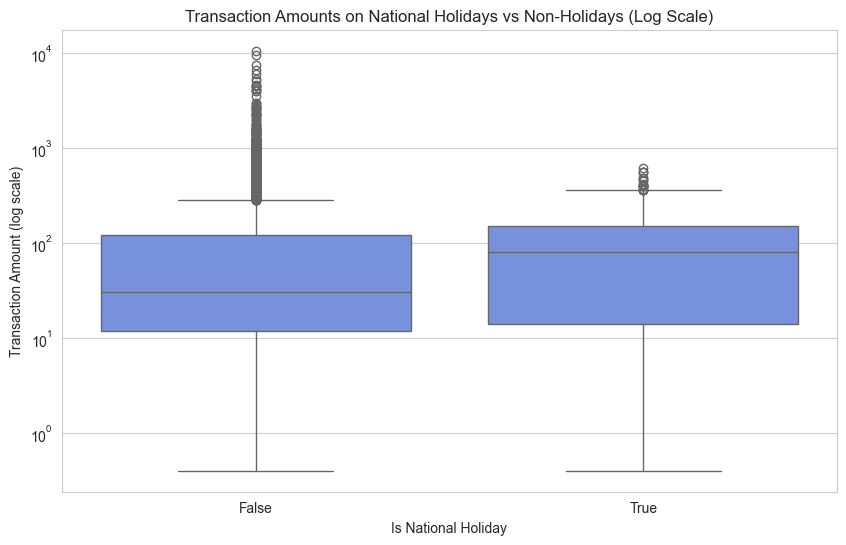

In [250]:
plt.figure(figsize=(10,6))
sns.boxplot(x='is_national_holiday', y='TotalAmount', data=mart_all_data)
plt.yscale('log')
plt.title('Transaction Amounts on National Holidays vs Non-Holidays (Log Scale)')
plt.xlabel('Is National Holiday')
plt.ylabel('Transaction Amount (log scale)')
plt.show()

   is_national_holiday        mean  median  count
0                False   88.064411   30.39  52353
1                 True  105.706673   79.99    571


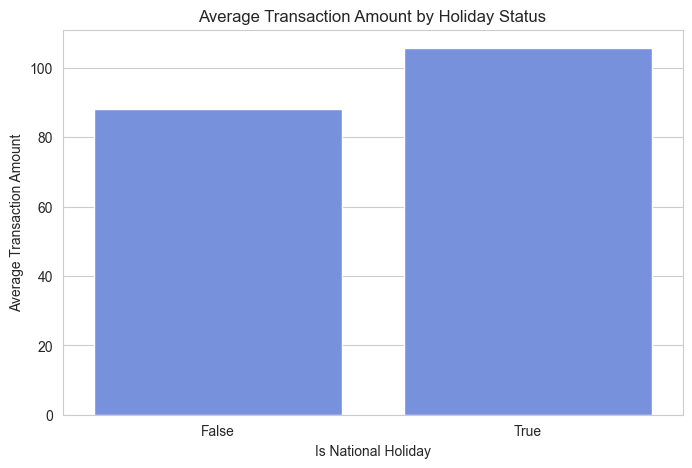

In [251]:
summary_stats = mart_all_data.groupby('is_national_holiday')['TotalAmount'].agg(['mean', 'median', 'count']).reset_index()
print(summary_stats)

plt.figure(figsize=(8,5))
sns.barplot(x='is_national_holiday', y='mean', data=summary_stats)
plt.title('Average Transaction Amount by Holiday Status')
plt.xlabel('Is National Holiday')
plt.ylabel('Average Transaction Amount')
plt.show()

In [252]:
# Aggregate total revenue by holiday flag
revenue_summary = mart_all_data.groupby('is_national_holiday')['TotalAmount'].agg(['sum', 'mean', 'count']).reset_index()
revenue_summary['is_national_holiday'] = revenue_summary['is_national_holiday'].map({True: 'Holiday', False: 'Non-Holiday'})

print(revenue_summary)

  is_national_holiday         sum        mean  count
0         Non-Holiday  4610436.11   88.064411  52353
1             Holiday    60358.51  105.706673    571


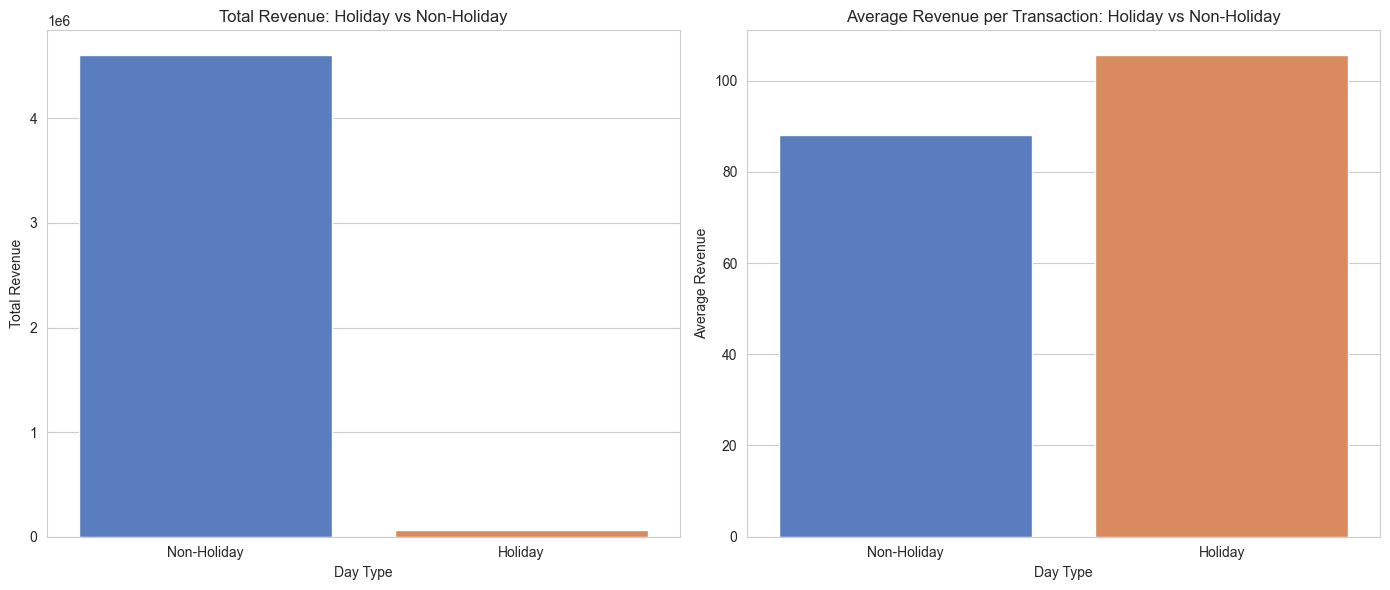

In [253]:

plt.figure(figsize=(14,6))

# Total Revenue Bar Plot
plt.subplot(1,2,1)
sns.barplot(x='is_national_holiday', y='sum', data=revenue_summary, palette='muted')
plt.title('Total Revenue: Holiday vs Non-Holiday')
plt.ylabel('Total Revenue')
plt.xlabel('Day Type')

# Average Revenue per Transaction Bar Plot
plt.subplot(1,2,2)
sns.barplot(x='is_national_holiday', y='mean', data=revenue_summary, palette='muted')
plt.title('Average Revenue per Transaction: Holiday vs Non-Holiday')
plt.ylabel('Average Revenue')
plt.xlabel('Day Type')

plt.tight_layout()
plt.show()

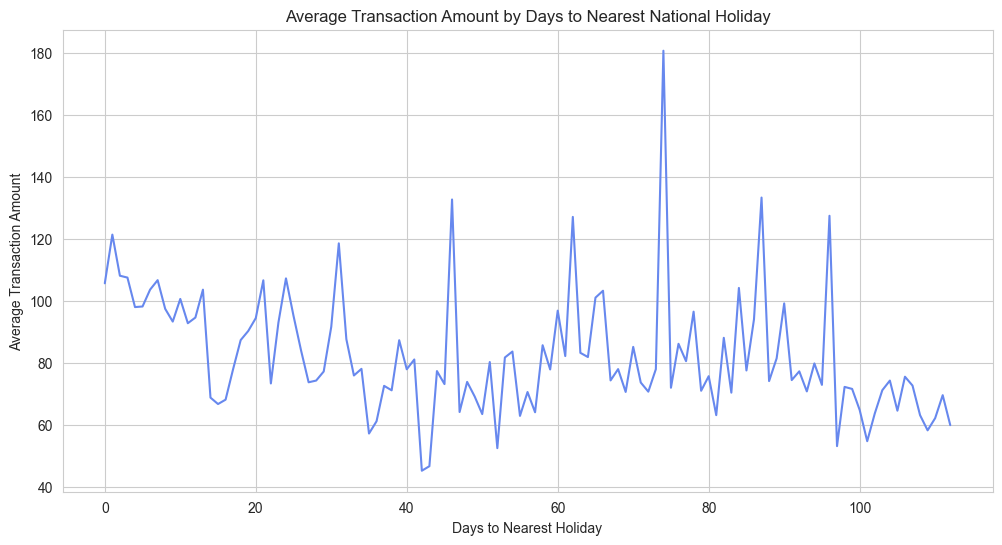

In [254]:
# Convert dates to datetime 
mart_all_data['transaction_date'] = pd.to_datetime(mart_all_data['transaction_date'])
national_holidays['transaction_date'] = pd.to_datetime(national_holidays['transaction_date'])

# Create a set of holiday dates for quick lookup
holiday_dates = set(national_holidays['transaction_date'])

# Calculate days to nearest holiday for each transaction
def days_to_nearest_holiday(date):
    return min(abs((date - hd).days) for hd in holiday_dates)

mart_all_data['days_to_holiday'] = mart_all_data['transaction_date'].apply(days_to_nearest_holiday)

# Aggregate average revenue by days_to_holiday
revenue_by_days = mart_all_data.groupby('days_to_holiday')['TotalAmount'].mean().reset_index()

# Plot
plt.figure(figsize=(12,6))
sns.lineplot(x='days_to_holiday', y='TotalAmount', data=revenue_by_days)
plt.title('Average Transaction Amount by Days to Nearest National Holiday')
plt.xlabel('Days to Nearest Holiday')
plt.ylabel('Average Transaction Amount')
plt.show()

In [255]:

warnings.filterwarnings('ignore')

# Create holiday shopper flag
holiday_customers = mart_all_data[mart_all_data['is_national_holiday'] == True]['customer_id'].unique()
mart_all_data['holiday_shopper'] = mart_all_data['customer_id'].apply(
    lambda x: 'Holiday Shopper' if x in holiday_customers else 'Non-Holiday Shopper'
)

# Generate summary data for holiday shoppers
summary_holiday = summary_data_from_transaction_data(
    mart_all_data[mart_all_data['holiday_shopper'] == 'Holiday Shopper'],
    customer_id_col='customer_id',
    datetime_col='transaction_date',
    monetary_value_col='TotalAmount',
    observation_period_end=mart_all_data['transaction_date'].max()
).reset_index()

# Filter invalid customers
summary_holiday = summary_holiday[(summary_holiday['monetary_value'] > 0) & (summary_holiday['frequency'] > 0)]

print(f"Holiday shoppers count: {summary_holiday.shape[0]}")
print(summary_holiday[['frequency', 'recency', 'T']].describe())

Holiday shoppers count: 33
       frequency     recency           T
count  33.000000   33.000000   33.000000
mean    4.151515  202.272727  271.060606
std     4.146695  113.470611  103.952796
min     1.000000    1.000000    6.000000
25%     2.000000  147.000000  227.000000
50%     4.000000  220.000000  310.000000
75%     5.000000  289.000000  345.000000
max    23.000000  351.000000  364.000000


In [256]:
# Fit BG/NBD model with penalizer and convergence handling
penalizer = 0.1  # Adjust if needed

try:
    bgf_holiday = BetaGeoFitter(penalizer_coef=penalizer)
    bgf_holiday.fit(summary_holiday['frequency'], summary_holiday['recency'], summary_holiday['T'])
    print("BG/NBD model fit successfully!")
except ConvergenceError:
    print(f"Model failed to converge with penalizer {penalizer}. Try increasing penalizer or check data.")

# Fit Gamma-Gamma model
ggf_holiday = GammaGammaFitter()
ggf_holiday.fit(summary_holiday['frequency'], summary_holiday['monetary_value'])

# Predict CLV for next 30 days
summary_holiday['predicted_clv'] = ggf_holiday.customer_lifetime_value(
    bgf_holiday,
    summary_holiday['frequency'],
    summary_holiday['recency'],
    summary_holiday['T'],
    summary_holiday['monetary_value'],
    time=30,
    freq='D',
    discount_rate=0.01
)

print("Top 5 Holiday Shoppers by predicted CLV:")
print(summary_holiday[['customer_id', 'predicted_clv']].sort_values(by='predicted_clv', ascending=False).head())

BG/NBD model fit successfully!
Top 5 Holiday Shoppers by predicted CLV:
    customer_id  predicted_clv
21        15311  138582.740407
6         13113   50976.156189
26        16109   31561.827157
2         12626   29081.058703
14        14462   27203.962684


In [257]:
# Generate summary data for non-holiday shoppers
summary_non_holiday = summary_data_from_transaction_data(
    mart_all_data[mart_all_data['holiday_shopper'] == 'Non-Holiday Shopper'],
    customer_id_col='customer_id',
    datetime_col='transaction_date',
    monetary_value_col='TotalAmount',
    observation_period_end=mart_all_data['transaction_date'].max()
).reset_index()

# Filter out customers with non-positive monetary value or zero frequency
summary_non_holiday = summary_non_holiday[(summary_non_holiday['monetary_value'] > 0) & (summary_non_holiday['frequency'] > 0)]

print(f"Non-Holiday shoppers count: {summary_non_holiday.shape[0]}")
print(summary_non_holiday[['frequency', 'recency', 'T']].describe())

# Fit BG/NBD model with penalizer and handle convergence issues
penalizer = 0.1

try:
    bgf_non_holiday = BetaGeoFitter(penalizer_coef=penalizer)
    bgf_non_holiday.fit(summary_non_holiday['frequency'], summary_non_holiday['recency'], summary_non_holiday['T'])
    print("BG/NBD model for Non-Holiday Shoppers fit successfully!")
except ConvergenceError:
    print(f"Model failed to converge with penalizer {penalizer} for Non-Holiday Shoppers. Try increasing penalizer or check data.")

# Fit Gamma-Gamma model
ggf_non_holiday = GammaGammaFitter()
ggf_non_holiday.fit(summary_non_holiday['frequency'], summary_non_holiday['monetary_value'])

# Predict CLV for next 30 days
summary_non_holiday['predicted_clv'] = ggf_non_holiday.customer_lifetime_value(
    bgf_non_holiday,
    summary_non_holiday['frequency'],
    summary_non_holiday['recency'],
    summary_non_holiday['T'],
    summary_non_holiday['monetary_value'],
    time=30,
    freq='D',
    discount_rate=0.01
)

print("Top 5 Non-Holiday Shoppers by predicted CLV:")
print(summary_non_holiday[['customer_id', 'predicted_clv']].sort_values(by='predicted_clv', ascending=False).head())

Non-Holiday shoppers count: 701
        frequency     recency           T
count  701.000000  701.000000  701.000000
mean     2.286733  125.255350  241.184023
std      2.565532  101.649027   90.809638
min      1.000000    1.000000    1.000000
25%      1.000000   24.000000  186.000000
50%      1.000000  114.000000  263.000000
75%      3.000000  202.000000  318.000000
max     33.000000  358.000000  363.000000
BG/NBD model for Non-Holiday Shoppers fit successfully!
Top 5 Non-Holiday Shoppers by predicted CLV:
      customer_id  predicted_clv
547         14606   79310.570353
625         14911   70713.565535
1318        17841   64014.150726
197         13089   47136.930884
649         15039   31089.954930


In [258]:
summary_holiday['segment'] = 'Holiday Shopper'
summary_non_holiday['segment'] = 'Non-Holiday Shopper'

combined_summary = pd.concat([summary_holiday, summary_non_holiday])

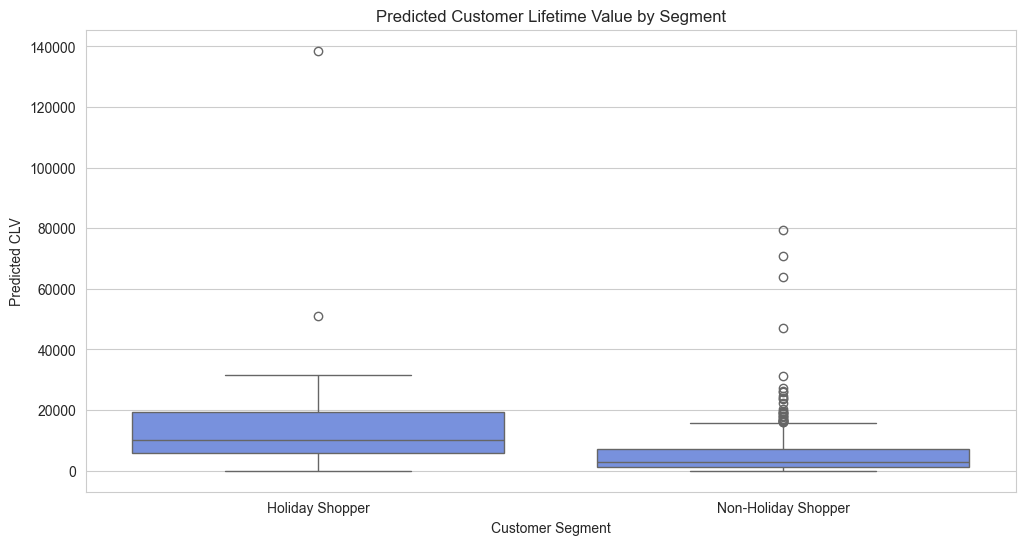

In [259]:
plt.figure(figsize=(12,6))
sns.boxplot(x='segment', y='predicted_clv', data=combined_summary)
plt.title('Predicted Customer Lifetime Value by Segment')
plt.ylabel('Predicted CLV')
plt.xlabel('Customer Segment')
plt.show()

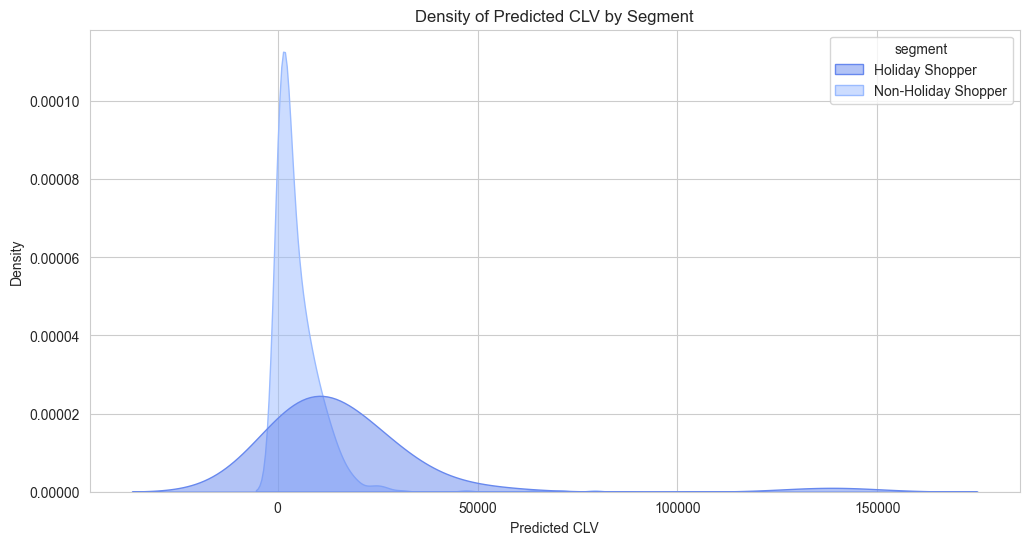

In [260]:
plt.figure(figsize=(12,6))
sns.kdeplot(data=combined_summary, x='predicted_clv', hue='segment', fill=True, common_norm=False, alpha=0.5)
plt.title('Density of Predicted CLV by Segment')
plt.xlabel('Predicted CLV')
plt.show()

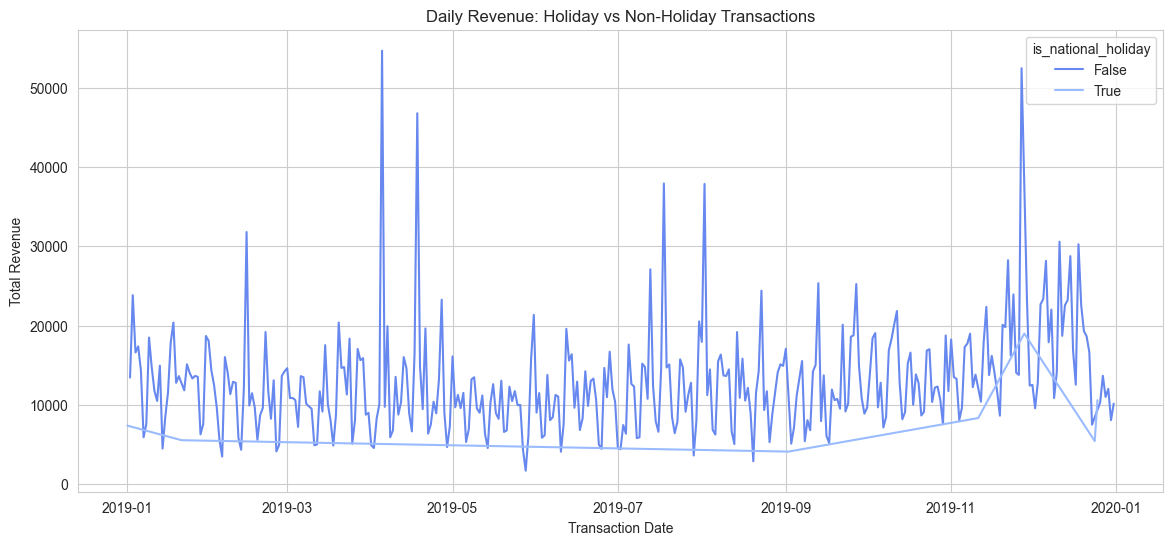

In [413]:
mart_all_data['transaction_date'] = pd.to_datetime(mart_all_data['transaction_date'])

plt.figure(figsize=(14,6))
daily_revenue = mart_all_data.groupby(['transaction_date', 'is_national_holiday'])['TotalAmount'].sum().reset_index()

sns.lineplot(data=daily_revenue, x='transaction_date', y='TotalAmount', hue='is_national_holiday')
plt.title('Daily Revenue: Holiday vs Non-Holiday Transactions')
plt.xlabel('Transaction Date')
plt.ylabel('Total Revenue')
plt.show()

In [ ]:

# 1. Set up connection (update credentials and host!)

config = dotenv_values() 


pg_user = config['POSTGRES_USER']  
pg_host = config['POSTGRES_HOST']
pg_port = config['POSTGRES_PORT']
pg_db = config['POSTGRES_DB']
pg_schema = config['POSTGRES_SCHEMA']
pg_pass = config['POSTGRES_PASS']

url = f'postgresql://{pg_user}:{pg_pass}@{pg_host}:{pg_port}/{pg_db}'

engine = create_engine(url, echo=False)

# 2. Load data

my_schema = "team_3"

df_all = pd.read_sql(
    f"SELECT * FROM {my_schema}.mart_all_data;",
    engine,
    parse_dates=['transaction_date']
)

df_holidays = pd.read_sql(
    f"SELECT * FROM {my_schema}.mart_holidays_2019_us;",
    engine,
    parse_dates=["date"]
)

In [262]:
df_all['transaction_date'] = pd.to_datetime(df_all['transaction_date']).dt.normalize()
df_holidays['date'] = pd.to_datetime(df_holidays['date']).dt.normalize()

In [263]:
df_merged = df_all.merge(df_holidays, left_on='transaction_date', right_on='date', how='left')

In [264]:
df_merged = df_merged.drop(columns=['date'])

In [265]:
#Create holiday indicator column
df_merged['is_holiday'] = df_merged['name'].notnull()

In [266]:
# Create dummies by holiday type
holiday_type_dummies = pd.get_dummies(df_merged['type'], prefix='holiday_type', dummy_na=True)
df_merged = pd.concat([df_merged, holiday_type_dummies], axis=1)

In [267]:
df_merged.columns

Index(['transaction_date', 'transaction_id', 'customer_id', 'customer_gender', 'customer_location', 'customer_tenure_months', 'produkt_sku',
       'product_category', 'quantity', 'avg_price', 'delivery_charges', 'revenue', 'coupon_status', 'discount_pct', 'gst_onsale', 'daily_offline',
       'daily_online', 'transaction_month', 'transaction_month_str', 'name', 'description', 'type', 'religious_holiday', 'local_holiday', 'national_holiday',
       'worldwide_observance', 'is_holiday', 'holiday_type_Christian', 'holiday_type_Clock change/Daylight Saving Time', 'holiday_type_Hebrew',
       'holiday_type_Hinduism', 'holiday_type_Local holiday', 'holiday_type_Local holiday, Christian', 'holiday_type_Local observance', 'holiday_type_Muslim',
       'holiday_type_National holiday', 'holiday_type_National holiday, Christian', 'holiday_type_Observance', 'holiday_type_Observance, Christian',
       'holiday_type_Orthodox', 'holiday_type_Season', 'holiday_type_Sporting event', 'holiday_type_Un

In [268]:
ltv_final = pd.read_csv('../LTV-Capstone-Project/Customer_LTV_Summary.csv')

In [269]:
ltv_final.columns = ltv_final.columns.str.lower()

In [270]:
ltv_final = ltv_final.rename(columns={'customerid': 'customer_id'})

In [271]:
# Step 1: Create dummies for holiday names
holiday_name_dummies = pd.get_dummies(df_merged['name'], prefix='holiday_name', dummy_na=False)

# Optional: clean dummy column names now (before concatenation)
holiday_name_dummies.columns = holiday_name_dummies.columns.str.replace('[^0-9a-zA-Z_]', '_', regex=True)

# Step 2: Add customer_id and group by customer
holiday_name_flags = pd.concat([df_merged['customer_id'], holiday_name_dummies], axis=1)
holiday_name_flags = holiday_name_flags.groupby('customer_id').max().reset_index()

# Step 2b: Create holiday_flags (overall holiday indicator)
holiday_flags = df_merged[['customer_id', 'is_holiday']].groupby('customer_id').max().reset_index()

# Step 2c: Create holiday_type_flags (holiday type dummies by customer)
holiday_type_columns = [col for col in df_merged.columns if col.startswith('holiday_type_')]
holiday_type_flags = df_merged[['customer_id'] + holiday_type_columns].groupby('customer_id').max().reset_index()

# Step 3: Merge holiday flags (overall + types + names) into ltv_final
ltv_holiday = ltv_final.merge(holiday_flags, on='customer_id', how='left')
ltv_holiday = ltv_holiday.merge(holiday_type_flags, on='customer_id', how='left')
ltv_holiday = ltv_holiday.merge(holiday_name_flags, on='customer_id', how='left')

# Step 4: Fill NaNs for all holiday indicators
ltv_holiday['is_holiday'] = ltv_holiday['is_holiday'].fillna(0)

# Fill holiday type columns NaNs with 0
for col in holiday_type_flags.columns:
    if col != 'customer_id':
        ltv_holiday[col] = ltv_holiday[col].fillna(0)

# Fill holiday name columns NaNs with 0
for col in holiday_name_flags.columns:
    if col != 'customer_id':
        ltv_holiday[col] = ltv_holiday[col].fillna(0)


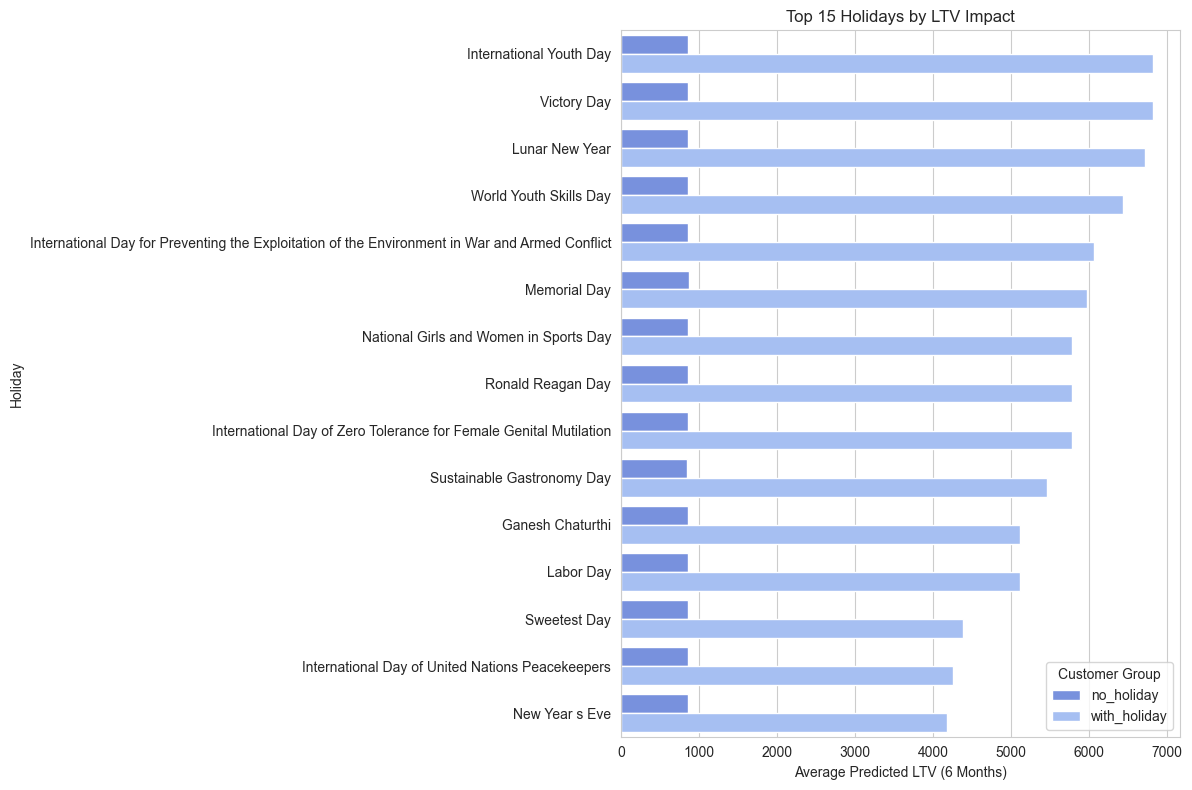

In [272]:
import matplotlib.pyplot as plt
import seaborn as sns

# Identify holiday name columns
holiday_name_cols = [col for col in ltv_holiday.columns if col.startswith('holiday_name_')]

# Prepare DataFrame with LTV differences
holiday_ltv_impact = []

for col in holiday_name_cols:
    ltv_mean = ltv_holiday.groupby(col)['predicted_ltv_6m'].mean()
    no_holiday = ltv_mean.get(0, 0)
    with_holiday = ltv_mean.get(1, 0)
    diff = with_holiday - no_holiday
    holiday_ltv_impact.append({
        'holiday': col.replace('holiday_name_', '').replace('_', ' '),
        'no_holiday': no_holiday,
        'with_holiday': with_holiday,
        'ltv_diff': diff
    })

# Create DataFrame and get top 15 by absolute LTV difference
impact_df = pd.DataFrame(holiday_ltv_impact)
top15 = impact_df.reindex(impact_df['ltv_diff'].abs().sort_values(ascending=False).index).head(15)

# Melt for plotting
impact_melted = top15.melt(id_vars='holiday', value_vars=['no_holiday', 'with_holiday'],
                           var_name='group', value_name='avg_ltv')

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(data=impact_melted, x='avg_ltv', y='holiday', hue='group')
plt.title('Top 15 Holidays by LTV Impact')
plt.xlabel('Average Predicted LTV (6 Months)')
plt.ylabel('Holiday')
plt.legend(title='Customer Group')
plt.tight_layout()
plt.show()

In [273]:
impact_melted.head(10)

holiday       group     avg_ltv
0                            International Youth Day  no_holiday  865.600028
1                                        Victory Day  no_holiday  865.600028
2                                     Lunar New Year  no_holiday  865.813283
3                             World Youth Skills Day  no_holiday  854.952997
4  International Day for Preventing the Exploitat...  no_holiday  860.050987
5                                       Memorial Day  no_holiday  874.300319
6             National Girls and Women in Sports Day  no_holiday  857.657090
7                                  Ronald Reagan Day  no_holiday  857.657090
8  International Day of Zero Tolerance for Female...  no_holiday  857.657090
9                         Sustainable Gastronomy Day  no_holiday  852.693599

In [ ]:
# Export to CSV for Tableau
# impact_melted.to_csv("holidays_by_ltv_impact.csv", index=False)

In [ ]:
# import os
# print(os.getcwd())

Y-axis (Holiday): The top 15 holidays where purchase behavior had the largest difference in LTV, based on whether a customer made a purchase on that day.
X-axis (Average Predicted LTV in $ or units): The average 6-month predicted LTV for two groups:
"no_holiday": Customers who did not make purchases during that holiday.
"with_holiday": Customers who did make purchases during that holiday.

Bars: Each holiday has two bars:
One for average LTV of non-participants in that holiday.
One for participants (customers who purchased during that holiday).
Sort Order: Holidays are sorted by the largest absolute LTV difference, showing where the holiday had the most significant impact on customer value.

INTERPRETATION

If the “with_holiday” bar is much higher, it suggests:
Customers who shopped on this holiday are significantly more valuable over the next 6 months.
If it’s lower, it might mean:
Holiday shoppers were more opportunistic (e.g., deal seekers) and didn’t return often.
If the bars are similar:
The holiday didn’t have a major effect on customer future value.

e.g. Customers who made purchases on Victory Day tend to spend more or return more often, and may be a high-value segment worth targeting again next year.

In [306]:
import numpy as np
import pandas as pd

def check_ltv_identity(df, ltv_col="predicted_ltv_6m",
                       purch_col="predicted_purchases_6m",
                       aov_col="predicted_avg_value",
                       top_n=10):
    required = [ltv_col, purch_col, aov_col]
    missing = [c for c in required if c not in df.columns]
    if missing:
        raise KeyError(f"Missing columns: {missing}. Have: {list(df.columns)}")

    d = df[[ltv_col, purch_col, aov_col]].copy()
    for c in required:
        d[c] = pd.to_numeric(d[c], errors="coerce")
    d = d.dropna(subset=required)

    d["recomposed_ltv"] = d[purch_col] * d[aov_col]
    d["gap"] = d[ltv_col] - d["recomposed_ltv"]
    d["gap_abs"] = d["gap"].abs()
    d["gap_pct_of_recomposed"] = d["gap_abs"] / d["recomposed_ltv"].replace(0, np.nan)

    # summary stats
    med_abs_gap  = float(d["gap_abs"].median())
    med_pct_gap  = float(d["gap_pct_of_recomposed"].median() * 100)
    mean_pct_gap = float(d["gap_pct_of_recomposed"].mean() * 100)

    # ratio to detect cents/dollars mismatches etc.
    ratio = d[ltv_col] / d["recomposed_ltv"].replace(0, np.nan)
    ratio_med = float(ratio.median())
    ratio_mode = float(ratio.round(2).mode().iloc[0]) if ratio.notna().any() else np.nan

    print("=== LTV Identity Check ===")
    print(f"Median |gap|: {med_abs_gap:,.2f}")
    print(f"Median %|gap| of recomposed: {med_pct_gap:.1f}% (mean: {mean_pct_gap:.1f}%)")
    print(f"Median ratio (ltv / (purchases×aov)): {ratio_med:.2f}  |  Mode (≈): {ratio_mode:.2f}")

    # Heuristic hints
    if ratio_med > 1.8 and ratio_med < 2.2:
        print("Hint: LTV is about 2× recomposed — check if avg value is gross vs net, or if LTV window is double-counted.")
    if ratio_med > 95 and ratio_med < 105:
        print("Hint: LTV is ≈100× recomposed — likely cents vs dollars issue (divide by 100).")
    if ratio_med > 0.95 and ratio_med < 1.05:
        print("Good: LTV and recomposed align within ~5% on median.")
    if ratio_med < 0.95 or ratio_med > 1.05:
        print("Action: consider normalizing units or recomputing LTV directly as purchases×avg_value.")

    # show biggest offenders
    offenders = d.sort_values("gap_abs", ascending=False).head(top_n)
    print(f"\nTop {top_n} rows by absolute gap:")
    display(offenders[[ltv_col, purch_col, aov_col, "recomposed_ltv", "gap", "gap_pct_of_recomposed"]])
    return d
     
_ = check_ltv_identity(ltv_final)

=== LTV Identity Check ===
Median |gap|: 0.00
Median %|gap| of recomposed: 0.0% (mean: 0.0%)
Median ratio (ltv / (purchases×aov)): 1.00  |  Mode (≈): 1.00
Good: LTV and recomposed align within ~5% on median.

Top 10 rows by absolute gap:


predicted_ltv_6m  predicted_purchases_6m  predicted_avg_value  recomposed_ltv           gap  gap_pct_of_recomposed
643       15974.121923                9.556602          1671.527299    15974.121923  1.818989e-12           1.138710e-16
703        5553.915888                2.579381          2153.197390     5553.915888 -9.094947e-13           1.637574e-16
1213       4187.088678                4.268791           980.860587     4187.088678 -9.094947e-13           2.172141e-16
234        3277.224746                1.230935          2662.385655     3277.224746  9.094947e-13           2.775198e-16
226        4231.224429                1.908465          2217.083026     4231.224429  9.094947e-13           2.149483e-16
77         3458.569884                2.974715          1162.656036     3458.569884  9.094947e-13           2.629684e-16
370        1450.210493                1.409007          1029.242870     1450.210493  6.821210e-13           4.703600e-16
544        1665.904274                1.089453          1529.119571     1665.904274  6.821210e-13           4.094599e-16
35         2302.464775                1.915850          1201.798187     2302.464775 -4.547474e-13           1.975046e-16
1344       1985.897377                1.282749          1548.156986     1985.897377 -4.547474e-13           2.289883e-16